# **Задача 4. Обработка стали**

---

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

---

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

### **Импортирование библиотек**

---

In [466]:
import pandas as pd
import missingno as msgn
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from phik.report import plot_correlation_matrix

In [467]:
from sklearn.impute import KNNImputer

In [468]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.forecasting.compose import TransformedTargetForecaster, make_reduction
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.boxcox import LogTransformer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sktime.forecasting.base import ForecastingHorizon
from sktime.datasets import load_arrow_head
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

In [469]:
import warnings
warnings.filterwarnings('ignore')

#### **Чтение файлов и сохранение полученных данных в переменные**

---

In [470]:
df_data_arc = pd.read_csv("final_steel\\data_arc.csv")
df_data_bulk = pd.read_csv('final_steel\\data_bulk.csv')
df_data_bulk_time = pd.read_csv('final_steel\\data_bulk_time.csv')
df_data_gas = pd.read_csv('final_steel\\data_gas.csv')
df_data_temp = pd.read_csv('final_steel\\data_temp.csv')
df_data_wire = pd.read_csv('final_steel\\data_wire.csv')
df_data_wire_time = pd.read_csv('final_steel\\data_wire_time.csv')

### **Анализ данных**

---

#### **Анализ данных датасета 'data_arc.csv'**

---

In [471]:
df_data_arc.head()

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397

In [472]:
df_data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [473]:
df_data_arc.duplicated().sum()

0

Явных дубликатов в датасете нет.

<Axes: >

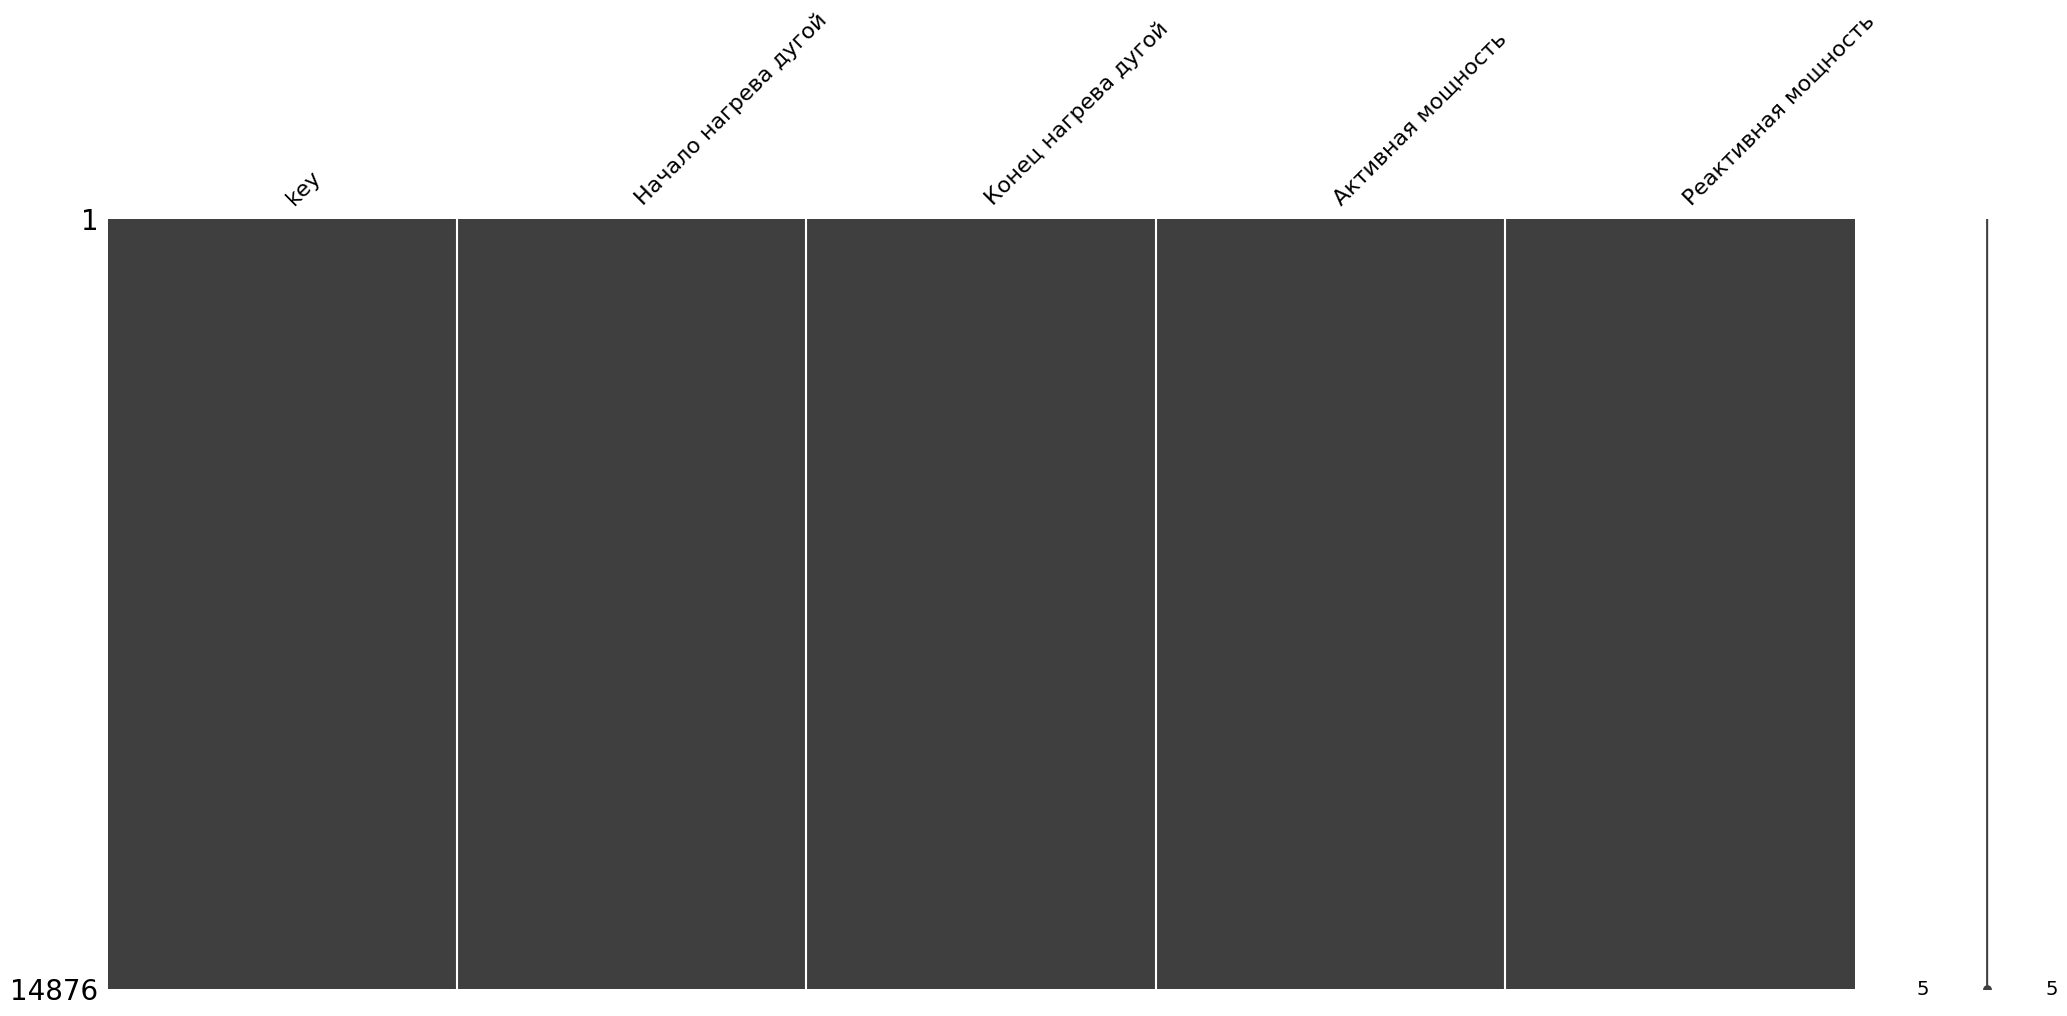

In [474]:
msgn.matrix(df_data_arc)

In [475]:
df_data_arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Пропусков в датасете нет.

In [476]:
df_data_arc.nunique()

key                      3214
Начало нагрева дугой    14875
Конец нагрева дугой     14876
Активная мощность       14869
Реактивная мощность     14866
dtype: int64

В анализируемом наборе данных обнаружено, что количество уникальных значений в признаках "Начало нагрева дугой", "Активная мощность" и "Реактивная мощность" практически равно общему числу наблюдений в датасете, составляющем 14876. Это указывает на то, что эти признаки обладают высокой вариативностью и могут содержать информацию, полезную для анализа.

В отличие от этого, количество уникальных значений в признаке "key" (номера партий) оказалось значительно меньше, примерно в пять раз. Это объясняется тем, что каждая партия была обработана несколько раз, что привело к нескольким итерациям в данных.

In [477]:
df_data_arc.dtypes

key                       int64
Начало нагрева дугой     object
Конец нагрева дугой      object
Активная мощность       float64
Реактивная мощность     float64
dtype: object

In [478]:
df_data_arc['Начало нагрева дугой'] = pd.to_datetime(df_data_arc['Начало нагрева дугой'])
df_data_arc['Конец нагрева дугой'] = pd.to_datetime(df_data_arc['Конец нагрева дугой'])

In [479]:
df_data_arc.dtypes

key                              int64
Начало нагрева дугой    datetime64[ns]
Конец нагрева дугой     datetime64[ns]
Активная мощность              float64
Реактивная мощность            float64
dtype: object

In [480]:
# проверим самую раннюю дату проведения измерений
print('Дата самого раннего начала нагрева: \n',
      df_data_arc['Начало нагрева дугой'].min())
print('Дата самого раннего окончания нагрева: \n',
      df_data_arc['Конец нагрева дугой'].min())

Дата самого раннего начала нагрева: 
 2019-05-03 11:02:14
Дата самого раннего окончания нагрева: 
 2019-05-03 11:06:02


In [481]:
# проверим самую позднюю дату проведения измерений
print('Дата самого позднего начала нагрева: \n',
      df_data_arc['Начало нагрева дугой'].max())
print('Дата самого позднего окончания нагрева: \n',
      df_data_arc['Конец нагрева дугой'].max())

Дата самого позднего начала нагрева: 
 2019-09-01 04:34:47
Дата самого позднего окончания нагрева: 
 2019-09-01 04:36:08


In [482]:
# проверим, сколько времени прошло между самым ранним и поздним
# окончанием нагрева
print('Промежуток между самым ранним и поздним началом нагрева: \n',
      df_data_arc['Конец нагрева дугой'].max() - \
      df_data_arc['Конец нагрева дугой'].min())

Промежуток между самым ранним и поздним началом нагрева: 
 120 days 17:30:06


In [483]:
df_data_arc.describe().T

count                           mean  \
key                   14876.0                    1615.220422   
Начало нагрева дугой    14876  2019-07-02 16:15:28.218203904   
Конец нагрева дугой     14876  2019-07-02 16:18:19.889150208   
Активная мощность     14876.0                       0.670441   
Реактивная мощность   14876.0                       0.452592   

                                      min                            25%  \
key                                   1.0                          806.0   
Начало нагрева дугой  2019-05-03 11:02:14  2019-06-02 07:01:09.249999872   
Конец нагрева дугой   2019-05-03 11:06:02            2019-06-02 07:04:21   
Активная мощность                0.030002                       0.395297   
Реактивная мощность           -715.504924                       0.290991   

                                             50%  \
key                                       1617.0   
Начало нагрева дугой  2019-06-30 09:57:14.500000   
Конец нагрева дугой          2019-06-30 10:01:01   
Активная мощность                       0.555517   
Реактивная мощность                     0.415962   

                                                75%                  max  \
key                                          2429.0               3241.0   
Начало нагрева дугой  2019-08-03 13:04:47.750000128  2019-09-01 04:34:47   
Конец нагрева дугой             2019-08-03 13:09:14  2019-09-01 04:36:08   
Активная мощность                          0.857034             3.731596   
Реактивная мощность                        0.637371             2.676388   

                             std  
key                   934.571502  
Начало нагрева дугой         NaN  
Конец нагрева дугой          NaN  
Активная мощность       0.408159  
Реактивная мощность     5.878702

Предполагается, что в признаке "Реактивная мощность" могут присутствовать выбросы в направлении минимальных значений. Для проверки этой гипотезы предлагается создать функцию, которая будет выводить два графика одновременно: первый график будет показывать наличие выбросов, а второй - распределение самого признака.

In [484]:
def outliers_and_features_distribution(data, name, description, color):
    # Вычисление границ IQR
    Q1 = data[name].quantile(0.25)
    Q3 = data[name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    
    # Ящик с усами
    sns.boxplot(x=data[name], color=color, ax=axes[0])
    axes[0].axvline(lower_bound, color='r', linestyle='--', label=f'Lower Bound ({lower_bound:.2f})')
    axes[0].axvline(upper_bound, color='r', linestyle='--', label=f'Upper Bound ({upper_bound:.2f})')
    axes[0].legend()
    axes[0].set_title(f'Выбросы в признаке \'{name}\'')
    axes[0].set_xlabel(description, fontsize=18)
    axes[0].set_ylabel('Значения', fontsize=18)
    axes[0].grid(True)
    
    # Гистограмма
    sns.histplot(data[name], color=color, bins=50, ax=axes[1])
    axes[1].axvline(lower_bound, color='r', linestyle='--', label=f'Lower Bound ({lower_bound:.2f})')
    axes[1].axvline(upper_bound, color='r', linestyle='--', label=f'Upper Bound ({upper_bound:.2f})')
    axes[1].legend()
    axes[1].set_title(f'Распределение значений в признаке \'{name}\'')
    axes[1].set_xlabel(description, fontsize=18)
    axes[1].set_ylabel('Частота', fontsize=18)
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

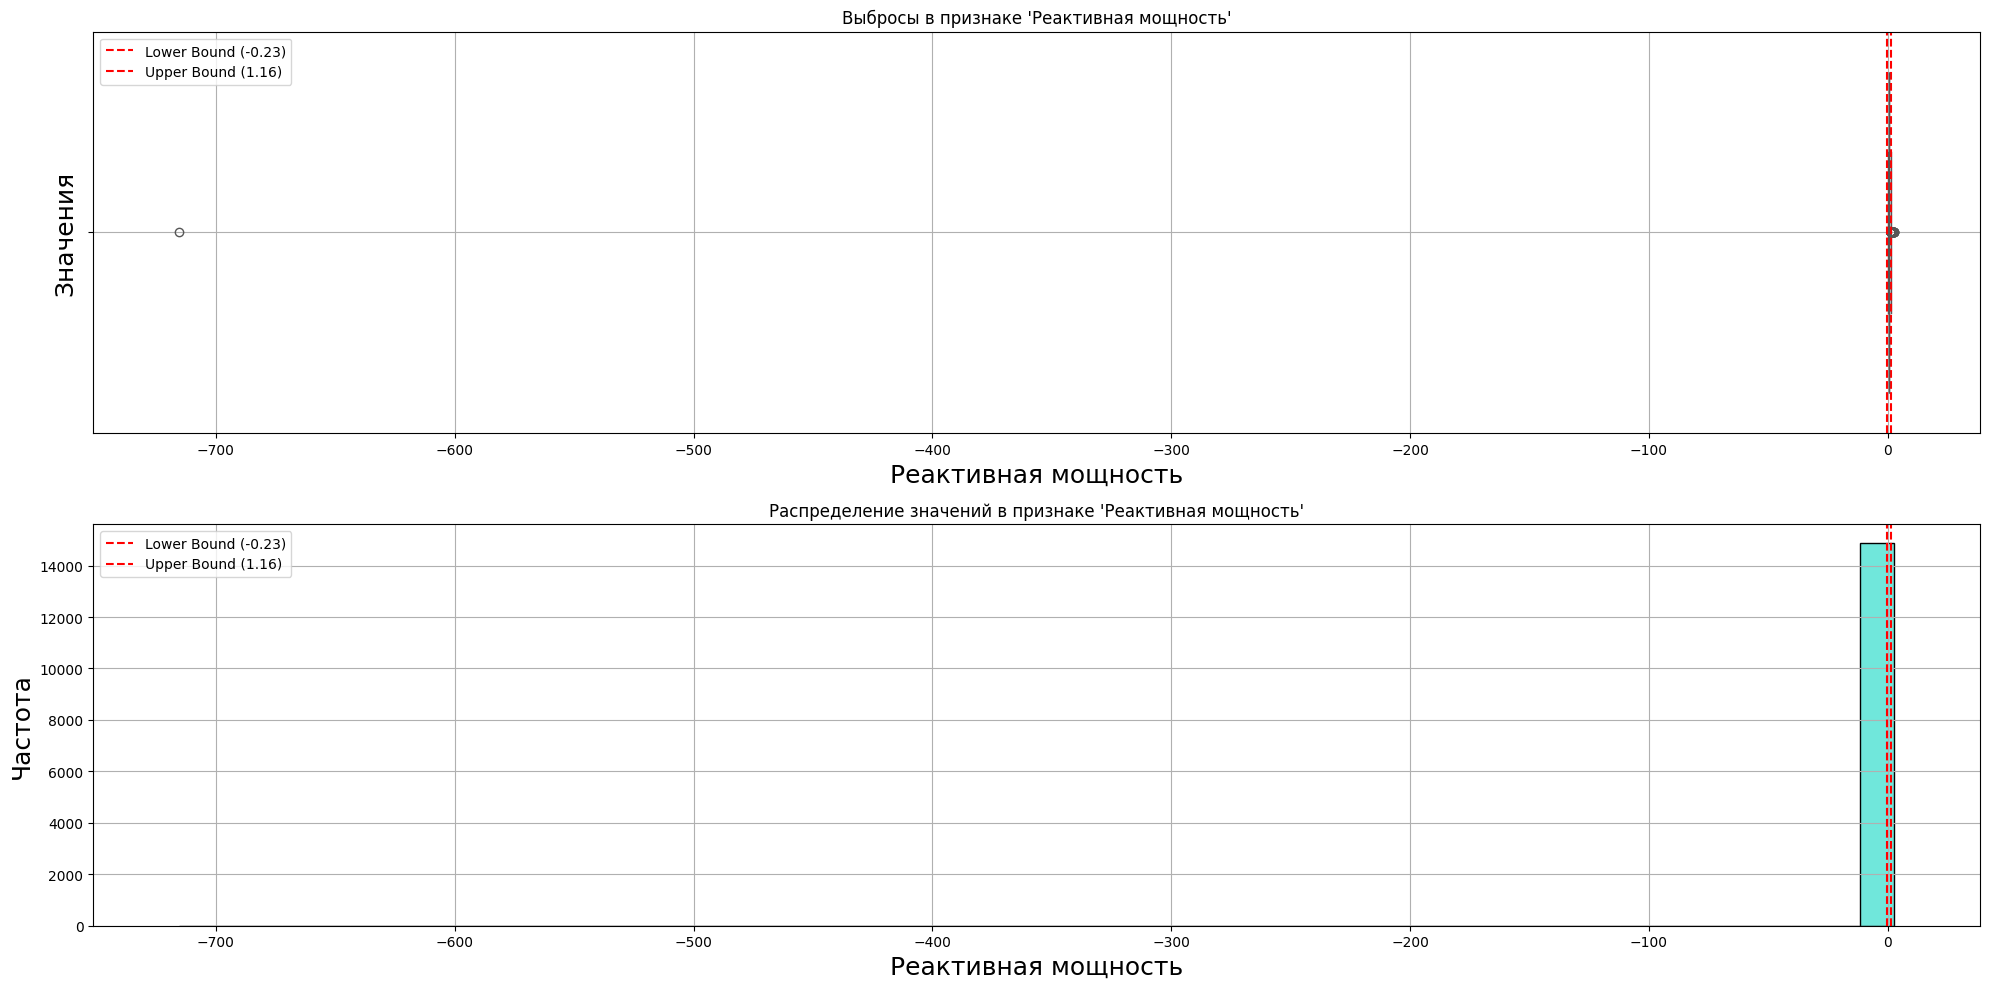

In [485]:
outliers_and_features_distribution(
    df_data_arc,
    'Реактивная мощность',
    'Реактивная мощность',
    'turquoise')

In [486]:
df_data_arc.loc[df_data_arc['Реактивная мощность'] < 0]

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-24 00:44:48 2019-07-24 00:46:37           0.495782   

      Реактивная мощность  
9780          -715.504924

Предложенный выброс требует дальнейшей обработки или удаления. Поскольку он является единичным, предлагается обработать его. Для этого мы заменим его на пропущенное значение (np.nan) и заполним пропуск методом ближайших соседей.

In [487]:
df_data_arc.loc[df_data_arc['Реактивная мощность'] < 0, 'Реактивная мощность'] = np.nan

In [488]:
df_data_arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     1
dtype: int64

In [489]:
imputer_data_arc = KNNImputer(
    n_neighbors = 5,
    copy = False
)

In [490]:
na_columns = ['Активная мощность', 'Реактивная мощность']
na_columns

['Активная мощность', 'Реактивная мощность']

In [491]:
df_data_arc[na_columns] = imputer_data_arc.fit_transform(df_data_arc[na_columns])

In [492]:
df_data_arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Пропущенное значение было успешно заменено методом ближайших соседей, что позволило эффективно удалить выброс. Для проверки эффективности этой операции, рекомендуется повторно отобразить диаграмму размаха и график распределения признака.

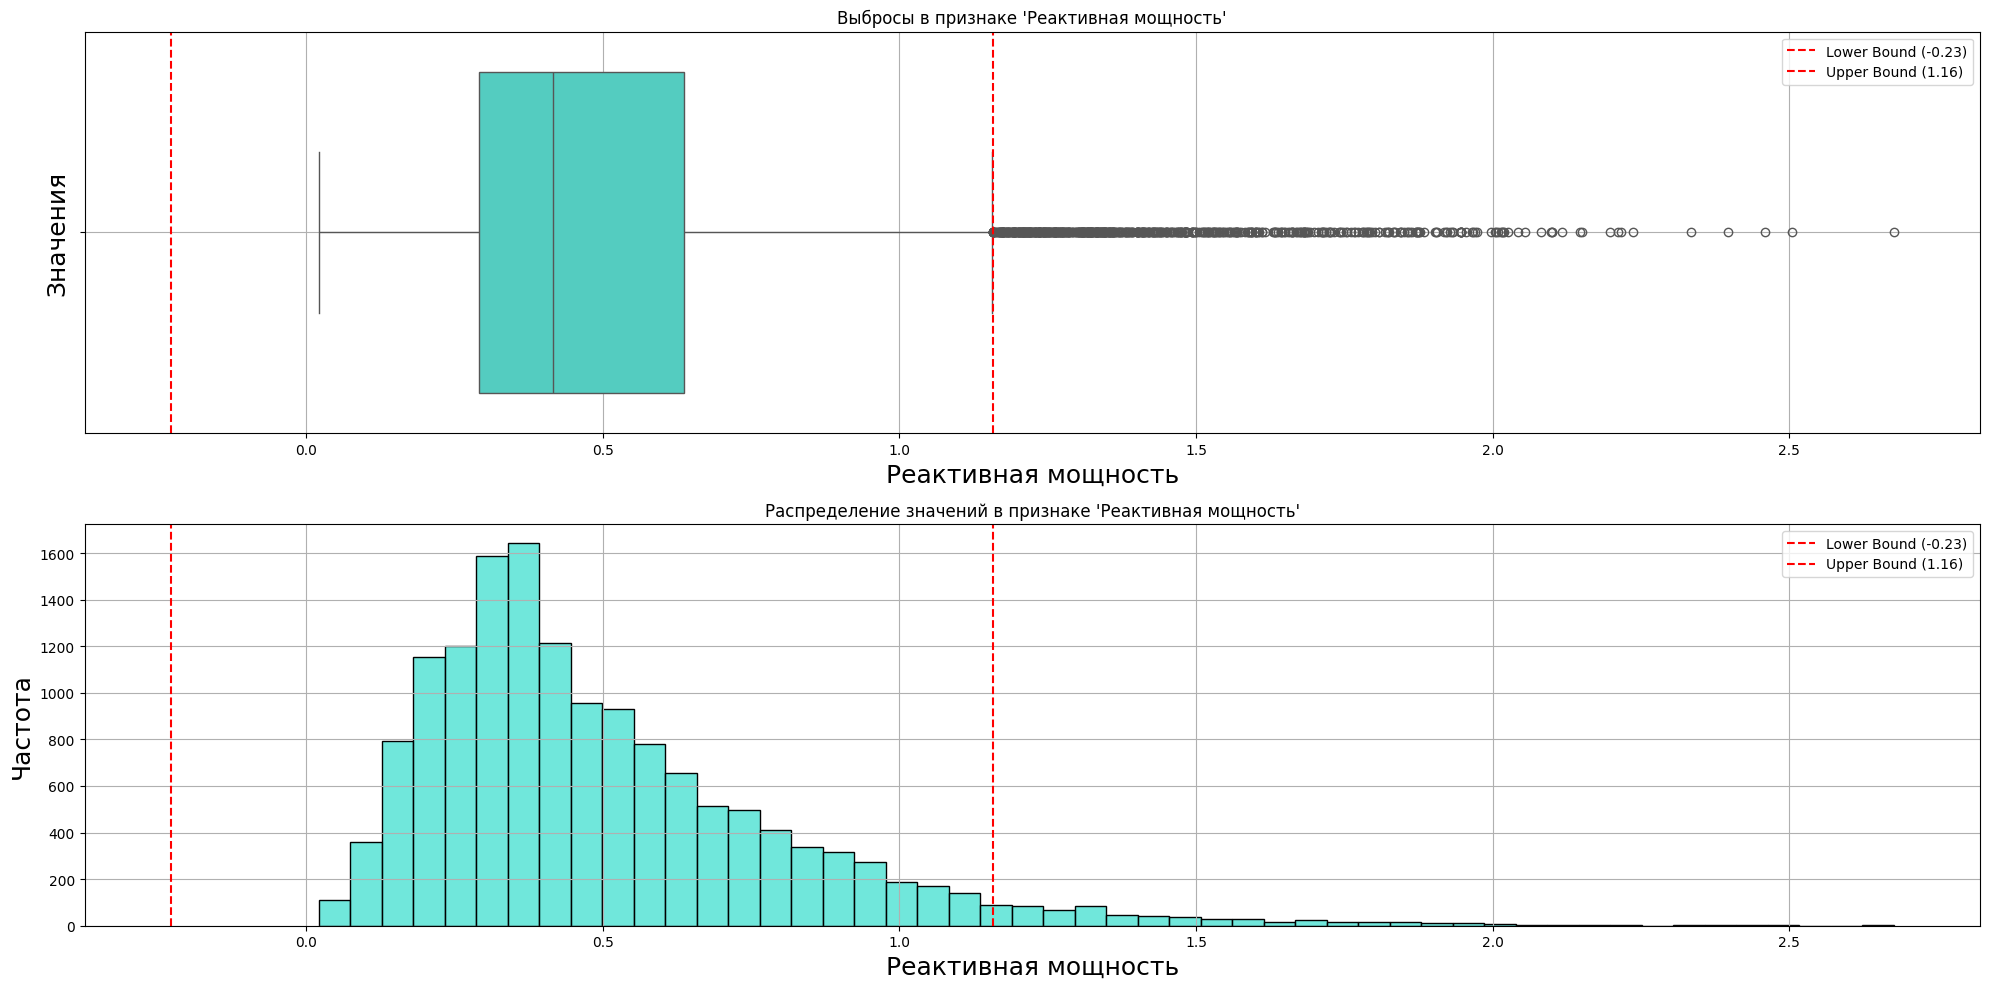

In [493]:
outliers_and_features_distribution(
    df_data_arc,
    'Реактивная мощность',
    'Реактивная мощность',
    'turquoise')

Значения, превышающие 1.16 определены, как выбросы. Посчитаем их количество.

In [494]:
react_power_outliers = round((df_data_arc.loc[df_data_arc['Реактивная мощность'] > 1.16].shape[0] / df_data_arc.shape[0]) * 100, 2)
print(f'Доля выбросов в признаке \'Реактивная мощность\': \n {react_power_outliers}%')

Доля выбросов в признаке 'Реактивная мощность': 
 3.98%


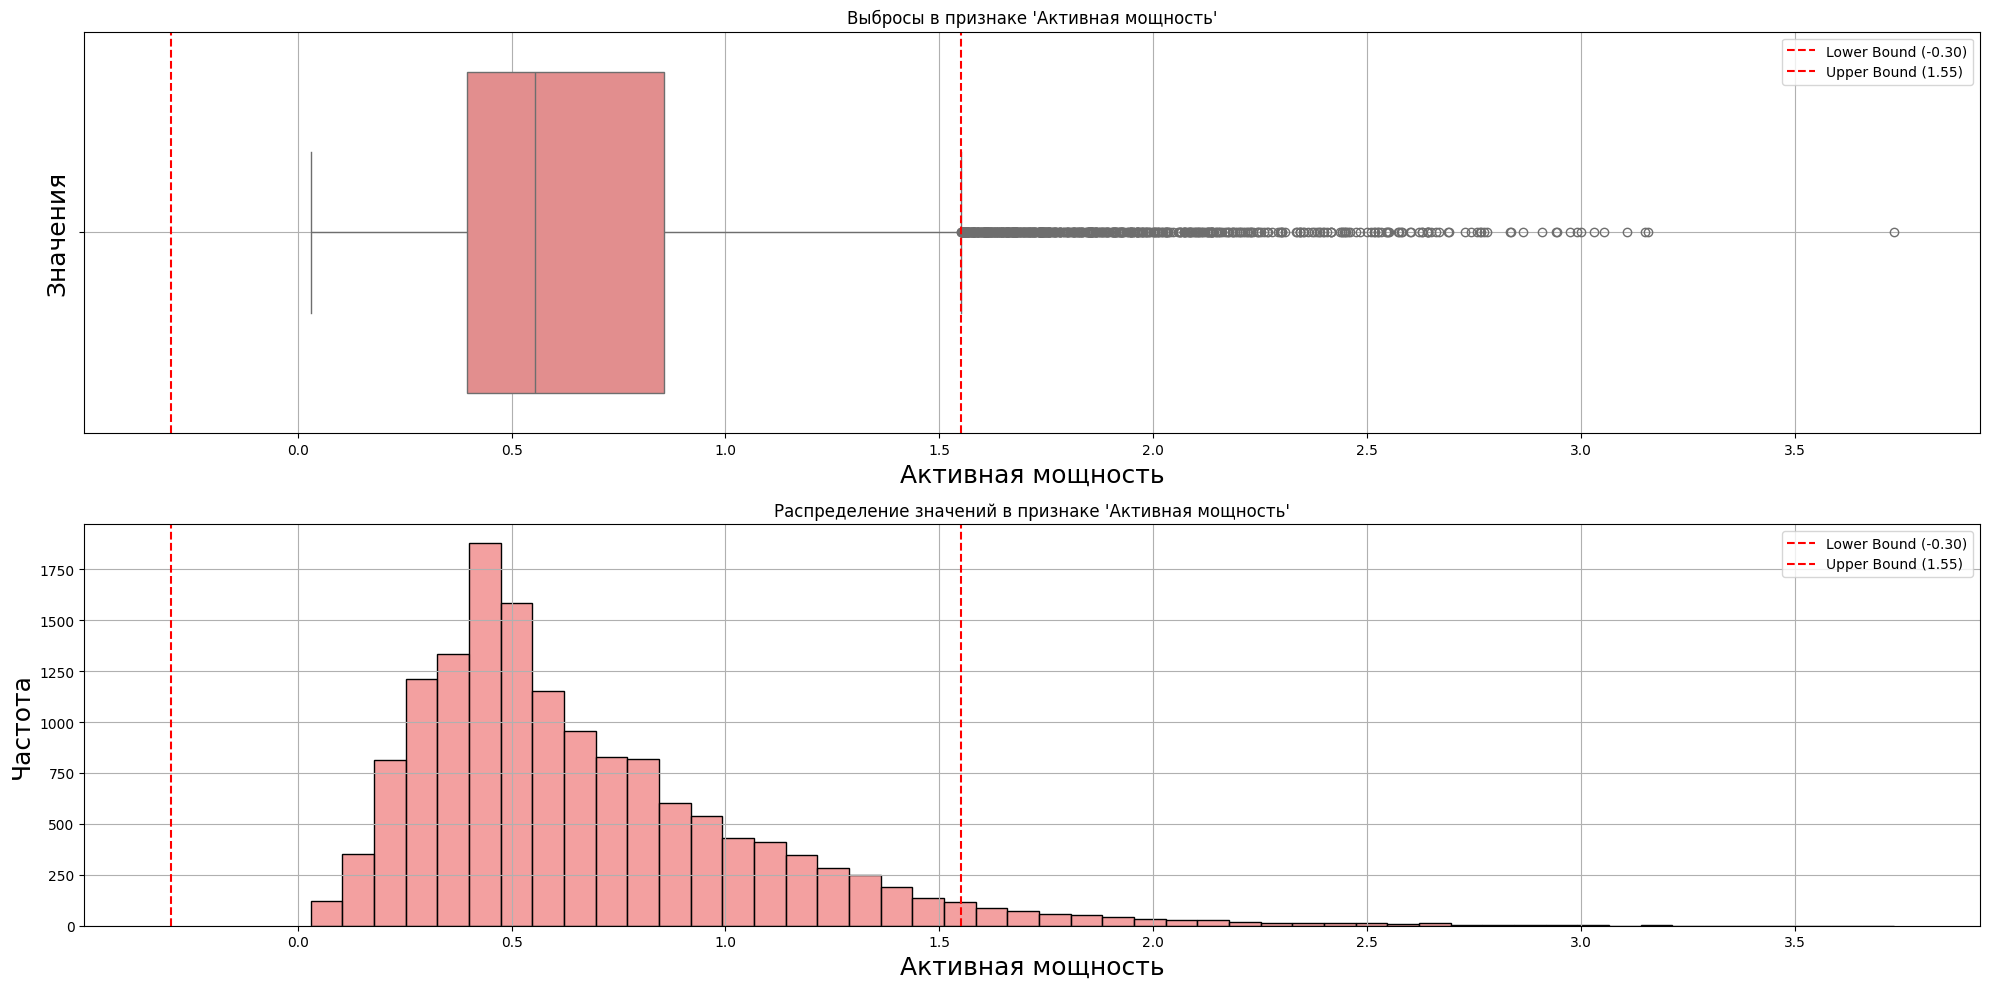

In [495]:
outliers_and_features_distribution(
    df_data_arc,
    'Активная мощность',
    'Активная мощность',
    'lightcoral')

In [496]:
react_power_outliers = round((df_data_arc.loc[df_data_arc['Активная мощность'] > 1.54].shape[0] / df_data_arc.shape[0]) * 100, 2)
print(f'Доля выбросов в признаке \'Активная мощность\': \n {react_power_outliers}%')

Доля выбросов в признаке 'Активная мощность': 
 3.93%


Количество обнаруженных выбросов в признаках "Активная мощность" и "Реактивная мощность" в общей сложности невелико, а диапазон значений не является чрезмерно широким. Все значения будут сохранены, за исключением одного случая: в признаке "Активная мощность" максимальное значение будет заменено на пропущенное значение (np.nan), которое затем будет заполнено методом ближайших соседей.

In [497]:
df_data_arc.loc[df_data_arc['Активная мощность'] > 3.5, 'Активная мощность'] = np.nan

In [498]:
df_data_arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       1
Реактивная мощность     0
dtype: int64

In [499]:
df_data_arc[na_columns] = imputer_data_arc.fit_transform(df_data_arc[na_columns])

In [500]:
df_data_arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Пропуск в признаке 'Активная мощность' успешно заполнен.

#### **Анализ данных датасета 'data_bulk.csv '**

---

In [501]:
df_data_bulk.shape

(3129, 16)

In [502]:
df_data_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [503]:
df_data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Корректеровки типов данных в данном датасете не требуется.

In [504]:
df_data_bulk.describe().T

count         mean         std    min     25%     50%      75%  \
key      3129.0  1624.383509  933.337642    1.0  816.00  1622.0  2431.00   
Bulk 1    252.0    39.242063   18.277654   10.0   27.00    31.0    46.00   
Bulk 2     22.0   253.045455   21.180578  228.0  242.00   251.5   257.75   
Bulk 3   1298.0   113.879045   75.483494    6.0   58.00    97.5   152.00   
Bulk 4   1014.0   104.394477   48.184126   12.0   72.00   102.0   133.00   
Bulk 5     77.0   107.025974   81.790646   11.0   70.00    86.0   132.00   
Bulk 6    576.0   118.925347   72.057776   17.0   69.75   100.0   157.00   
Bulk 7     25.0   305.600000  191.022904   47.0  155.00   298.0   406.00   
Bulk 8      1.0    49.000000         NaN   49.0   49.00    49.0    49.00   
Bulk 9     19.0    76.315789   21.720581   63.0   66.00    68.0    70.50   
Bulk 10   176.0    83.284091   26.060347   24.0   64.00    86.5   102.00   
Bulk 11   177.0    76.819209   59.655365    8.0   25.00    64.0   106.00   
Bulk 12  2450.0   260.471020  120.649269   53.0  204.00   208.0   316.00   
Bulk 13    18.0   181.111111   46.088009  151.0  153.25   155.5   203.50   
Bulk 14  2806.0   170.284747   65.868652   16.0  119.00   151.0   205.75   
Bulk 15  2248.0   160.513345   51.765319    1.0  105.00   160.0   205.00   

            max  
key      3241.0  
Bulk 1    185.0  
Bulk 2    325.0  
Bulk 3    454.0  
Bulk 4    281.0  
Bulk 5    603.0  
Bulk 6    503.0  
Bulk 7    772.0  
Bulk 8     49.0  
Bulk 9    147.0  
Bulk 10   159.0  
Bulk 11   313.0  
Bulk 12  1849.0  
Bulk 13   305.0  
Bulk 14   636.0  
Bulk 15   405.0

Стандартное отклонение для признаков 'Bulk 7' и 'Bulk 12' значительно превышает 100, что существенно выше, чем у других признаков в наборе данных. После дополнительной проверки и уточнения количества пропущенных значений, будет проведена оценка распределения значений в этих признаках.

In [505]:
df_data_bulk.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

<Axes: >

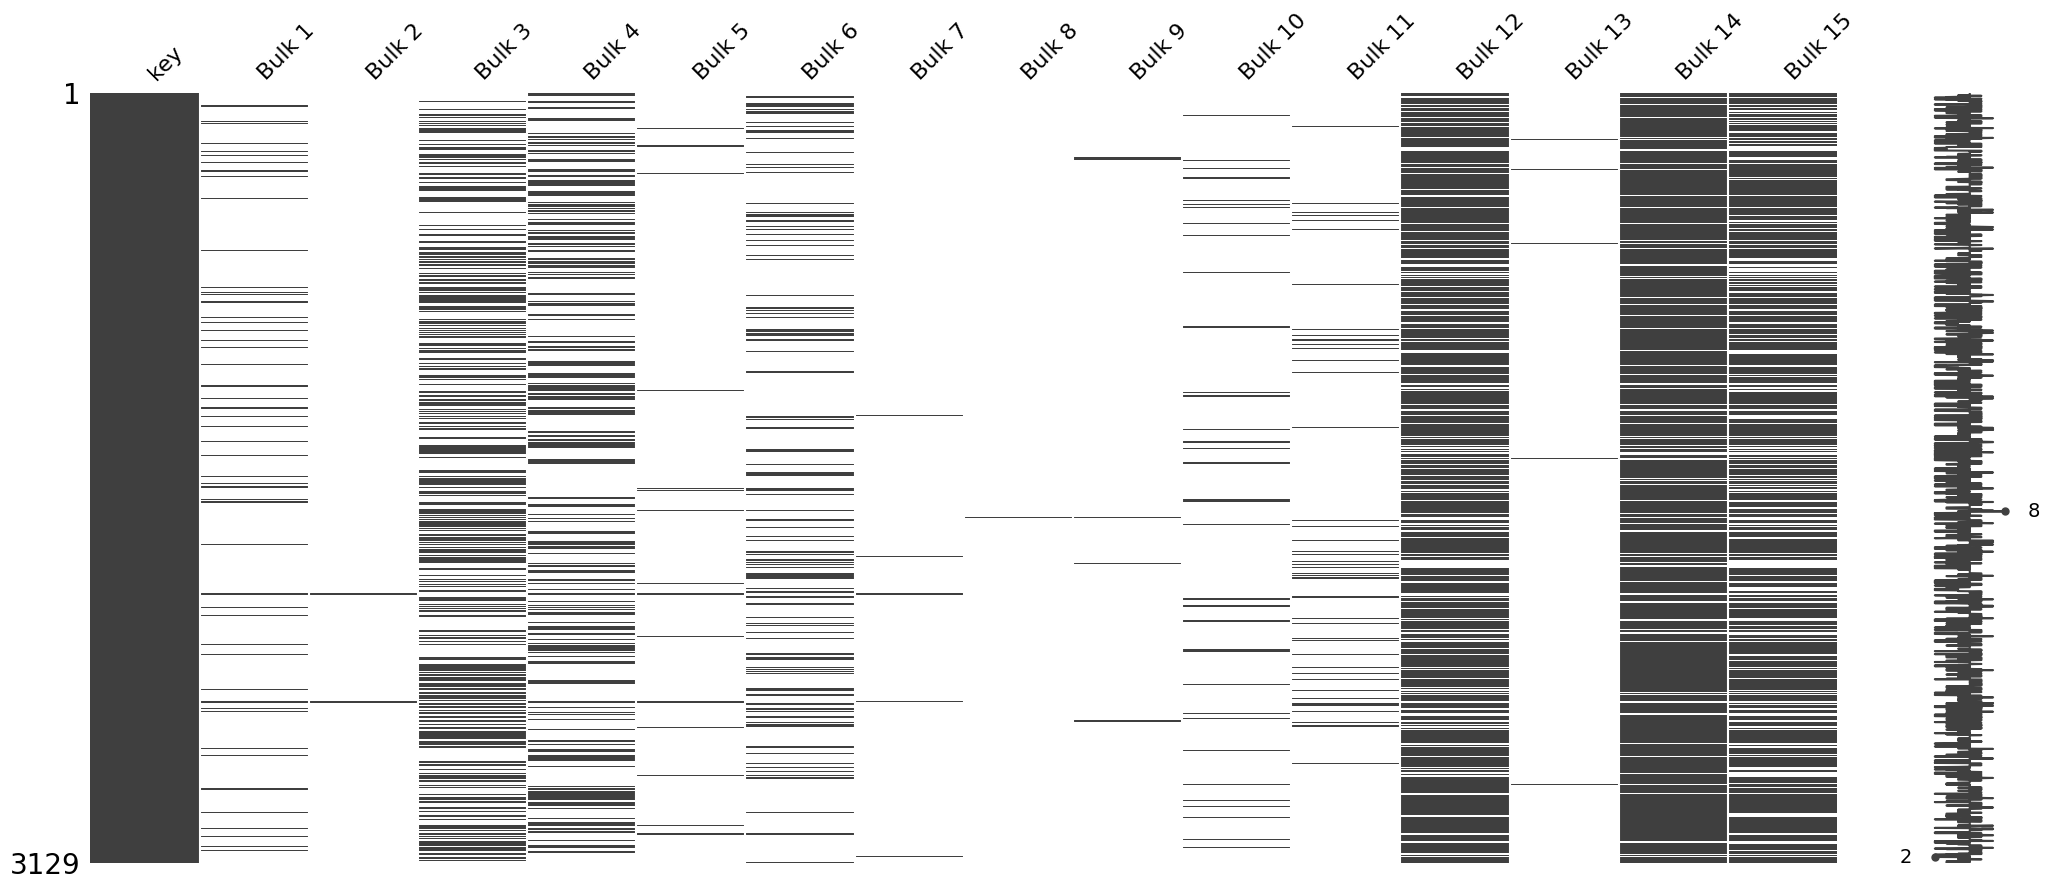

In [506]:
msgn.matrix(df_data_bulk)

In [507]:
df_data_bulk.isna().sum() / df_data_bulk.shape[0] * 100

key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64

Количество пропусков значительно. У девяти из пятнадцати признаков пропущено более 90% значений. У остальных признаков количество пропусков меньше, но так же значительно. Признаков, в которых доля пропущенных значений составила бы менее 10%, в датасете data_bulk нет.


In [508]:
df_data_bulk.duplicated().sum()

0

In [509]:
df_data_bulk.nunique()

key        3129
Bulk 1       47
Bulk 2       15
Bulk 3      278
Bulk 4      206
Bulk 5       55
Bulk 6      205
Bulk 7       25
Bulk 8        1
Bulk 9       10
Bulk 10      77
Bulk 11     101
Bulk 12     331
Bulk 13      14
Bulk 14     284
Bulk 15     156
dtype: int64

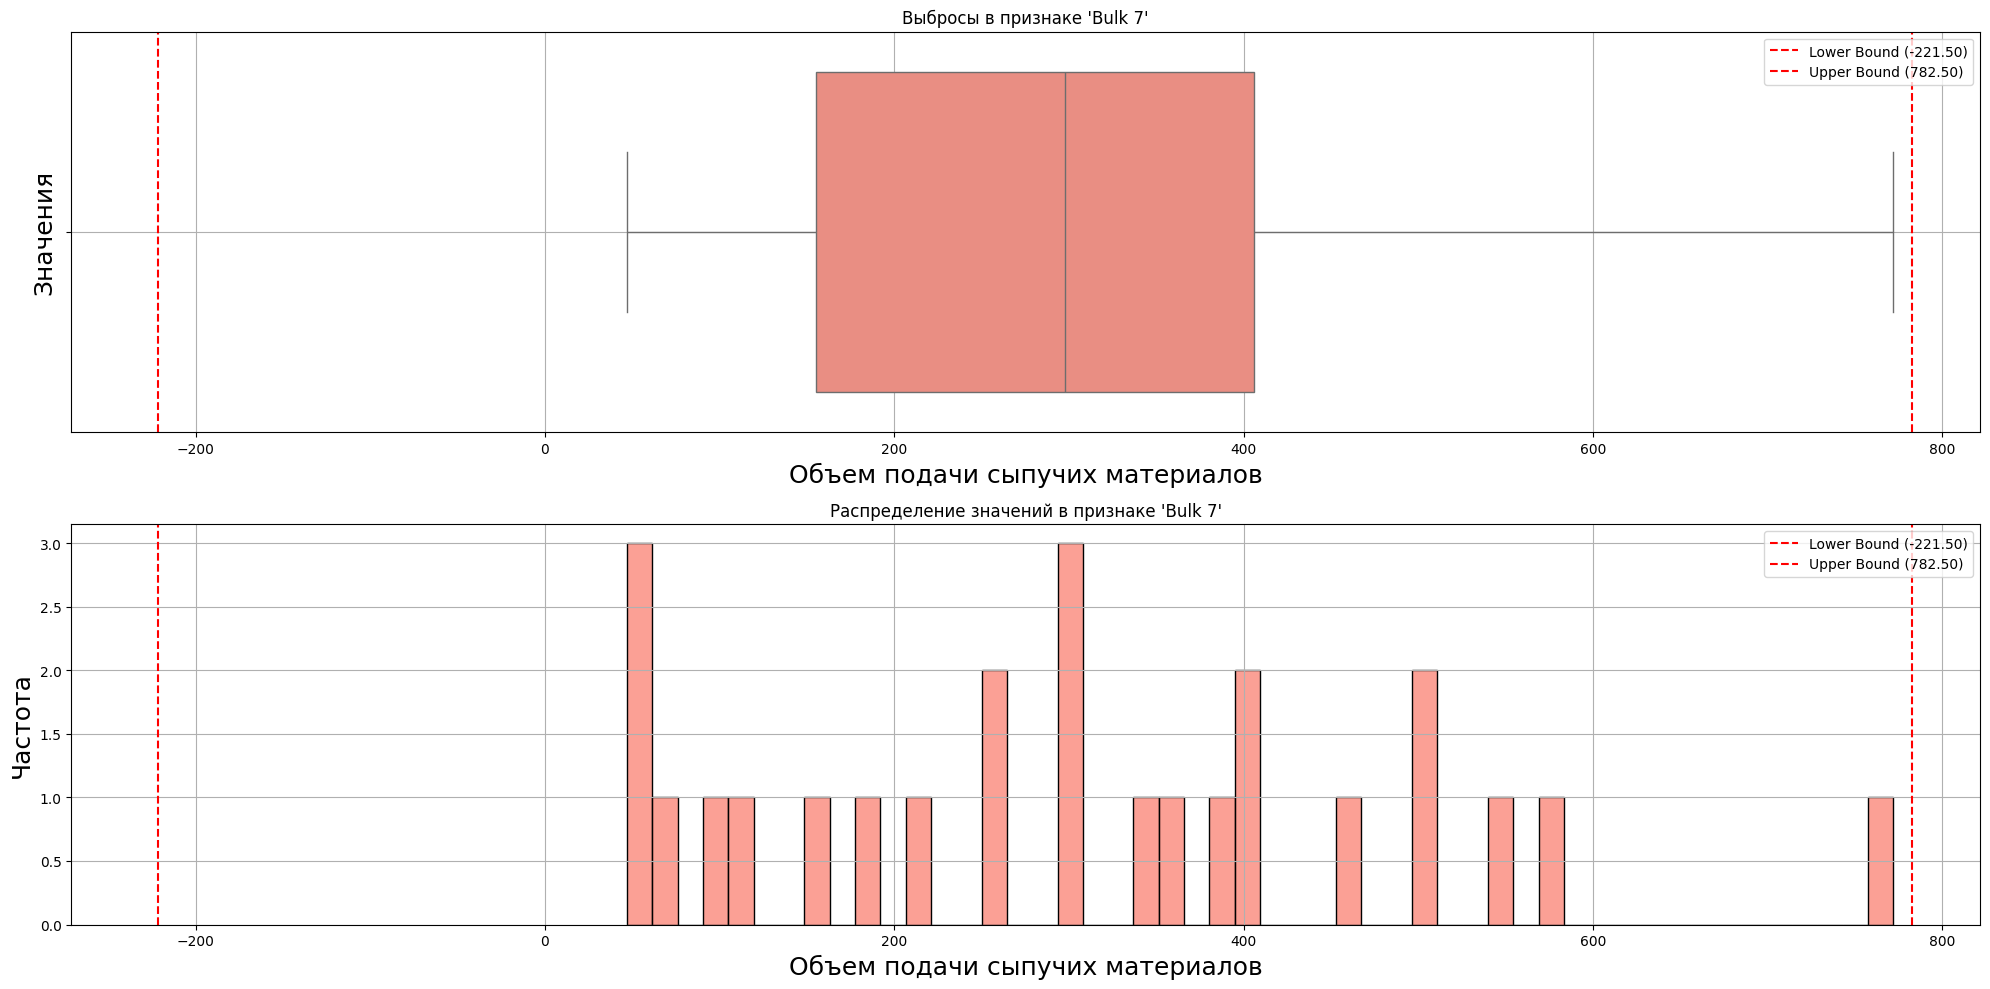

In [510]:
outliers_and_features_distribution(
    df_data_bulk,
    'Bulk 7',
    'Объем подачи сыпучих материалов',
    'salmon')

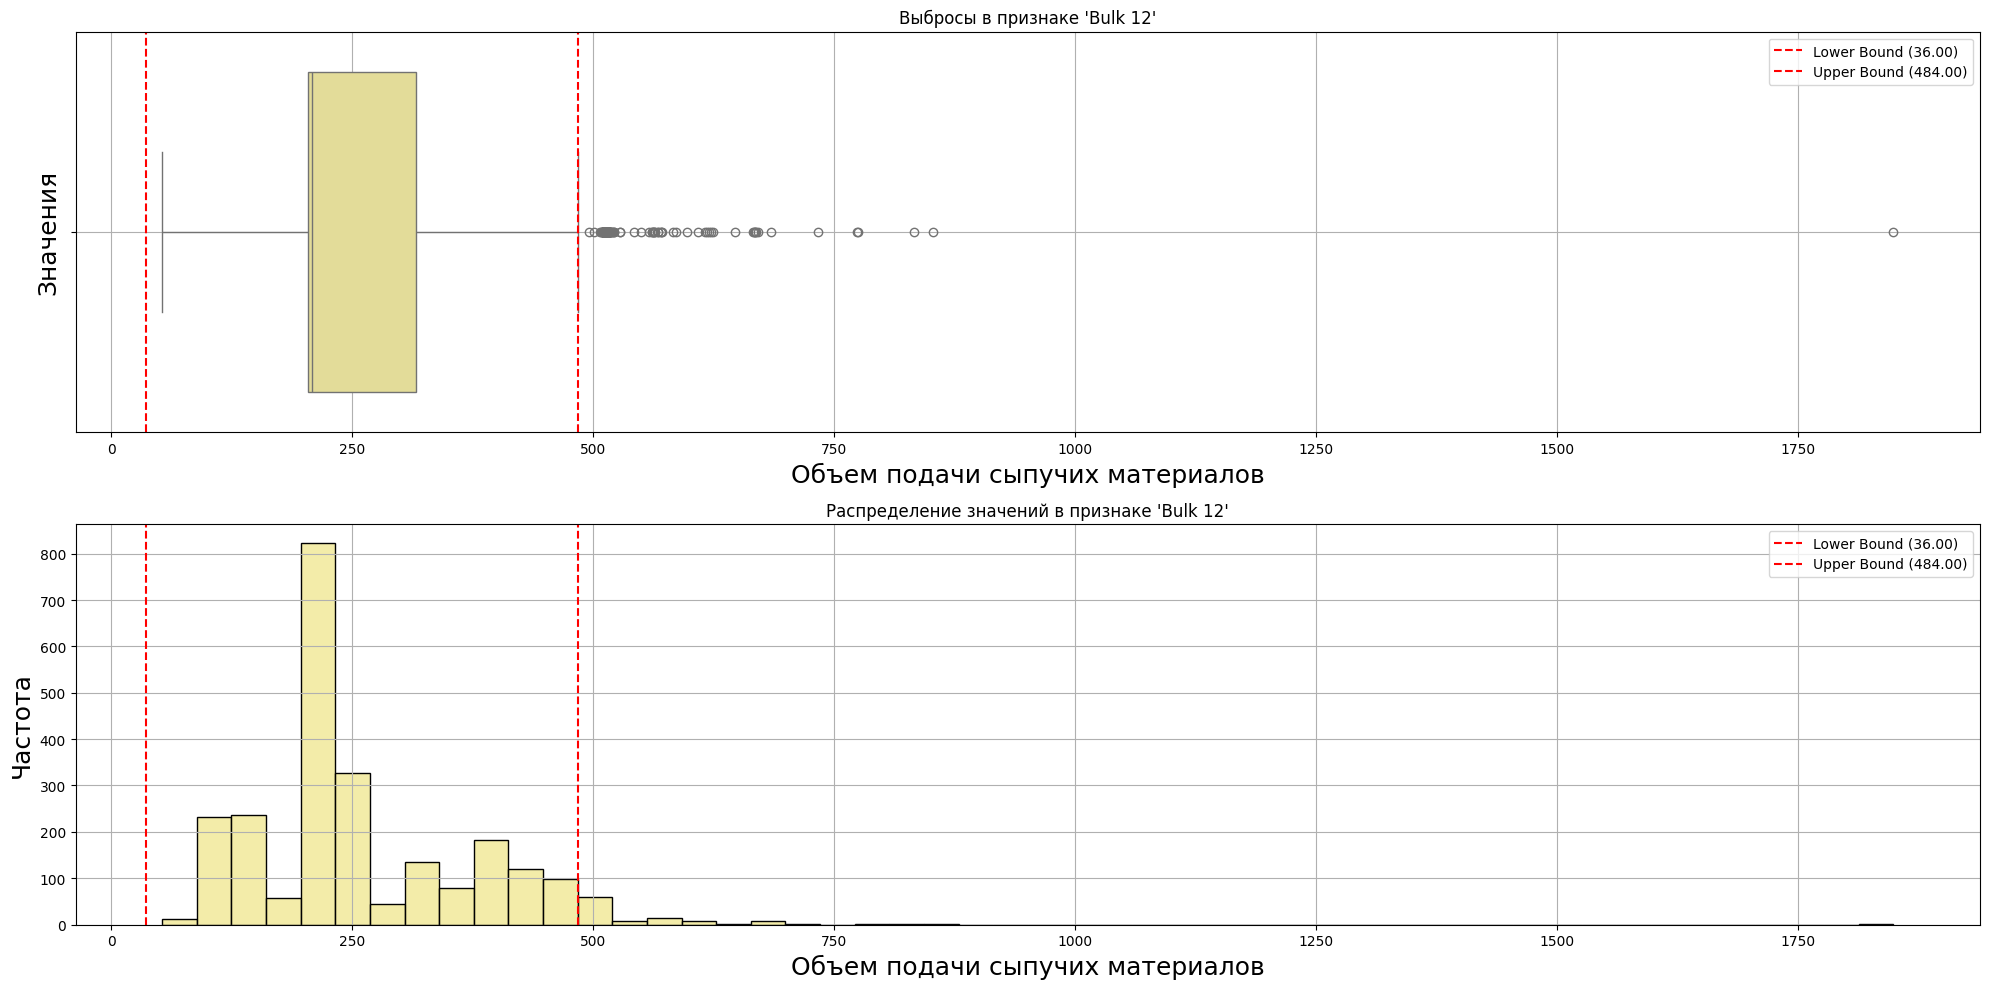

In [511]:
outliers_and_features_distribution(
    df_data_bulk,
    'Bulk 12',
    'Объем подачи сыпучих материалов',
    'khaki')

Для признака 'Bulk 7' 99.2% значений отсутствуют, что делает этот признак непригодным для использования в машинном обучении. Однако в признаке 'Bulk 12' отсутствует лишь 21.7% значений, что делает его пригодным для использования в качестве фактора для прогнозирования. Выброс в признаке 'Bulk 12' не будет обрабатываться, так как он может быть естественным отображением максимальных значений для данного признака.

Пропуски, наблюдаемые в присадках, свидетельствуют о том, что в указанный момент времени присадки в ковш не добавлялись. Следовательно, все пропуски могут быть заполнены нулевыми значениями.

#### **Анализ данных датасета 'data_bulk_time.csv'**

---

In [512]:
df_data_bulk_time.head()

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40  
3  2019-05-03 12:41:24  
4  2019-05-03 13:12:56

In [513]:
df_data_bulk_time.duplicated().sum()

0

In [514]:
df_data_bulk_time.nunique()

key        3129
Bulk 1      252
Bulk 2       22
Bulk 3     1298
Bulk 4     1014
Bulk 5       77
Bulk 6      576
Bulk 7       25
Bulk 8        1
Bulk 9       19
Bulk 10     176
Bulk 11     177
Bulk 12    2450
Bulk 13      18
Bulk 14    2806
Bulk 15    2248
dtype: int64

Явных дубликатов в датасете data_bulk_time нет.

In [515]:
df_data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Тип данных в датасете не соответствует оптимальному для проведения анализа или машинного обучения. В случае, если данные были бы пригодны для использования в машинном обучении, рекомендуется было бы изменить тип данных на datetime для более удобной работы с временными метками. Однако, скорее всего, признаки в датасете содержат избыточное количество пропущенных значений, что делает их непригодными для использования в машинном обучении. В связи с этим, изменение типа данных не является целесообразным.

In [516]:
df_data_bulk_time.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [517]:
round(df_data_bulk_time.isna().sum() / df_data_bulk_time.shape[0] * 100, 2)

key         0.00
Bulk 1     91.95
Bulk 2     99.30
Bulk 3     58.52
Bulk 4     67.59
Bulk 5     97.54
Bulk 6     81.59
Bulk 7     99.20
Bulk 8     99.97
Bulk 9     99.39
Bulk 10    94.38
Bulk 11    94.34
Bulk 12    21.70
Bulk 13    99.42
Bulk 14    10.32
Bulk 15    28.16
dtype: float64

Количество пропущенных значений в датасете data_bulk_time значительно и соответствует количеству пропусков в датасете data_bulk. Поскольку временные метки операций в разных датасетах представлены асинхронно, создание синтетического признака машинного обучения на основе данных из датасета data_bulk_time с привязкой к дате/времени нецелесообразно.

Данные из датасета data_bulk_time не могут быть использованы в контексте машинного обучения.

#### **Анализ данных датасета 'data_gas.csv'**

---

In [518]:
df_data_gas.head()

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

In [519]:
df_data_gas.duplicated().sum()

0

Явных дубликатов в датасете нет.

In [520]:
df_data_gas.nunique()

key      3239
Газ 1    3239
dtype: int64

In [521]:
df_data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Тип данных корректный, изменений не требует.

In [522]:
df_data_gas.describe().T

count         mean         std       min         25%          50%  \
key    3239.0  1621.861377  935.386334  1.000000  812.500000  1622.000000   
Газ 1  3239.0    11.002062    6.220327  0.008399    7.043089     9.836267   

               75%         max  
key    2431.500000  3241.00000  
Газ 1    13.769915    77.99504

In [523]:
df_data_gas.isna().sum().T

key      0
Газ 1    0
dtype: int64

<Axes: >

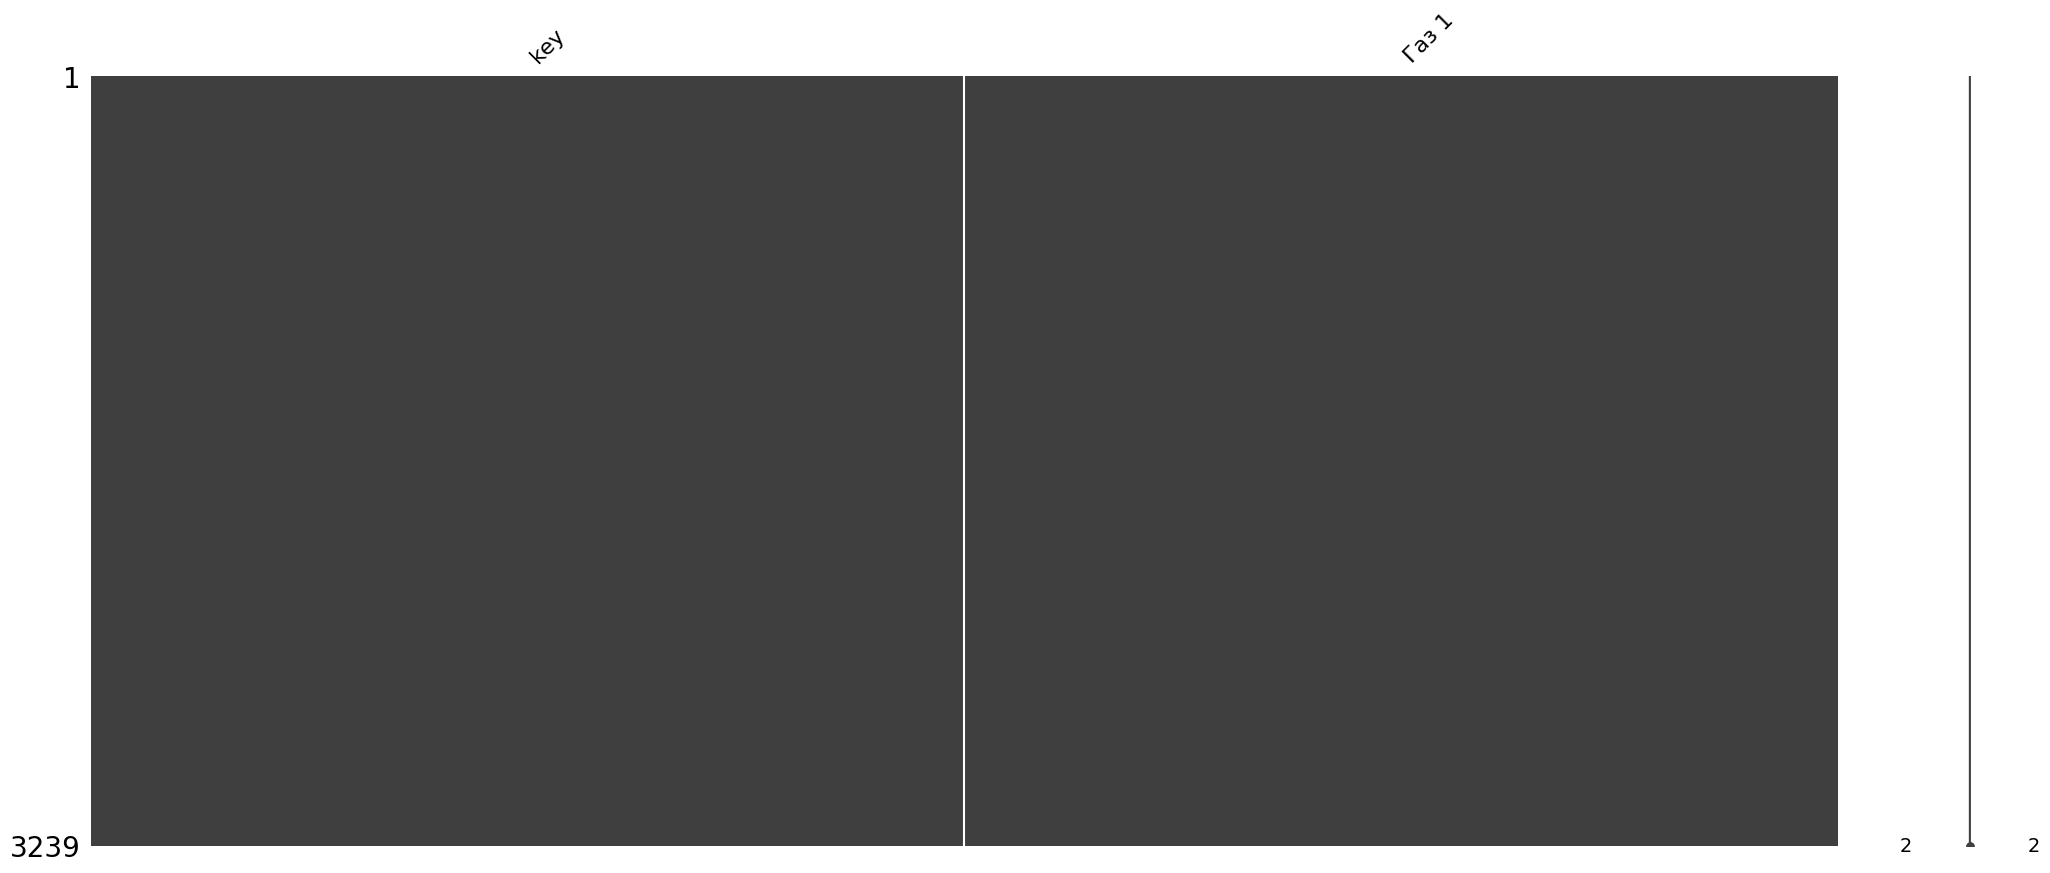

In [524]:
msgn.matrix(df_data_gas)

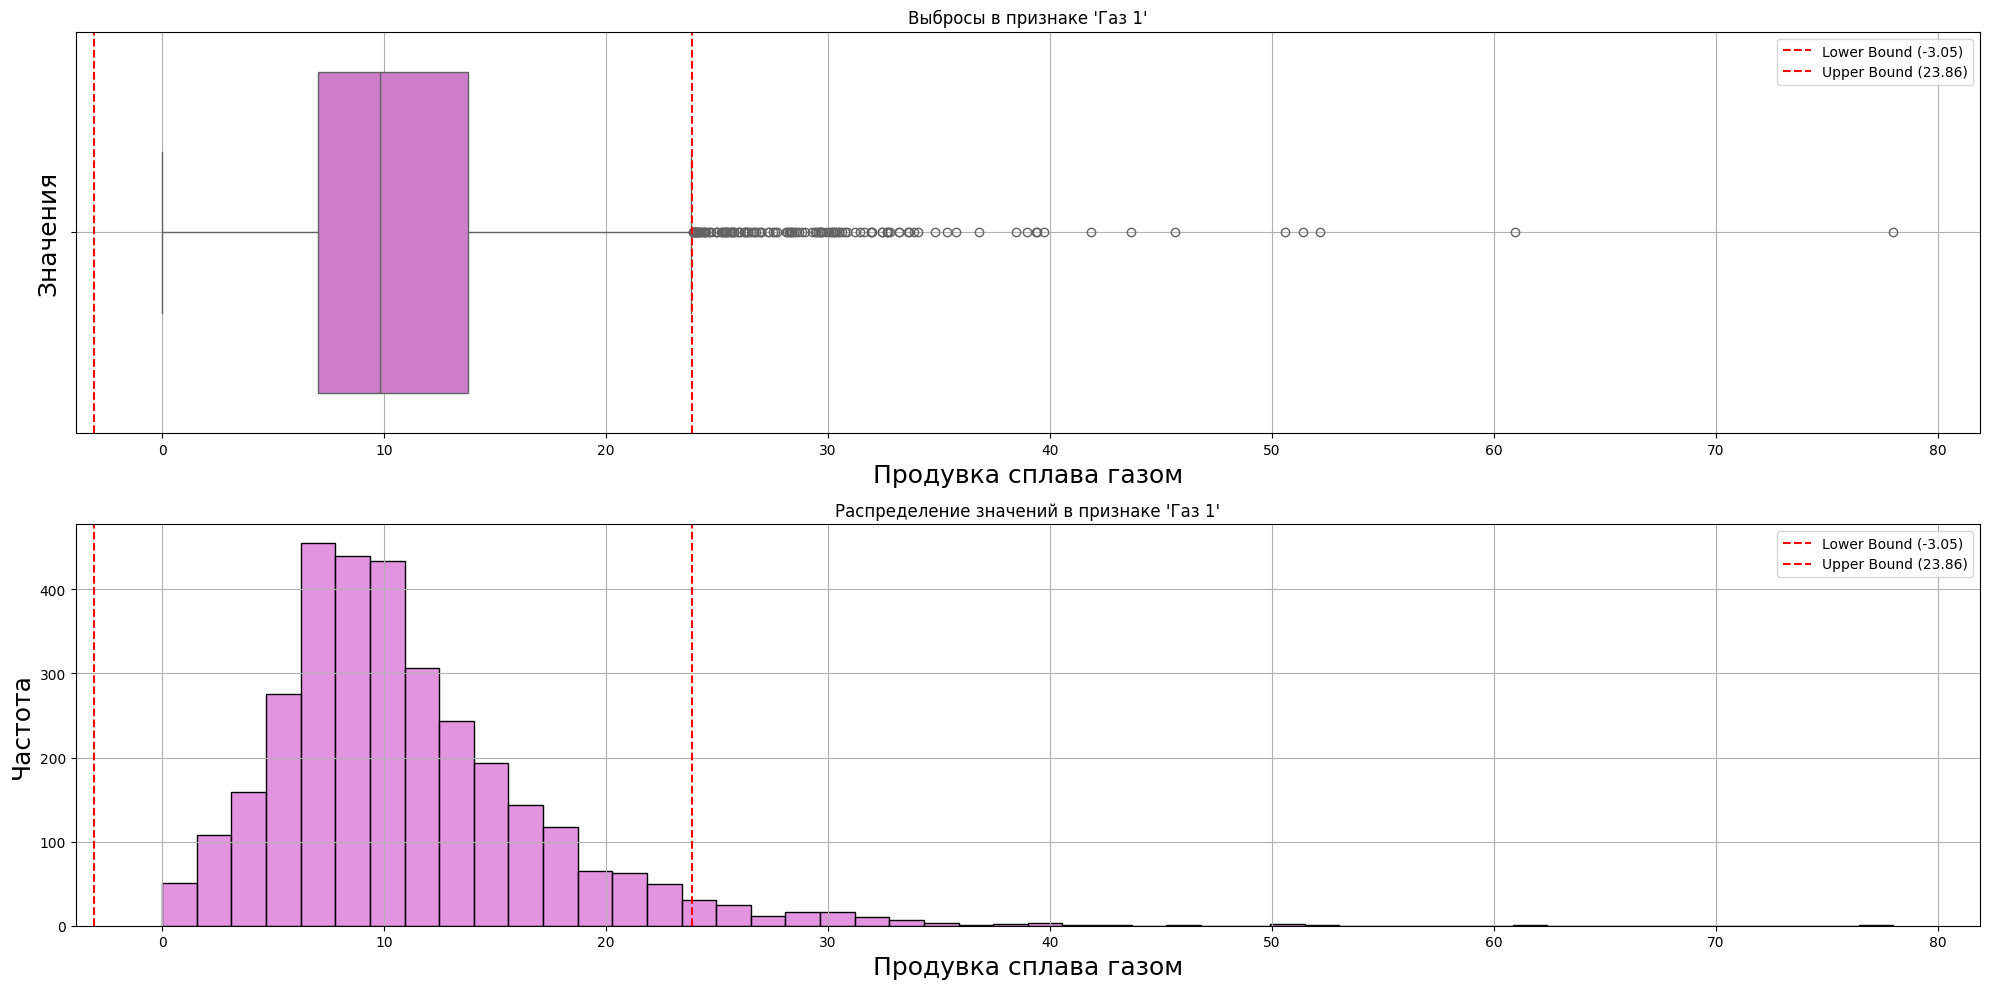

In [525]:
outliers_and_features_distribution(
    df_data_gas,
    'Газ 1',
    'Продувка сплава газом',
    'orchid')

In [526]:
gas_outliers = round((df_data_gas.loc[df_data_gas['Газ 1'] > 23.9].shape[0] / df_data_gas.shape[0]) * 100, 2)
print(f'Доля выбросов в признаке \'Газ 1\': \n {gas_outliers}%')

Доля выбросов в признаке 'Газ 1': 
 3.89%


In [527]:
df_data_gas.loc[df_data_gas['Газ 1'] > 23.9, 'Газ 1'] = np.nan

In [528]:
df_data_gas.isna().sum()

key        0
Газ 1    126
dtype: int64

In [529]:
na_columns = ['Газ 1']
na_columns

['Газ 1']

In [530]:
imputer_data_gas = KNNImputer(
    n_neighbors = 5,
    copy = False
)

In [531]:
df_data_gas[na_columns] = imputer_data_gas.fit_transform(df_data_gas[na_columns])

In [532]:
df_data_gas.isna().sum()

key      0
Газ 1    0
dtype: int64

In [533]:
gas_outliers = round((df_data_gas.loc[df_data_gas['Газ 1'] > 23.9].shape[0] / df_data_gas.shape[0]) * 100, 2)
print(f'Доля выбросов в признаке \'Газ 1\': \n {gas_outliers}%')

Доля выбросов в признаке 'Газ 1': 
 0.0%


Доля значений, классифицируемых как выбросы, составляет менее одного процента от общего объема данных. Тем не менее, диапазон значений не является чрезмерно широким. Возможно, наблюдаемые значения могут отражать особенности технологического процесса, такие как изменения в объеме продуваемой стали или другие факторы, требующие различного количества добавленного газа для отдельных партий. Рекомендуется дополнительное исследование данного вопроса совместно с инженерами соответствующих подразделений комбината.

#### **Анализ данных датасета 'data_temp.csv'**

---

In [534]:
df_data_temp.head()

key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0

In [535]:
df_data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Тип данных столбца (признака) 'Время замера' необходимо изменить с 'object' на 'datetime'.

In [536]:
df_data_temp['Время замера'] = pd.to_datetime(df_data_temp['Время замера'])

In [537]:
df_data_temp.dtypes

key                      int64
Время замера    datetime64[ns]
Температура            float64
dtype: object

Выведем информацию о дате/времени самого раннего и позднего замера температуры и о длительности периода между крайними точками замера.

In [538]:
# выведем самую раннюю дату замера темпреатуры
print('Дата самого раннего замера температуры: \n', df_data_temp['Время замера'].min())

Дата самого раннего замера температуры: 
 2019-05-03 11:16:18


In [539]:
# выведем самую позднюю дату замера температуры
print('Дата самого позднего замера температуры: \n', df_data_temp['Время замера'].max())

Дата самого позднего замера температуры: 
 2019-09-01 04:38:08


In [540]:
# проверим, сколько времени прошло между самым ранним и поздним
# замером температуры
print('Промежуток между самым ранним и поздним замером температуры: \n', df_data_temp['Время замера'].max() - df_data_temp['Время замера'].min())

Промежуток между самым ранним и поздним замером температуры: 
 120 days 17:21:50


In [541]:
df_data_temp.duplicated().sum()

0

Явных дубликатов в датасете нет.

In [542]:
df_data_temp.isna().sum()

key                0
Время замера       0
Температура     2901
dtype: int64

In [543]:
round(df_data_temp.isna().sum() / df_data_temp.shape[0] * 100, 2)

key              0.00
Время замера     0.00
Температура     18.24
dtype: float64

18% значений не заполнены.

In [544]:
df_data_temp.nunique()

key              3216
Время замера    15907
Температура       175
dtype: int64

In [545]:
df_data_temp.describe().T

count                           mean                  min  \
key           15907.0                     1607.88087                  1.0   
Время замера    15907  2019-07-02 09:55:01.000942848  2019-05-03 11:16:18   
Температура   13006.0                     1591.84092               1191.0   

                                     25%                  50%  \
key                                790.0               1618.0   
Время замера  2019-06-01 16:24:51.500000  2019-06-30 10:31:14   
Температура                       1581.0               1591.0   

                              75%                  max         std  
key                        2427.0               3241.0  942.212073  
Время замера  2019-08-03 12:07:59  2019-09-01 04:38:08         NaN  
Температура                1601.0               1705.0   21.375851

Исчерпывающий анализ статистических данных не выявляет существенных аномалий или отклонений. Однако, для получения более детальной картины, мы планируем проанализировать распределение значений в переменной "Температура".

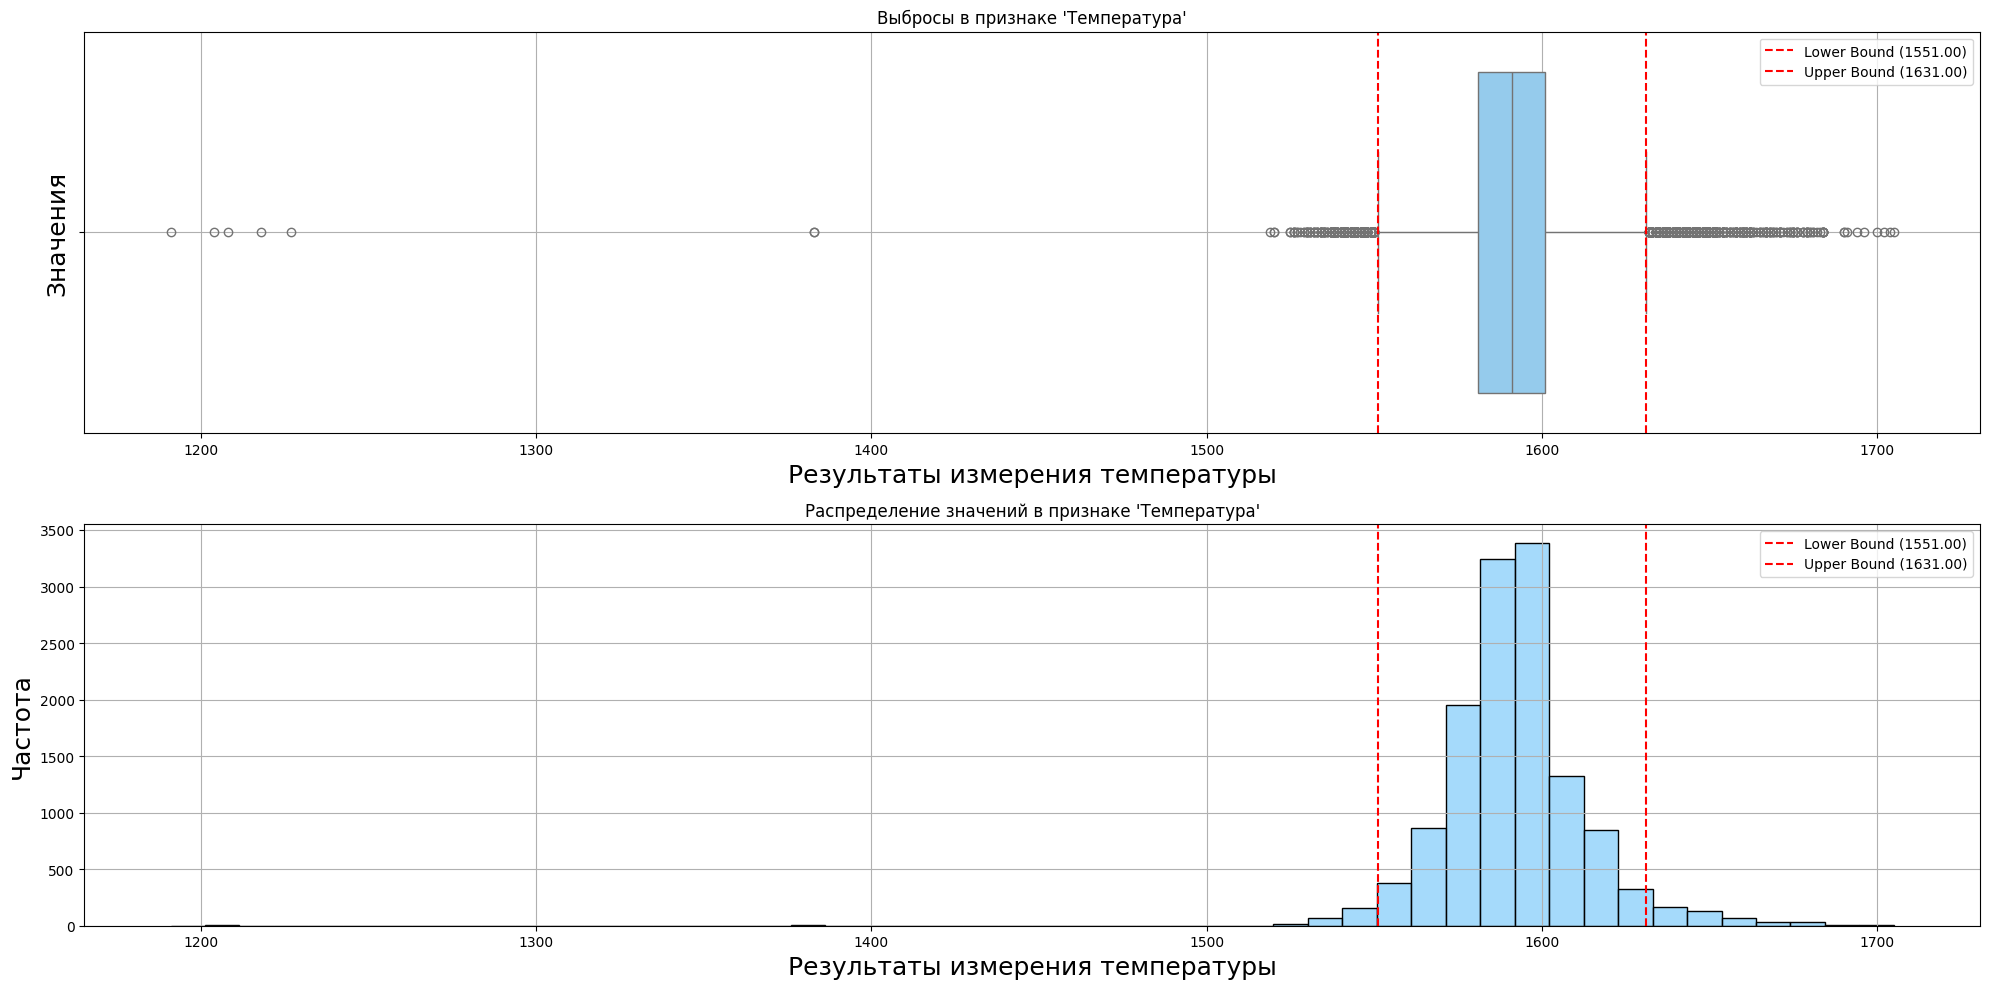

In [546]:
outliers_and_features_distribution(
    df_data_temp,
    'Температура',
    'Результаты измерения температуры',
    'lightskyblue')

В зависимости от конкретного типа стали и технологических процессов, температура плавления металла может изменяться и достигать значений даже ниже 1200 градусов Цельсия. Согласно классификации, <font color='crimson'> используемой в литературе (Туробов, Ш. Н. и др., 2021)</font>, стали обычно делят на три категории: легкоплавкие, среднеплавкие и тугоплавкие. Легкоплавкие стали имеют температуру плавления в районе 600 градусов Цельсия, среднеплавкие – от 600 до 1600 градусов Цельсия, а тугоплавкие – выше 1600 градусов Цельсия.

Согласно данным, производимая на металлургическом комбинате сталь относится к категории среднеплавких. Температура плавления данного сплава составляет 1450 градусов Цельсия. Следовательно, все значения температуры, ниже указанного порога, не представляют интереса для обучения модели, поскольку при таких низких температурах процесс плавления металла не происходит.

На этапе предварительной обработки данных предлагается удалить все записи с температурой ниже 1450 градусов Цельсия. Однако следует отметить, что информация о температуре является ключевой для достижения поставленных целей. Хотя процент пропущенных значений (18%) достаточно высок, он не является критическим. Заполнение пропущенных данных средними значениями, медианой или фиксированными константами может привести к искажению результатов, поэтому более разумным решением будет удаление пропусков на этапе предобработки данных.

#### **Анализ данных датасета 'data_wire.csv'**

---

In [547]:
df_data_wire.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [548]:
df_data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Тип данных столбцов (признаков) корректный, менять его не требуется.

In [549]:
df_data_wire.duplicated().sum()

0

Явных дубликатов в датасете нет.

In [550]:
df_data_wire.describe().T

count         mean         std        min         25%          50%  \
key     3081.0  1623.426485  932.996726   1.000000  823.000000  1619.000000   
Wire 1  3055.0   100.895853   42.012518   1.918800   72.115684   100.158234   
Wire 2  1079.0    50.577323   39.320216   0.030160   20.193680    40.142956   
Wire 3    63.0   189.482681   99.513444   0.144144   95.135044   235.194977   
Wire 4    14.0    57.442841   28.824667  24.148801   40.807002    45.234282   
Wire 5     1.0    15.132000         NaN  15.132000   15.132000    15.132000   
Wire 6    73.0    48.016974   33.919845   0.034320   25.053600    42.076324   
Wire 7    11.0    10.039007    8.610584   0.234208    6.762756     9.017009   
Wire 8    19.0    53.625193   16.881728  45.076721   46.094879    46.279999   
Wire 9    29.0    34.155752   19.931616   4.622800   22.058401    30.066399   

                75%          max  
key     2434.000000  3241.000000  
Wire 1   126.060483   330.314424  
Wire 2    70.227558   282.780152  
Wire 3   276.252014   385.008668  
Wire 4    76.124619   113.231044  
Wire 5    15.132000    15.132000  
Wire 6    64.212723   180.454575  
Wire 7    11.886057    32.847674  
Wire 8    48.089603   102.762401  
Wire 9    43.862003    90.053604

Исходя из ряда признаков, можно предварительно оценить возможное наличие выбросов в данных. Однако, необходимо отметить, что достоверность таких выводов остается сомнительной в связи с тем, что в представленном датасете лишь один из девяти признаков ('Wire 1') содержит незначительное количество пропущенных значений. Во всех остальных признаках отмечается крайне недостаточное количество заполненных данных, что осложняет адекватную оценку возможных выбросов и требует дополнительного анализа для корректного вывода.

In [551]:
round(df_data_wire.isna().sum() / df_data_wire.shape[0] * 100, 2)

key        0.00
Wire 1     0.84
Wire 2    64.98
Wire 3    97.96
Wire 4    99.55
Wire 5    99.97
Wire 6    97.63
Wire 7    99.64
Wire 8    99.38
Wire 9    99.06
dtype: float64

При наличии значительного объема пропущенных данных в датасете 'data_wire', его использование в чистом виде для задач машинного обучения оказывается невозможным. Такая неполнота информации не обеспечивает достаточной основы для адекватного анализа и обучения моделей.

Однако, из этого датасета можно извлечь ценные данные путем создания синтетического признака. Этот признак может быть сформирован путем заполнения пропусков нулевыми значениями и последующим объединением информации из всех признаков от 'Wire 1' до 'Wire 9' путем их суммирования. Полученные суммы могут быть агрегированы по ковшам (партиям). Если такой синтетический признак успешно пройдет проверку на мультиколлинеарность с другими признаками, его можно включить в обучающий датасет для дальнейшего анализа и построения моделей машинного обучения.

Кроме того, в обучающий датасет также могут быть включены признаки 'Wire 1', где пропусков составляют лишь 1% от общего числа записей, и 'Wire 2', где заполнено около 35% значений. Эти признаки, несмотря на недостаточное количество пропусков, могут оказаться полезными для обучения моделей.

#### **Анализ данных датасета 'data_wire_time.csv'**

---

In [552]:
df_data_wire_time.head()

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

In [553]:
df_data_wire_time.nunique()

key       3081
Wire 1    3055
Wire 2    1079
Wire 3      63
Wire 4      14
Wire 5       1
Wire 6      73
Wire 7      11
Wire 8      19
Wire 9      29
dtype: int64

In [554]:
round(df_data_wire_time.isna().sum()/df_data_bulk_time.shape[0] * 100, 2) 

key        0.00
Wire 1     0.83
Wire 2    63.98
Wire 3    96.45
Wire 4    98.02
Wire 5    98.43
Wire 6    96.13
Wire 7    98.11
Wire 8    97.86
Wire 9    97.54
dtype: float64

Анализ количества пропущенных значений в датасете 'data_wire_time' показывает аналогичную картину тому, что наблюдалась в датасете 'data_wire'. Это означает, что информация, содержащаяся в признаках 'data_wire_time', также не может быть использована непосредственно для задач машинного обучения из-за недостаточного объема данных.

Следовательно, создание синтетического признака для машинного обучения на основе информации из 'data_wire_time' является нерациональным. Это обусловлено тем, что дата и время в различных датасетах не синхронизированы, что делает невозможным или неправильным использование временных данных для создания синтетического признака в контексте других признаков.

### **Выводы по п. Анализ данных**

---

1. Для анализа доступны данные за период четырех месяцев, с 3 мая 2019 года по 1 сентября 2019 года.

2. В датасете 'data_arc' были выявлены и обработаны два выброса. Данный датасет содержит два информативных признака - "Активная мощность" и "Реактивная мощность", с указанием времени начала и окончания нагрева дугой. Общее количество наблюдений в датасете составляет 14876.

3. В датасетах 'data_bulk' и 'data_bulk_time' информация о объеме подачи сыпучих материалов представлена с высоким количеством пропущенных значений. В 'data_bulk' из 15 признаков только в двух заполнено более 78% данных, остальные признаки имеют значительное количество пропусков. Аналогичная ситуация наблюдается и в 'data_bulk_time'. Общее количество наблюдений в обоих датасетах составляет 3129.

4. В датасете 'data_gas' представлен информативный признак 'Газ 1' о продувке сплава газом. Общее количество наблюдений в этом датасете составляет 3239.

5. В датасете 'data_temp' содержится целевой признак 'Температура', который требует дополнительного изучения с точки зрения удаления пропусков и выбросов. Общее количество наблюдений в этом датасете составляет 15907.

6. В датасетах 'data_wire' и 'data_wire_time' сведения о объеме используемых проволочных материалов также представлены с высоким количеством пропущенных значений. В обоих датасетах наблюдается схожая картина с пропусками. Общее количество наблюдений в обоих датасетах составляет 3081.

7. После анализа данных предполагается, что наибольшую важность для машинного обучения могут иметь признаки из датасетов 'data_arc', 'data_gas' и 'data_temp'.

8. На основе данных датасетов 'data_bulk' и 'data_wire' планируется создать по одному агрегирующему синтетическому признаку. Пропуски в данных будут заполнены нулями, данные будут просуммированы по каждому наблюдению, а затем проведена группировка значений по ковшам (партиям). Если синтетические признаки успешно пройдут проверку на мультиколлинеарность, они будут использованы для машинного обучения.

9. На основе признаков 'Активная мощность' и 'Реактивная мощность' может быть создан синтетический признак 'Полная мощность'. Однако, вероятно, что этот новый признак будет иметь высокую линейную корреляцию с другими признаками. Решение о его использовании будет принято после проверки на мультиколлинеарность.

### **Предобработка данных. Выделение признаков и целевого признака. Объединение таблиц**

---


In [555]:
# выведем размер датасета и число уникальных партий
# до удаления пропусков
df_data_temp.shape, df_data_temp.key.nunique()

((15907, 3), 3216)

In [556]:
# отфильтруем все наблюдения из датасета data_temp,
# в признаке 'Температура', где есть пропуски
df_data_nan = df_data_temp[df_data_temp['Температура'].isna()]
df_data_nan.shape

(2901, 3)

In [557]:
# выведем число уникальных партий, в которых есть пропуски
# по температуре
df_data_nan.nunique()

key              739
Время замера    2901
Температура        0
dtype: int64

In [558]:
# выведем количество пропусков в датасете data_temp
df_data_temp.isna().sum()

key                0
Время замера       0
Температура     2901
dtype: int64

Проведение операции удаления всех наблюдений, связанных с ковшами (партиями), для которых хотя бы одно значение температуры отсутствует, 

приведет к сокращению общего числа уникальных идентификаторов партий на 739 единиц.


In [559]:
df_data_temp.shape, df_data_temp.key.nunique()

((15907, 3), 3216)

In [560]:
# сформируем список всех уникальных ковшов (партий),
# для которых есть хотя бы один пропуск в признаке 'Температура'
steel_ladle_list = list(df_data_nan.key.unique())
len(steel_ladle_list)

739

In [561]:
# создадим маску, в которой True будет соответствовать
# номеру ковша (партии), которые необходимо удалить из датасета
mask = df_data_temp.key.isin(steel_ladle_list)

# отфильтруем из датасета наблюдения только для тех ковшов (партий),
# для которых заполнены все значения в признаке 'Температура'
df_data_temp = df_data_temp[~mask]

In [562]:
# выведем размер датасета и число уникальных ковшов (партий)
# после удаления пропусков с помощью маски
df_data_temp.shape, df_data_temp.key.nunique()

((12267, 3), 2477)

После проведения удаления пропущенных значений с использованием маски, наблюдается ожидаемое уменьшение общего числа записей на более чем 2901. Сокращение количества уникальных идентификаторов партий составило точно 739, что свидетельствует о корректном удалении записей на основе двух признаков: 'Температура' и 'key'.

In [563]:
# для контроля проверим, есть ли пропуски в датасете data_temp
df_data_temp.isna().sum()

key             0
Время замера    0
Температура     0
dtype: int64

Пропуски успешно удалены.

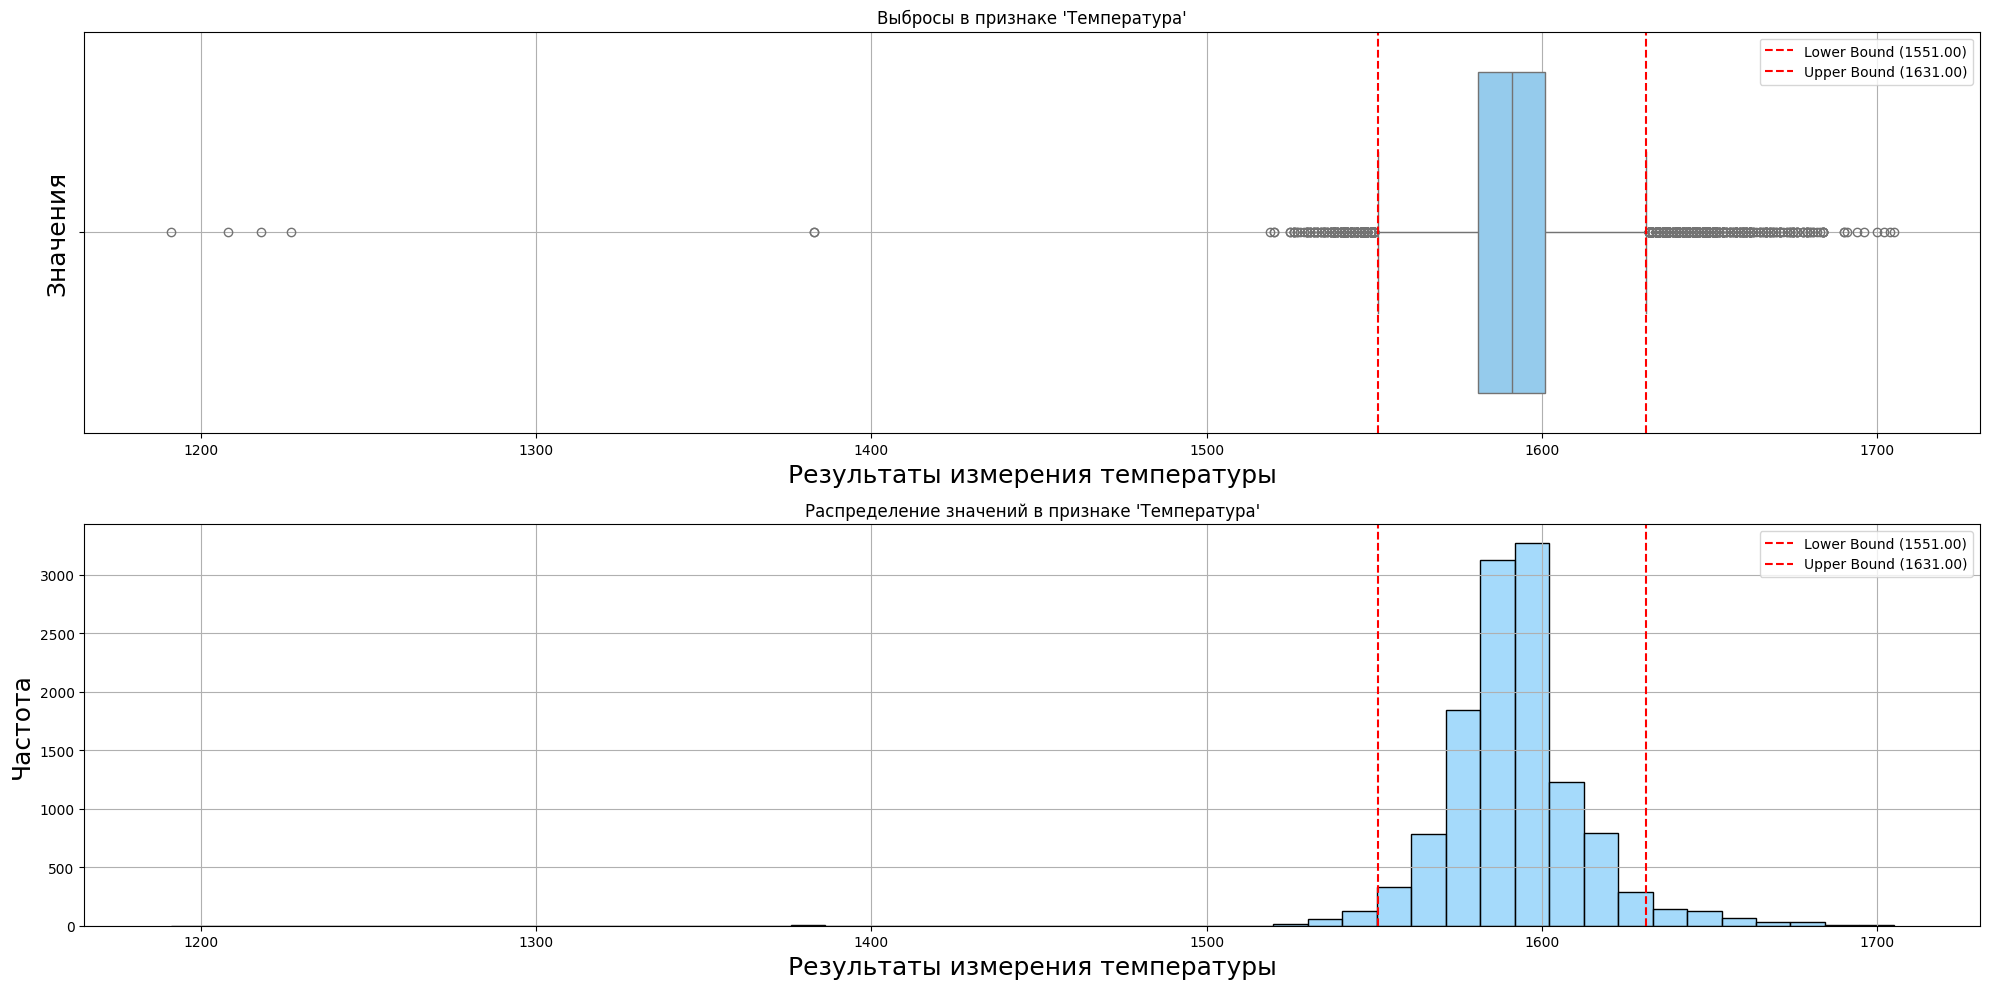

In [564]:
# выведем распределение признака 'Температура'
# до обработки выбросов
outliers_and_features_distribution(
    df_data_temp,
    'Температура',
    'Результаты измерения температуры',
    'lightskyblue')

Как было указано ранее, в соответствии с технической документацией металлургического комбината производится плавка среднеплавких сталей, чья температура плавления находится в пределах диапазона от 1450 градусов Цельсия и выше. В соответствии с этим, все значения температуры ниже порога в 1450 градусов Цельсия считаются выбросами и требуют удаления или обработки.

In [565]:
# вычислим долю значений признака 'Температура',
# являющихся выбросами
temperature_outliers = round((df_data_temp.loc[df_data_temp['Температура'] < 1450].shape[0] / df_data_temp.shape[0]) * 100, 2)

print(f'Доля выбросов в признаке \'Температура\': \n \
{temperature_outliers}%')

Доля выбросов в признаке 'Температура': 
 0.05%


In [566]:
# посчитаем количество выбросов
len(df_data_temp.loc[df_data_temp['Температура'] < 1450])

6

In [567]:
# выведем все значения являющиеся выбросами
df_data_temp.loc[df_data_temp['Температура'] < 1450]

key        Время замера  Температура
4350    867 2019-06-04 14:21:00       1191.0
5978   1214 2019-06-16 05:32:00       1208.0
7958   1619 2019-06-30 11:03:54       1218.0
8913   1818 2019-07-07 00:30:49       1383.0
8914   1818 2019-07-07 00:31:40       1383.0
10127  2052 2019-07-21 14:51:40       1227.0

Объем выбросов ограничен, что обеспечивает возможность проведения ручного анализа каждого из них. В случае если выброс, определенный по признаку 'Температура', соответствует промежуточному значению, предпочтительным подходом будет его удаление, сохраняя при этом информацию о ковше (партии) с начальным и конечным значениями температуры для последующего использования в задачах машинного обучения.

In [568]:
# создадим список из номеров ковшов (партий),
# для которых выявлены выбросы по температуре
temp_outliers = list(
    df_data_temp.loc[df_data_temp['Температура'] < 1450]['key'].unique())
temp_outliers

[867, 1214, 1619, 1818, 2052]

In [569]:
# выведем все значения для 'key' = 867
df_data_temp[df_data_temp.key.isin(temp_outliers)]

key        Время замера  Температура
4350    867 2019-06-04 14:21:00       1191.0
4351    867 2019-06-04 14:29:35       1575.0
4352    867 2019-06-04 14:30:29       1576.0
4353    867 2019-06-04 14:43:10       1571.0
4354    867 2019-06-04 14:52:54       1600.0
4355    867 2019-06-04 14:57:17       1599.0
5978   1214 2019-06-16 05:32:00       1208.0
5979   1214 2019-06-16 05:49:01       1608.0
5980   1214 2019-06-16 05:51:28       1608.0
5981   1214 2019-06-16 05:51:38       1608.0
5982   1214 2019-06-16 05:52:41       1608.0
5983   1214 2019-06-16 05:53:03       1608.0
5984   1214 2019-06-16 05:53:13       1608.0
5985   1214 2019-06-16 05:54:48       1604.0
5986   1214 2019-06-16 05:57:21       1604.0
5987   1214 2019-06-16 06:00:25       1604.0
5988   1214 2019-06-16 06:06:12       1600.0
5989   1214 2019-06-16 06:07:28       1596.0
5990   1214 2019-06-16 06:08:28       1596.0
5991   1214 2019-06-16 06:09:10       1603.0
5992   1214 2019-06-16 06:12:25       1591.0
5993   1214 2019-06-16 06:14:45       1591.0
7958   1619 2019-06-30 11:03:54       1218.0
7959   1619 2019-06-30 11:04:39       1623.0
7960   1619 2019-06-30 11:10:01       1611.0
7961   1619 2019-06-30 11:16:03       1603.0
7962   1619 2019-06-30 11:21:54       1590.0
8907   1818 2019-07-07 00:00:14       1627.0
8908   1818 2019-07-07 00:13:02       1650.0
8909   1818 2019-07-07 00:25:28       1650.0
8910   1818 2019-07-07 00:26:03       1650.0
8911   1818 2019-07-07 00:26:42       1650.0
8912   1818 2019-07-07 00:27:23       1663.0
8913   1818 2019-07-07 00:30:49       1383.0
8914   1818 2019-07-07 00:31:40       1383.0
8915   1818 2019-07-07 00:32:55       1680.0
8916   1818 2019-07-07 00:36:11       1667.0
8917   1818 2019-07-07 00:36:45       1667.0
8918   1818 2019-07-07 00:38:50       1671.0
10127  2052 2019-07-21 14:51:40       1227.0
10128  2052 2019-07-21 14:52:21       1592.0
10129  2052 2019-07-21 15:06:31       1590.0
10130  2052 2019-07-21 15:15:24       1591.0
10131  2052 2019-07-21 15:24:06       1592.0

Два выброса, выявленные для ковша (партии) с идентификатором 1818 (строки 8913 и 8914), представляют собой промежуточные измерения, которые могут быть удалены. При этом значения начальной и конечной температуры для данного ковша (партии) должны быть сохранены для последующего анализа и использования в машинном обучении.

Для остальных ковшей (партий) с номерами 867, 1214, 1619 и 2052 выбросами являются начальные значения температуры. В таких случаях рекомендуется удалить все наблюдения, относящиеся к соответствующим сериям значений для каждого ковша (партии).

In [570]:
# выведем размер датасета и число уникальных значений 'key'
# до удаления двух строк с индексами 8913, 8914
df_data_temp.shape, df_data_temp.key.nunique()

((12267, 3), 2477)

In [571]:
# создаем список индексов строк, которые необходимо удалить
index_to_remove = [8913, 8914]

# удаляем строки с индексами 8913, 8914
df_data_temp.drop(index_to_remove, axis = 0, inplace = True)

In [572]:
# выведем размер датасета и число уникальных значений 'key'
# после удаления двух строк с индексами 8913, 8914
df_data_temp.shape, df_data_temp.key.nunique()

((12265, 3), 2477)

Успешное выполнение удаления выбросов отражается на изменении количества уникальных значений ковшей (партий). В данном случае, уменьшение числа уникальных значений на 4 единицы свидетельствует о корректности удаления.

Для проверки эффективности процесса удаления выбросов и получения общего представления о распределении значений температуры в датасете 'data_temp' можно вывести соответствующее распределение значений данного признака.

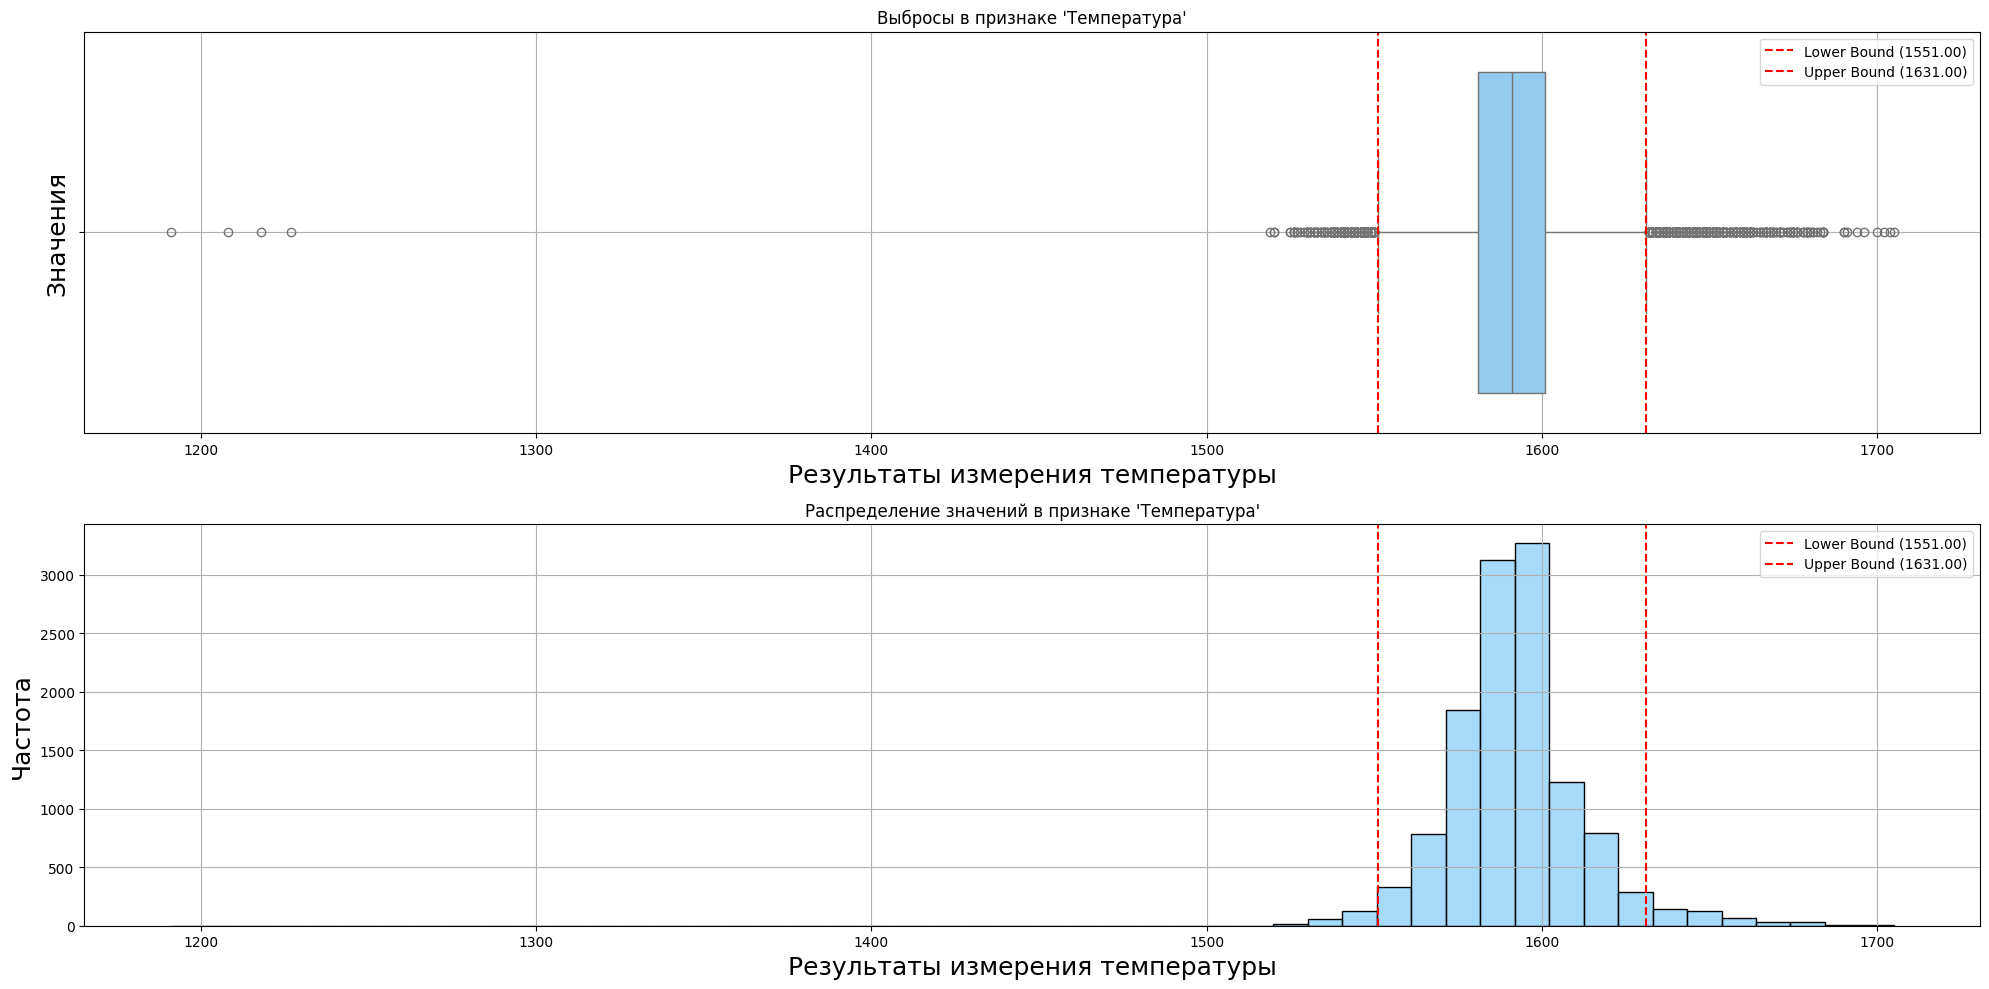

In [573]:
# выведем распределение признака 'Температура'
# после удаления выбросов
outliers_and_features_distribution(
    df_data_temp,
    'Температура',
    'Результаты измерения температуры',
    'lightskyblue')

In [574]:
df_data_temp.dtypes

key                      int64
Время замера    datetime64[ns]
Температура            float64
dtype: object

In [575]:
max_temp = pd.DataFrame(df_data_temp.groupby('key',as_index = False).agg({"Время замера": max}))

In [576]:
max_temp.head()

key        Время замера
0    1 2019-05-03 11:30:39
1    2 2019-05-03 11:59:12
2    3 2019-05-03 12:34:57
3    4 2019-05-03 12:59:25
4    5 2019-05-03 13:36:01

In [577]:
max_temp.nunique()

key             2477
Время замера    2477
dtype: int64

In [578]:
df_data_temp.nunique()

key              2477
Время замера    12265
Температура       173
dtype: int64

Для удостоверения правильности выбора времени последней операции в рамках каждого ковша (партии) в сгруппированном датасете 'max_temp', мы предлагаем создать дополнительный датасет, в котором для каждого ковша (партии) время измерения температуры будет упорядочено по возрастанию.

In [579]:
# создадим временный датасет, который необходим для контроля
# правильности агрегации и создания объединенного датасета
# с обучающими признаками

temp = pd.DataFrame(df_data_temp.groupby(['key', 'Температура', 'Время замера'], as_index = False).agg({'Время замера': max}).sort_values(by = ['key', 'Время замера']))
temp.head()

key  Температура        Время замера
0    1       1571.0 2019-05-03 11:16:18
2    1       1604.0 2019-05-03 11:25:53
4    1       1618.0 2019-05-03 11:29:11
1    1       1601.0 2019-05-03 11:30:01
3    1       1613.0 2019-05-03 11:30:39

Замечаем, что отсутствие сброса индексов reset_index(drop=True) в датасете 'temp' позволяет нам проанализировать, что для первых двух ковшей (партий) последнее время не всегда совпадает с максимальной температурой. Первоначально может показаться, что наиболее простым способом получения конечной и начальной температуры для каждой партии является группировка по ключу ('key') и применение функций max() и min() к признаку 'Температура'. Однако, мы продемонстрировали, что такой подход приводит к возникновению значительных искажений в датасете.

Для получения целевого признака присоединим к таблице max_temp датасет data_temp по общим значениям 'Время замера': как мы убедились выше, в датасете max_temp в признаке 'Время замера' все значения уникальны.

In [580]:
data = max_temp.merge(df_data_temp, how='inner', on = 'Время замера')

data.drop(['key_x', 'Время замера'], axis = 1, inplace = True)

data.columns = ['key', 'Конечная температура']

In [581]:
data.head()

key  Конечная температура
0    1                1613.0
1    2                1602.0
2    3                1599.0
3    4                1625.0
4    5                1602.0

In [582]:
data.nunique()

key                     2477
Конечная температура     106
dtype: int64

Следующий признак, который будет создан на основе датасета data_temp: 'Начальная температура'. Этот признак является обучающим.

In [583]:
min_temp = pd.DataFrame(df_data_temp.groupby(
    'key', as_index = False).agg({'Время замера': min}))

min_temp.head()

key        Время замера
0    1 2019-05-03 11:16:18
1    2 2019-05-03 11:37:27
2    3 2019-05-03 12:13:17
3    4 2019-05-03 12:52:57
4    5 2019-05-03 13:23:19

Объединим датасеты  min_temp и data_temp по общему признаку 'Время замера'.

In [584]:
# объединяем датасеты
data_2 = min_temp.merge(df_data_temp, how = 'inner', on = 'Время замера')

# удалим из датасета data лишние столбцы
data_2.drop(['key_x', 'Время замера'], axis = 1, inplace = True)

# откорректируем заголовки столбцов
data_2.columns = ['key', 'Начальная температура']

In [585]:
data_2.head()

key  Начальная температура
0    1                 1571.0
1    2                 1581.0
2    3                 1596.0
3    4                 1601.0
4    5                 1576.0

Контрольная сверка датасета data_2 и датасета temp показывает, что выделение признака 'Начальная температура' проведено корректно.

In [586]:
# для контроля выведем количество уникальных значений
# датасета data_2
data_2.nunique()

key                      2477
Начальная температура     145
dtype: int64

Объединим датасеты data и data_2 по общему признаку 'key'.

In [587]:
data = data.merge(data_2,how='inner',on = 'key')

In [588]:
data.head()

key  Конечная температура  Начальная температура
0    1                1613.0                 1571.0
1    2                1602.0                 1581.0
2    3                1599.0                 1596.0
3    4                1625.0                 1601.0
4    5                1602.0                 1576.0

In [589]:
# проверим, есть ли ковши (партии),
# по которым конечная и начальная температуры совпадают
len(data[data['Конечная температура'] == data['Начальная температура']])

44

Ковши (партии), по которым начальная и конечная температуры совпадают, есть, но их не много.

На основе данных датасета data_temp создадим синтетический признак из разности конечного и начального времени замера температуры.

In [590]:
# с помощью группировки получим информацию по самому раннему
# и позднему времени замера температуры по каждому ковшу (партии)
temp_measurement_time = df_data_temp.groupby('key')['Время замера'].agg(['first', 'last']).reset_index()

# выведем первые пять строк датасета
temp_measurement_time.head()

key               first                last
0    1 2019-05-03 11:16:18 2019-05-03 11:30:39
1    2 2019-05-03 11:37:27 2019-05-03 11:59:12
2    3 2019-05-03 12:13:17 2019-05-03 12:34:57
3    4 2019-05-03 12:52:57 2019-05-03 12:59:25
4    5 2019-05-03 13:23:19 2019-05-03 13:36:01

In [591]:
# проверим, что у столбцов с ранним и поздним временем замера температуры
# тип данных datetime64
temp_measurement_time.dtypes

key               int64
first    datetime64[ns]
last     datetime64[ns]
dtype: object

In [592]:
# создадим новый синтетический признак
temp_measurement_time['temp_time_diff'] = (temp_measurement_time['last'] - temp_measurement_time['first'])

# переведем разницу времени между замерами в секунды
temp_measurement_time['temp_time_diff'] = temp_measurement_time['temp_time_diff'].dt.total_seconds()

In [593]:
# выведем первые пять строк датасета
temp_measurement_time.head()

key               first                last  temp_time_diff
0    1 2019-05-03 11:16:18 2019-05-03 11:30:39           861.0
1    2 2019-05-03 11:37:27 2019-05-03 11:59:12          1305.0
2    3 2019-05-03 12:13:17 2019-05-03 12:34:57          1300.0
3    4 2019-05-03 12:52:57 2019-05-03 12:59:25           388.0
4    5 2019-05-03 13:23:19 2019-05-03 13:36:01           762.0

In [594]:
# удалим из датасета temp_measurement_time ненужные столбцы
temp_measurement_time = temp_measurement_time.drop(['first', 'last'], axis = 1)

In [595]:
temp_measurement_time.head()

key  temp_time_diff
0    1           861.0
1    2          1305.0
2    3          1300.0
3    4           388.0
4    5           762.0

In [596]:
temp_measurement_time.dtypes

key                 int64
temp_time_diff    float64
dtype: object

In [597]:
# перед объединением выведем размеры и число уникальных
# значений объединяемых датасетов
data.shape, data['key'].nunique()

((2477, 3), 2477)

In [598]:
temp_measurement_time.shape, temp_measurement_time['key'].nunique()

((2477, 2), 2477)

In [599]:
# объединим датасеты data и temp_measurement_time
# по общему ключу 'key'
data = data.merge(temp_measurement_time,
                  how = 'inner',
                  on = 'key')

In [600]:
data.head()

key  Конечная температура  Начальная температура  temp_time_diff
0    1                1613.0                 1571.0           861.0
1    2                1602.0                 1581.0          1305.0
2    3                1599.0                 1596.0          1300.0
3    4                1625.0                 1601.0           388.0
4    5                1602.0                 1576.0           762.0

In [601]:
data.nunique()

key                      2477
Конечная температура      106
Начальная температура     145
temp_time_diff           1646
dtype: int64

Следующий датасет для создания признаков: **data_arc**.

In [602]:
# сгруппируем признаки 'Активная мощность' и
# 'Реактивная мощность' по ковшу (партии)
power = pd.DataFrame(df_data_arc.groupby('key', as_index = False).agg(
    {'Активная мощность': sum,
     'Реактивная мощность': sum,
     'Начало нагрева дугой': 'first',
     'Конец нагрева дугой': 'last'})
)

# выведем первые пять строк сгруппированной таблицы
power.head()

key  Активная мощность  Реактивная мощность Начало нагрева дугой  \
0    1           4.878147             3.183241  2019-05-03 11:02:14   
1    2           3.052598             1.998112  2019-05-03 11:34:14   
2    3           2.525882             1.599076  2019-05-03 12:06:54   
3    4           3.209250             2.060298  2019-05-03 12:39:37   
4    5           3.347173             2.252643  2019-05-03 13:11:13   

  Конец нагрева дугой  
0 2019-05-03 11:28:37  
1 2019-05-03 11:53:18  
2 2019-05-03 12:32:19  
3 2019-05-03 12:57:50  
4 2019-05-03 13:33:55

Временные метки начала и окончания нагрева дугой, представленные в датасете 'data_arc', не совпадают с временными метками первого и последнего измерения температуры в датасете 'data_temp'. В связи с этим возможно создание дополнительного синтетического признака, основанного на разнице между временем окончания и временем начала нагрева дугой.

In [603]:
power.dtypes

key                              int64
Активная мощность              float64
Реактивная мощность            float64
Начало нагрева дугой    datetime64[ns]
Конец нагрева дугой     datetime64[ns]
dtype: object

In [604]:
# создадим новый синтетический признак
power['time_power'] = (power['Конец нагрева дугой'] - power['Начало нагрева дугой'])

# переведем разницу времени между замерами в секунды
power['time_power'] = power['time_power'].dt.total_seconds()

# выведем первые пять строк датасета
power.head()

key  Активная мощность  Реактивная мощность Начало нагрева дугой  \
0    1           4.878147             3.183241  2019-05-03 11:02:14   
1    2           3.052598             1.998112  2019-05-03 11:34:14   
2    3           2.525882             1.599076  2019-05-03 12:06:54   
3    4           3.209250             2.060298  2019-05-03 12:39:37   
4    5           3.347173             2.252643  2019-05-03 13:11:13   

  Конец нагрева дугой  time_power  
0 2019-05-03 11:28:37      1583.0  
1 2019-05-03 11:53:18      1144.0  
2 2019-05-03 12:32:19      1525.0  
3 2019-05-03 12:57:50      1093.0  
4 2019-05-03 13:33:55      1362.0

In [605]:
# удалим из датасета power ненужные столбцы
power = power.drop(['Начало нагрева дугой','Конец нагрева дугой'], axis = 1)

In [606]:
# для контроля выведем первые пять строк датасета
power.head()

key  Активная мощность  Реактивная мощность  time_power
0    1           4.878147             3.183241      1583.0
1    2           3.052598             1.998112      1144.0
2    3           2.525882             1.599076      1525.0
3    4           3.209250             2.060298      1093.0
4    5           3.347173             2.252643      1362.0

In [607]:
# проверим количество уникальных значений в датасете power
power.nunique()

key                    3214
Активная мощность      3214
Реактивная мощность    3214
time_power             1933
dtype: int64

Все уникальные значения признака 'key' из датасета data_arc сохранены.

Для более детального анализа создадим синтетический признак **'Полная мощность'**. Полная мощность представляет собой векторное отношение активной и реактивной мощности. Геометрически, вектор полной мощности **S** соединяет концы векторов активной мощности **P** и реактивной мощности  **Q**.


\begin{aligned}
  &P \text{ - активная мощность} \\
  &Q \text{ - реактивная мощность} \\
  &S \text{ - полная мощность}
\end{aligned}

Согласно техническим данным, полная мощность может быть вычислена по следующей формуле:

$$
S = \sqrt{P^2 + Q^2}
$$

Данное выражение позволяет получить полную мощность на основе известной активной и реактивной мощности.

*Источник: [Что такое активная, реактивная и полная мощность - простое объяснение // Сам электрик](https://samelectrik.ru/chto-takoe-aktivnaya-reaktivnaya-i-polnaya-moshhnost.html)*

In [608]:
# создадим в датасете power синтетический признак
# 'Полная мощность'
power['Полная мощность'] = (power['Активная мощность'] ** 2 + power['Реактивная мощность'] ** 2) ** 0.5

In [609]:
power.head()

key  Активная мощность  Реактивная мощность  time_power  Полная мощность
0    1           4.878147             3.183241      1583.0         5.824889
1    2           3.052598             1.998112      1144.0         3.648398
2    3           2.525882             1.599076      1525.0         2.989502
3    4           3.209250             2.060298      1093.0         3.813674
4    5           3.347173             2.252643      1362.0         4.034596

In [610]:
data.nunique(), power.nunique()

(key                      2477
 Конечная температура      106
 Начальная температура     145
 temp_time_diff           1646
 dtype: int64,
 key                    3214
 Активная мощность      3214
 Реактивная мощность    3214
 time_power             1933
 Полная мощность        3214
 dtype: int64)

In [611]:
data = data.merge(power, how = 'inner', on = 'key')

In [612]:
data.head()

key  Конечная температура  Начальная температура  temp_time_diff  \
0    1                1613.0                 1571.0           861.0   
1    2                1602.0                 1581.0          1305.0   
2    3                1599.0                 1596.0          1300.0   
3    4                1625.0                 1601.0           388.0   
4    5                1602.0                 1576.0           762.0   

   Активная мощность  Реактивная мощность  time_power  Полная мощность  
0           4.878147             3.183241      1583.0         5.824889  
1           3.052598             1.998112      1144.0         3.648398  
2           2.525882             1.599076      1525.0         2.989502  
3           3.209250             2.060298      1093.0         3.813674  
4           3.347173             2.252643      1362.0         4.034596

In [613]:
data.nunique()

key                      2475
Конечная температура      106
Начальная температура     145
temp_time_diff           1645
Активная мощность        2475
Реактивная мощность      2475
time_power               1646
Полная мощность          2475
dtype: int64

Выделим обучающий признак из датасета **data_gas**.

In [614]:
df_data_gas.shape, df_data_gas.nunique()

((3239, 2),
 key      3239
 Газ 1    3114
 dtype: int64)

В ходе первоначального анализа данных было установлено, что в датасете 'data_gas' отсутствуют пропуски и дубликаты. Количество уникальных значений признака 'key' свидетельствует о том, что датасет содержит агрегированные сведения о расходе газа для каждого ковша (партии). Следовательно, датасет 'data_gas' не требует дополнительной корректировки и может быть объединен с основным датасетом 'data' по общему признаку 'key'.

In [615]:
# объединим датасеты data и data_gas
data = data.merge(df_data_gas, how = 'inner', on = 'key')

In [616]:
data.head()

key  Конечная температура  Начальная температура  temp_time_diff  \
0    1                1613.0                 1571.0           861.0   
1    2                1602.0                 1581.0          1305.0   
2    3                1599.0                 1596.0          1300.0   
3    4                1625.0                 1601.0           388.0   
4    5                1602.0                 1576.0           762.0   

   Активная мощность  Реактивная мощность  time_power  Полная мощность  \
0           4.878147             3.183241      1583.0         5.824889   
1           3.052598             1.998112      1144.0         3.648398   
2           2.525882             1.599076      1525.0         2.989502   
3           3.209250             2.060298      1093.0         3.813674   
4           3.347173             2.252643      1362.0         4.034596   

       Газ 1  
0  10.229950  
1  12.555561  
2  10.229950  
3  18.841219  
4   5.413692

In [617]:
data.nunique()

key                      2473
Конечная температура      106
Начальная температура     145
temp_time_diff           1645
Активная мощность        2473
Реактивная мощность      2473
time_power               1645
Полная мощность          2473
Газ 1                    2368
dtype: int64

Из датасета **data_bulk** будет подготовлен синтетический признак. На этапе предварительного анализа было установлено, что датасет содержит 15 признаков для каждого ковша (партии), причем значительная часть этих признаков имеет пропущенные значения. Для создания нового признака пропущенные значения будут заменены нулевыми, после чего значения всех пятнадцати признаков будут агрегированы по каждому ковшу (партии).

In [618]:
df_data_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [619]:
# выведем информацию о пропущенных значениях в датасете data_bulk
# до заполнения пропусков

pd.DataFrame(df_data_bulk.isna().mean().sort_values(ascending = False)).reset_index()

index         0
0    Bulk 8  0.999680
1   Bulk 13  0.994247
2    Bulk 9  0.993928
3    Bulk 2  0.992969
4    Bulk 7  0.992010
5    Bulk 5  0.975391
6   Bulk 10  0.943752
7   Bulk 11  0.943432
8    Bulk 1  0.919463
9    Bulk 6  0.815916
10   Bulk 4  0.675935
11   Bulk 3  0.585171
12  Bulk 15  0.281560
13  Bulk 12  0.217002
14  Bulk 14  0.103228
15      key  0.000000

In [620]:
# заполняем пропущенные значения
df_data_bulk.fillna(value = 0, inplace = True)

In [621]:
# выведем информацию о пропущенных значениях в датасете data_bulk
# после заполнения пропусков
pd.DataFrame(df_data_bulk.isna().mean().sort_values(ascending = False)).reset_index()

index    0
0       key  0.0
1    Bulk 1  0.0
2    Bulk 2  0.0
3    Bulk 3  0.0
4    Bulk 4  0.0
5    Bulk 5  0.0
6    Bulk 6  0.0
7    Bulk 7  0.0
8    Bulk 8  0.0
9    Bulk 9  0.0
10  Bulk 10  0.0
11  Bulk 11  0.0
12  Bulk 12  0.0
13  Bulk 13  0.0
14  Bulk 14  0.0
15  Bulk 15  0.0

In [622]:
df_data_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0  
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0  
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0  
3     0.0      0.0      0.0    207.0      0.0    153.0    154.0  
4     0.0      0.0      0.0    203.0      0.0    151.0    152.0

In [623]:
df_data_bulk['Сыпучие материалы'] = df_data_bulk.loc[:,"Bulk 1":"Bulk 15"].sum(axis = 1)

In [624]:
df_data_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  \
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0   
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0   
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0   
3     0.0      0.0      0.0    207.0      0.0    153.0    154.0   
4     0.0      0.0      0.0    203.0      0.0    151.0    152.0   

   Сыпучие материалы  
0              553.0  
1              582.0  
2              544.0  
3              595.0  
4              584.0

In [625]:
# отфильтруем из датасета data_bulk только необходимые признаки
# 'key' и 'Сыпучие материалы'
bulk_feature = df_data_bulk[['key',
                          'Сыпучие материалы',
                          'Bulk 3',
                          'Bulk 4',
                          'Bulk 12',
                          'Bulk 14',
                          'Bulk 15']]

In [626]:
bulk_feature.head()

key  Сыпучие материалы  Bulk 3  Bulk 4  Bulk 12  Bulk 14  Bulk 15
0    1              553.0     0.0    43.0    206.0    150.0    154.0
1    2              582.0     0.0    73.0    206.0    149.0    154.0
2    3              544.0     0.0    34.0    205.0    152.0    153.0
3    4              595.0     0.0    81.0    207.0    153.0    154.0
4    5              584.0     0.0    78.0    203.0    151.0    152.0

In [627]:
bulk_feature.isna().sum()

key                  0
Сыпучие материалы    0
Bulk 3               0
Bulk 4               0
Bulk 12              0
Bulk 14              0
Bulk 15              0
dtype: int64

In [628]:
bulk_feature.nunique()

key                  3129
Сыпучие материалы    1018
Bulk 3                279
Bulk 4                207
Bulk 12               332
Bulk 14               285
Bulk 15               157
dtype: int64

Препятствий для объединения датасетов data и bulk_feature нет.

In [629]:
# объединим датасеты data и bulk_feature
data = data.merge(bulk_feature, how = 'inner', on = 'key')

In [630]:
# выведем первые пять строк объединенного датасета data
data.head()

key  Конечная температура  Начальная температура  temp_time_diff  \
0    1                1613.0                 1571.0           861.0   
1    2                1602.0                 1581.0          1305.0   
2    3                1599.0                 1596.0          1300.0   
3    4                1625.0                 1601.0           388.0   
4    5                1602.0                 1576.0           762.0   

   Активная мощность  Реактивная мощность  time_power  Полная мощность  \
0           4.878147             3.183241      1583.0         5.824889   
1           3.052598             1.998112      1144.0         3.648398   
2           2.525882             1.599076      1525.0         2.989502   
3           3.209250             2.060298      1093.0         3.813674   
4           3.347173             2.252643      1362.0         4.034596   

       Газ 1  Сыпучие материалы  Bulk 3  Bulk 4  Bulk 12  Bulk 14  Bulk 15  
0  10.229950              553.0     0.0    43.0    206.0    150.0    154.0  
1  12.555561              582.0     0.0    73.0    206.0    149.0    154.0  
2  10.229950              544.0     0.0    34.0    205.0    152.0    153.0  
3  18.841219              595.0     0.0    81.0    207.0    153.0    154.0  
4   5.413692              584.0     0.0    78.0    203.0    151.0    152.0

In [631]:
# выведем число уникальных значений датасета data
data.nunique()

key                      2405
Конечная температура      100
Начальная температура     144
temp_time_diff           1614
Активная мощность        2405
Реактивная мощность      2405
time_power               1613
Полная мощность          2405
Газ 1                    2300
Сыпучие материалы         972
Bulk 3                    265
Bulk 4                    199
Bulk 12                   305
Bulk 14                   260
Bulk 15                   143
dtype: int64

Следующим датасетом, на основе которого будет создан обучающий синтетический признак, является **data_wire**. Поскольку данный датасет имеет схожую структуру с датасетом **data_bulk**, новый синтетический признак "Проволочные материалы" будет сформирован по аналогичной методике. Пропущенные значения в признаках будут заменены нулями, после чего агрегированные значения по всем признакам будут объединены для каждого ковша (партии).

In [632]:
df_data_wire.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [633]:
pd.DataFrame(df_data_wire.isna().mean().sort_values(ascending= False)).reset_index()

index         0
0  Wire 5  0.999675
1  Wire 7  0.996430
2  Wire 4  0.995456
3  Wire 8  0.993833
4  Wire 9  0.990587
5  Wire 3  0.979552
6  Wire 6  0.976306
7  Wire 2  0.649789
8  Wire 1  0.008439
9     key  0.000000

In [634]:
df_data_wire.fillna(value = 0,inplace = True)

In [635]:
pd.DataFrame(df_data_wire.isna().mean().sort_values(ascending= False)).reset_index()

index    0
0     key  0.0
1  Wire 1  0.0
2  Wire 2  0.0
3  Wire 3  0.0
4  Wire 4  0.0
5  Wire 5  0.0
6  Wire 6  0.0
7  Wire 7  0.0
8  Wire 8  0.0
9  Wire 9  0.0

In [636]:
df_data_wire.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
1    2  96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    3  91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    4  89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    5  89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

   Wire 9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

In [637]:
df_data_wire['Проволочные материалы'] = df_data_wire.loc[:,'Wire 1':'Wire 9'].sum(axis =1)

In [638]:
df_data_wire.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
1    2  96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    3  91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    4  89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    5  89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

   Wire 9  Проволочные материалы  
0     0.0              60.059998  
1     0.0              96.052315  
2     0.0              91.160157  
3     0.0              89.063515  
4     0.0              98.352796

In [639]:
wire_feature = df_data_wire[['key',
                          'Проволочные материалы',
                          'Wire 1',
                          'Wire 2']]

In [640]:
wire_feature.head()

key  Проволочные материалы     Wire 1   Wire 2
0    1              60.059998  60.059998  0.00000
1    2              96.052315  96.052315  0.00000
2    3              91.160157  91.160157  0.00000
3    4              89.063515  89.063515  0.00000
4    5              98.352796  89.238236  9.11456

In [641]:
wire_feature.isna().sum()

key                      0
Проволочные материалы    0
Wire 1                   0
Wire 2                   0
dtype: int64

Датасеты data и wire_feature могут быть объединены по общему признаку 'key', при этом число уникальных значений ковшов (партий) будет не более 3081.

In [642]:
data = data.merge(wire_feature, how = 'inner', on = 'key')

In [643]:
data.head()

key  Конечная температура  Начальная температура  temp_time_diff  \
0    1                1613.0                 1571.0           861.0   
1    2                1602.0                 1581.0          1305.0   
2    3                1599.0                 1596.0          1300.0   
3    4                1625.0                 1601.0           388.0   
4    5                1602.0                 1576.0           762.0   

   Активная мощность  Реактивная мощность  time_power  Полная мощность  \
0           4.878147             3.183241      1583.0         5.824889   
1           3.052598             1.998112      1144.0         3.648398   
2           2.525882             1.599076      1525.0         2.989502   
3           3.209250             2.060298      1093.0         3.813674   
4           3.347173             2.252643      1362.0         4.034596   

       Газ 1  Сыпучие материалы  Bulk 3  Bulk 4  Bulk 12  Bulk 14  Bulk 15  \
0  10.229950              553.0     0.0    43.0    206.0    150.0    154.0   
1  12.555561              582.0     0.0    73.0    206.0    149.0    154.0   
2  10.229950              544.0     0.0    34.0    205.0    152.0    153.0   
3  18.841219              595.0     0.0    81.0    207.0    153.0    154.0   
4   5.413692              584.0     0.0    78.0    203.0    151.0    152.0   

   Проволочные материалы     Wire 1   Wire 2  
0              60.059998  60.059998  0.00000  
1              96.052315  96.052315  0.00000  
2              91.160157  91.160157  0.00000  
3              89.063515  89.063515  0.00000  
4              98.352796  89.238236  9.11456

In [644]:
data.nunique()

key                      2329
Конечная температура       75
Начальная температура     137
temp_time_diff           1583
Активная мощность        2329
Реактивная мощность      2329
time_power               1588
Полная мощность          2329
Газ 1                    2224
Сыпучие материалы         964
Bulk 3                    265
Bulk 4                    199
Bulk 12                   303
Bulk 14                   254
Bulk 15                   143
Проволочные материалы    2080
Wire 1                   1812
Wire 2                    563
dtype: int64

На основе датасетов **data_bulk_time** и **data_wire_time** может быть создано по одному синтетическому признаку.

В ходе общего анализа данных было установлено, что в обоих датасетах значения большинства признаков пропущены. Однако в каждом из датасетов присутствует один признак, в котором данные заполнены относительно полно:

- В датасете **data_wire_time** в признаке 'Wire 1' заполнено 99.15% значений.
- В датасете **data_bulk_time** в признаке 'Bulk 14' заполнено 89.68% значений.

Каждый из этих признаков содержит информацию о дате и времени события. Для создания синтетического признака предлагается перевести временные метки в формат UNIX time. В результате каждое значение даты и времени будет преобразовано в количество секунд, что позволит использовать этот числовой признак для обучения модели.

Существует высокая вероятность наличия высокой линейной корреляции между признаками. Поэтому, после проведения проверки на мультиколлинеарность будет принято решение о целесообразности включения обоих признаков в модель или удаления одного из них.


In [645]:
df_data_bulk_time.shape, df_data_bulk_time.shape

((3129, 16), (3129, 16))

In [646]:
# отфильтруем из датасетов признаки 'Wire 1' и 'Bulk 14'
wire_1 = df_data_wire_time[['key', 'Wire 1']].copy()
bulk_14 = df_data_bulk_time[['key', 'Bulk 14']].copy()

wire_1.shape, bulk_14.shape

((3081, 2), (3129, 2))

In [647]:
# объединим датасеты  wire_1 и bulk_14
unix_time_features = wire_1.merge(bulk_14,
                                  how = 'inner',
                                  on = 'key')


unix_time_features.shape

(3025, 3)

In [648]:
unix_time_features.isna().sum()

key          0
Wire 1      25
Bulk 14    314
dtype: int64

In [649]:
unix_time_features.isna().sum() / data.shape[0]

key        0.000000
Wire 1     0.010734
Bulk 14    0.134822
dtype: float64

С учетом технологических особенностей, заполнение пропущенных значений методом ближайших соседей будет некорректным, поскольку отсутствие значения указывает на то, что операция для ковша (партии) не выполнялась. Поэтому пропущенные значения будут заменены на нулевые.

In [650]:
unix_time_features.fillna(value = 0, inplace = True)

In [651]:
unix_time_features.isna().sum()

key        0
Wire 1     0
Bulk 14    0
dtype: int64

In [652]:
unix_time_features.dtypes

key         int64
Wire 1     object
Bulk 14    object
dtype: object

In [653]:
unix_time_features.head()

key               Wire 1              Bulk 14
0    1  2019-05-03 11:11:41  2019-05-03 11:03:52
1    2  2019-05-03 11:46:10  2019-05-03 11:40:20
2    3  2019-05-03 12:13:47  2019-05-03 12:09:40
3    4  2019-05-03 12:48:05  2019-05-03 12:41:24
4    5  2019-05-03 13:18:15  2019-05-03 13:12:56

In [654]:

# Изменяем тип данных для столбца 'Wire 1'
unix_time_features['Wire 1'] = unix_time_features['Wire 1'].replace("0", pd.NaT)
unix_time_features['Wire 1'] = pd.to_datetime(unix_time_features['Wire 1'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Изменяем тип данных для столбца 'Bulk 14'
unix_time_features['Bulk 14'] = unix_time_features['Bulk 14'].replace("0", pd.NaT)
unix_time_features['Bulk 14'] = pd.to_datetime(unix_time_features['Bulk 14'], format='%Y-%m-%d %H:%M:%S', errors='coerce')


In [655]:
unix_time_features.dtypes

key                 int64
Wire 1     datetime64[ns]
Bulk 14    datetime64[ns]
dtype: object

In [656]:
# преобразуем дату/время в секунды (UNIX time);
# чтобы избавиться от наносекунд, разделим
# полученыне значения на 10 ** 9
unix_time_features['wire_unix_time'] = (pd.to_datetime(unix_time_features['Wire 1'], unit = 's', origin = 'unix').astype('int64') / 10 ** 9).astype('int64')

unix_time_features['bulk_unix_time'] = (pd.to_datetime(unix_time_features['Bulk 14'], unit = 's',origin = 'unix').astype('int64') / 10 ** 9).astype('int64')

In [657]:
unix_time_features.head()

key              Wire 1             Bulk 14  wire_unix_time  bulk_unix_time
0    1 2019-05-03 11:11:41 2019-05-03 11:03:52      1556881901      1556881432
1    2 2019-05-03 11:46:10 2019-05-03 11:40:20      1556883970      1556883620
2    3 2019-05-03 12:13:47 2019-05-03 12:09:40      1556885627      1556885380
3    4 2019-05-03 12:48:05 2019-05-03 12:41:24      1556887685      1556887284
4    5 2019-05-03 13:18:15 2019-05-03 13:12:56      1556889495      1556889176

In [658]:
unix_time_features.dtypes

key                        int64
Wire 1            datetime64[ns]
Bulk 14           datetime64[ns]
wire_unix_time             int64
bulk_unix_time             int64
dtype: object

In [659]:
unix_time_features.drop(['Wire 1','Bulk 14'], axis=1, inplace= True)

In [660]:
unix_time_features.head()

key  wire_unix_time  bulk_unix_time
0    1      1556881901      1556881432
1    2      1556883970      1556883620
2    3      1556885627      1556885380
3    4      1556887685      1556887284
4    5      1556889495      1556889176

In [661]:
data.shape, unix_time_features.shape

((2329, 18), (3025, 3))

In [662]:
data = data.merge(unix_time_features,how = 'inner',on = 'key')

In [663]:
data.shape

(2329, 20)

In [664]:
data.head()

key  Конечная температура  Начальная температура  temp_time_diff  \
0    1                1613.0                 1571.0           861.0   
1    2                1602.0                 1581.0          1305.0   
2    3                1599.0                 1596.0          1300.0   
3    4                1625.0                 1601.0           388.0   
4    5                1602.0                 1576.0           762.0   

   Активная мощность  Реактивная мощность  time_power  Полная мощность  \
0           4.878147             3.183241      1583.0         5.824889   
1           3.052598             1.998112      1144.0         3.648398   
2           2.525882             1.599076      1525.0         2.989502   
3           3.209250             2.060298      1093.0         3.813674   
4           3.347173             2.252643      1362.0         4.034596   

       Газ 1  Сыпучие материалы  Bulk 3  Bulk 4  Bulk 12  Bulk 14  Bulk 15  \
0  10.229950              553.0     0.0    43.0    206.0    150.0    154.0   
1  12.555561              582.0     0.0    73.0    206.0    149.0    154.0   
2  10.229950              544.0     0.0    34.0    205.0    152.0    153.0   
3  18.841219              595.0     0.0    81.0    207.0    153.0    154.0   
4   5.413692              584.0     0.0    78.0    203.0    151.0    152.0   

   Проволочные материалы     Wire 1   Wire 2  wire_unix_time  bulk_unix_time  
0              60.059998  60.059998  0.00000      1556881901      1556881432  
1              96.052315  96.052315  0.00000      1556883970      1556883620  
2              91.160157  91.160157  0.00000      1556885627      1556885380  
3              89.063515  89.063515  0.00000      1556887685      1556887284  
4              98.352796  89.238236  9.11456      1556889495      1556889176

Напомним, что в признаках 'wire_unix_time' и 'bulk_unix_time' исходных данных после заполнения пропусков оставались нулевые значения (0.85% и 10.32% соответственно). Проверим долю нулевых значений после объединения этих данных с датасетом data по общему признаку 'key'.

In [665]:
part_wire = round((len(data[data['wire_unix_time'] < 0.1]) / data.shape[0]) *100, 3)

print(f'Доля нулевых значений в признаке \'wire_unix_time\': \n \
{part_wire} %')

Доля нулевых значений в признаке 'wire_unix_time': 
 0.988 %


In [666]:
part_bulk = round((len(data[data['bulk_unix_time'] < 0.1]) / data.shape[0]) *100, 3)

print(f'Доля нулевых значений в признаке \'bulk_unix_time\': \n \
{part_bulk} %')

Доля нулевых значений в признаке 'bulk_unix_time': 
 11.207 %


Доля нулевых значений немного увеличилась, однако, в число обучающих признаков также были включены другие признаки с нулевыми значениями из датасетов **data_bulk** и **data_wire**. Несмотря на наличие пропусков, отобранные признаки могут быть использованы для машинного обучения.

In [667]:
new_columns_names = ['key',
            'final_temp', 'start_temp', 'temp_time_diff',
            'active_power', 'reactive_power',
            'time_power', 'full_power',
            'gas', 'bulk_full', 'bulk_3', 'bulk_4',
            'bulk_12', 'bulk_14', 'bulk_15',
            'wire_full', 'wire_1', 'wire_2',
            'wire_unix_time', 'bulk_unix_time']

In [668]:
# изменим заголовки
data.columns = new_columns_names

# выведем первые две строки датасета для проверки изменения заголовков
data.head()

key  final_temp  start_temp  temp_time_diff  active_power  reactive_power  \
0    1      1613.0      1571.0           861.0      4.878147        3.183241   
1    2      1602.0      1581.0          1305.0      3.052598        1.998112   
2    3      1599.0      1596.0          1300.0      2.525882        1.599076   
3    4      1625.0      1601.0           388.0      3.209250        2.060298   
4    5      1602.0      1576.0           762.0      3.347173        2.252643   

   time_power  full_power        gas  bulk_full  bulk_3  bulk_4  bulk_12  \
0      1583.0    5.824889  10.229950      553.0     0.0    43.0    206.0   
1      1144.0    3.648398  12.555561      582.0     0.0    73.0    206.0   
2      1525.0    2.989502  10.229950      544.0     0.0    34.0    205.0   
3      1093.0    3.813674  18.841219      595.0     0.0    81.0    207.0   
4      1362.0    4.034596   5.413692      584.0     0.0    78.0    203.0   

   bulk_14  bulk_15  wire_full     wire_1   wire_2  wire_unix_time  \
0    150.0    154.0  60.059998  60.059998  0.00000      1556881901   
1    149.0    154.0  96.052315  96.052315  0.00000      1556883970   
2    152.0    153.0  91.160157  91.160157  0.00000      1556885627   
3    153.0    154.0  89.063515  89.063515  0.00000      1556887685   
4    151.0    152.0  98.352796  89.238236  9.11456      1556889495   

   bulk_unix_time  
0      1556881432  
1      1556883620  
2      1556885380  
3      1556887284  
4      1556889176

Признак 'key' был необходим на этапе формирования синтетических признаков и объединения серии датасетов между собой. Для машинного обучения признак 'key' не требуется, поэтому удалим его.

In [669]:
data.drop('key', axis = 1, inplace = True)

In [670]:
data.head()

final_temp  start_temp  temp_time_diff  active_power  reactive_power  \
0      1613.0      1571.0           861.0      4.878147        3.183241   
1      1602.0      1581.0          1305.0      3.052598        1.998112   
2      1599.0      1596.0          1300.0      2.525882        1.599076   
3      1625.0      1601.0           388.0      3.209250        2.060298   
4      1602.0      1576.0           762.0      3.347173        2.252643   

   time_power  full_power        gas  bulk_full  bulk_3  bulk_4  bulk_12  \
0      1583.0    5.824889  10.229950      553.0     0.0    43.0    206.0   
1      1144.0    3.648398  12.555561      582.0     0.0    73.0    206.0   
2      1525.0    2.989502  10.229950      544.0     0.0    34.0    205.0   
3      1093.0    3.813674  18.841219      595.0     0.0    81.0    207.0   
4      1362.0    4.034596   5.413692      584.0     0.0    78.0    203.0   

   bulk_14  bulk_15  wire_full     wire_1   wire_2  wire_unix_time  \
0    150.0    154.0  60.059998  60.059998  0.00000      1556881901   
1    149.0    154.0  96.052315  96.052315  0.00000      1556883970   
2    152.0    153.0  91.160157  91.160157  0.00000      1556885627   
3    153.0    154.0  89.063515  89.063515  0.00000      1556887685   
4    151.0    152.0  98.352796  89.238236  9.11456      1556889495   

   bulk_unix_time  
0      1556881432  
1      1556883620  
2      1556885380  
3      1556887284  
4      1556889176

### **Выводы по Предобработке данных. Выделение признаков и целевого признака. Объединение таблиц**

---

**(1)** Проведена предобработка данных, включающая выделение обучающих и целевого признаков, для семи датасетов: **data_temp**, **data_arc**, **data_gas**, **data_bulk**, **data_bulk_time**, **data_wire**, и **data_wire_time**.

**(2)** Заголовки признаков в итоговом датасете приведены в соответствие стандарту PEP8.

**(3)** На основе данных из пяти датасетов были сформированы обучающие и целевой признаки. Целевым признаком была выбрана 'final_temp', а обучающими признаками – 'start_temp', 'temp_time_diff', 'active_power', 'reactive_power', 'time_power', 'full_power', 'gas', 'bulk_full', 'bulk_3', 'bulk_4', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_full', 'wire_1', 'wire_2', 'wire_unix_time', и 'bulk_unix_time'.

**(4)** Все обучающие признаки, кроме 'Газ 1', являются синтетическими и были получены путем существенной трансформации исходных данных соответствующих датасетов.

**(5)** В рамках предобработки данных были заполнены пропуски и удалены выбросы в признаке 'Температура' датасета **data_temp**. В остальных датасетах пропуски были заполнены нулевыми значениями.

**(6)** Для формирования итоговой таблицы **data** с целевым и обучающими признаками потребовалось объединение данных, что сократило количество уникальных значений ковшов (партий) с 2473 до 2325.

**(7)** **Отмечен возможный дефект данных:** обнаружено большое количество уникальных значений по обучающему признаку 'wire_full' ('Проволочные материалы'), что противоречит ожиданиям из-за природы исходных данных. Этот вопрос рекомендуется обсудить с инженерами металлургического комбината и разработчиками баз данных.

### **Исследование итоговой таблицы с данными**

---

In [671]:
data.head()

final_temp  start_temp  temp_time_diff  active_power  reactive_power  \
0      1613.0      1571.0           861.0      4.878147        3.183241   
1      1602.0      1581.0          1305.0      3.052598        1.998112   
2      1599.0      1596.0          1300.0      2.525882        1.599076   
3      1625.0      1601.0           388.0      3.209250        2.060298   
4      1602.0      1576.0           762.0      3.347173        2.252643   

   time_power  full_power        gas  bulk_full  bulk_3  bulk_4  bulk_12  \
0      1583.0    5.824889  10.229950      553.0     0.0    43.0    206.0   
1      1144.0    3.648398  12.555561      582.0     0.0    73.0    206.0   
2      1525.0    2.989502  10.229950      544.0     0.0    34.0    205.0   
3      1093.0    3.813674  18.841219      595.0     0.0    81.0    207.0   
4      1362.0    4.034596   5.413692      584.0     0.0    78.0    203.0   

   bulk_14  bulk_15  wire_full     wire_1   wire_2  wire_unix_time  \
0    150.0    154.0  60.059998  60.059998  0.00000      1556881901   
1    149.0    154.0  96.052315  96.052315  0.00000      1556883970   
2    152.0    153.0  91.160157  91.160157  0.00000      1556885627   
3    153.0    154.0  89.063515  89.063515  0.00000      1556887685   
4    151.0    152.0  98.352796  89.238236  9.11456      1556889495   

   bulk_unix_time  
0      1556881432  
1      1556883620  
2      1556885380  
3      1556887284  
4      1556889176

In [672]:
data.describe().T

count          mean           std           min  \
final_temp      2329.0  1.593365e+03  1.120092e+01  1.541000e+03   
start_temp      2329.0  1.586719e+03  2.829079e+01  1.191000e+03   
temp_time_diff  2329.0  1.898987e+03  1.322098e+03  2.340000e+02   
active_power    2329.0  3.152038e+00  1.421285e+00  1.862256e-01   
reactive_power  2329.0  2.351223e+00  1.081625e+00  1.582471e-01   
time_power      2329.0  1.964268e+03  1.341746e+03  5.700000e+01   
full_power      2329.0  3.938190e+00  1.773189e+00  2.576372e-01   
gas             2329.0  1.046630e+01  4.600731e+00  8.398529e-03   
bulk_full       2329.0  6.096303e+02  2.875997e+02  1.900000e+01   
bulk_3          2329.0  4.734822e+01  7.531043e+01  0.000000e+00   
bulk_4          2329.0  3.730356e+01  5.864324e+01  0.000000e+00   
bulk_12         2329.0  2.084156e+02  1.570623e+02  0.000000e+00   
bulk_14         2329.0  1.538536e+02  8.140435e+01  0.000000e+00   
bulk_15         2329.0  1.199528e+02  8.464044e+01  0.000000e+00   
wire_full       2329.0  1.252085e+02  6.368339e+01  1.918800e+00   
wire_1          2329.0  1.024436e+02  4.353999e+01  0.000000e+00   
wire_2          2329.0  1.760986e+01  3.362477e+01  0.000000e+00   
wire_unix_time  2329.0  1.454396e+09  1.066618e+09 -9.223372e+09   
bulk_unix_time  2329.0  3.523401e+08  3.402588e+09 -9.223372e+09   

                         25%           50%           75%           max  
final_temp      1.587000e+03  1.593000e+03  1.598000e+03  1.653000e+03  
start_temp      1.571000e+03  1.587000e+03  1.603000e+03  1.660000e+03  
temp_time_diff  1.215000e+03  1.635000e+03  2.292000e+03  2.353700e+04  
active_power    2.173277e+00  3.028334e+00  3.920676e+00  1.653936e+01  
reactive_power  1.626854e+00  2.234997e+00  2.915089e+00  1.258799e+01  
time_power      1.302000e+03  1.712000e+03  2.385000e+03  2.348500e+04  
full_power      2.732395e+00  3.773305e+00  4.874603e+00  2.078480e+01  
gas             7.282948e+00  1.010095e+01  1.313768e+01  2.381128e+01  
bulk_full       4.400000e+02  6.090000e+02  7.950000e+02  3.235000e+03  
bulk_3          0.000000e+00  0.000000e+00  8.000000e+01  4.540000e+02  
bulk_4          0.000000e+00  0.000000e+00  7.700000e+01  2.810000e+02  
bulk_12         1.050000e+02  2.060000e+02  2.820000e+02  1.849000e+03  
bulk_14         1.050000e+02  1.490000e+02  2.040000e+02  6.360000e+02  
bulk_15         0.000000e+00  1.070000e+02  2.040000e+02  4.050000e+02  
wire_full       8.901360e+01  1.161014e+02  1.515686e+02  5.687777e+02  
wire_1          7.320768e+01  1.011192e+02  1.280916e+02  3.303144e+02  
wire_2          0.000000e+00  0.000000e+00  2.310256e+01  2.827802e+02  
wire_unix_time  1.558840e+09  1.560774e+09  1.562587e+09  1.565059e+09  
bulk_unix_time  1.558166e+09  1.560308e+09  1.562383e+09  1.565059e+09

Для большинства признаков отмечается наличие значительного диапазона значений. Это может оказать влияние на процесс обучения машинных моделей. С одной стороны, широкий диапазон может усложнить процесс обучения, особенно если модель чувствительна к масштабированию данных. С другой стороны, явно выраженные выбросы были удалены в рамках предварительного анализа и предобработки данных, что позволяет улучшить качество модели.

Удаление новых выбросов может дополнительно уменьшить объем данных, который и так не слишком велик. Поэтому необходимо оценить эффект от удаления выбросов и возможные последствия для обучения модели.

Для принятия решения о точечном удалении крайних значений каждого признака требуется более детальное изучение их распределения. Дополнительные консультации с инженерами металлургического комбината могут помочь понять, какие крайние значения являются аномальными и требуют удаления, а какие могут быть оставлены для дальнейшего анализа и использования в моделировании.

In [673]:
data.isna().sum()

final_temp        0
start_temp        0
temp_time_diff    0
active_power      0
reactive_power    0
time_power        0
full_power        0
gas               0
bulk_full         0
bulk_3            0
bulk_4            0
bulk_12           0
bulk_14           0
bulk_15           0
wire_full         0
wire_1            0
wire_2            0
wire_unix_time    0
bulk_unix_time    0
dtype: int64

In [674]:
data.duplicated().sum()

0

In [675]:
def feature_distribution(data, color):
    columns = data.columns
    
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        fig, ax = plt.subplots(figsize=(20, 8))
        
        sns.boxplot(x=data[col], color=color, ax=ax, linewidth=2.5)
        
        ax.axvline(lower_bound, color='r', linestyle='--', label=f'Lower Bound ({lower_bound:.2f})')
        ax.axvline(upper_bound, color='r', linestyle='--', label=f'Upper Bound ({upper_bound:.2f})')
        
        ax.set_title(f'Распределение значений признака \'{col}\'', fontsize=16)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.tick_params(axis='x', labelsize=12)
        ax.legend()
        ax.grid(True)
        
        plt.show()

In [676]:
color_list = ['gold', 'whitesmoke', 'darkgrey']

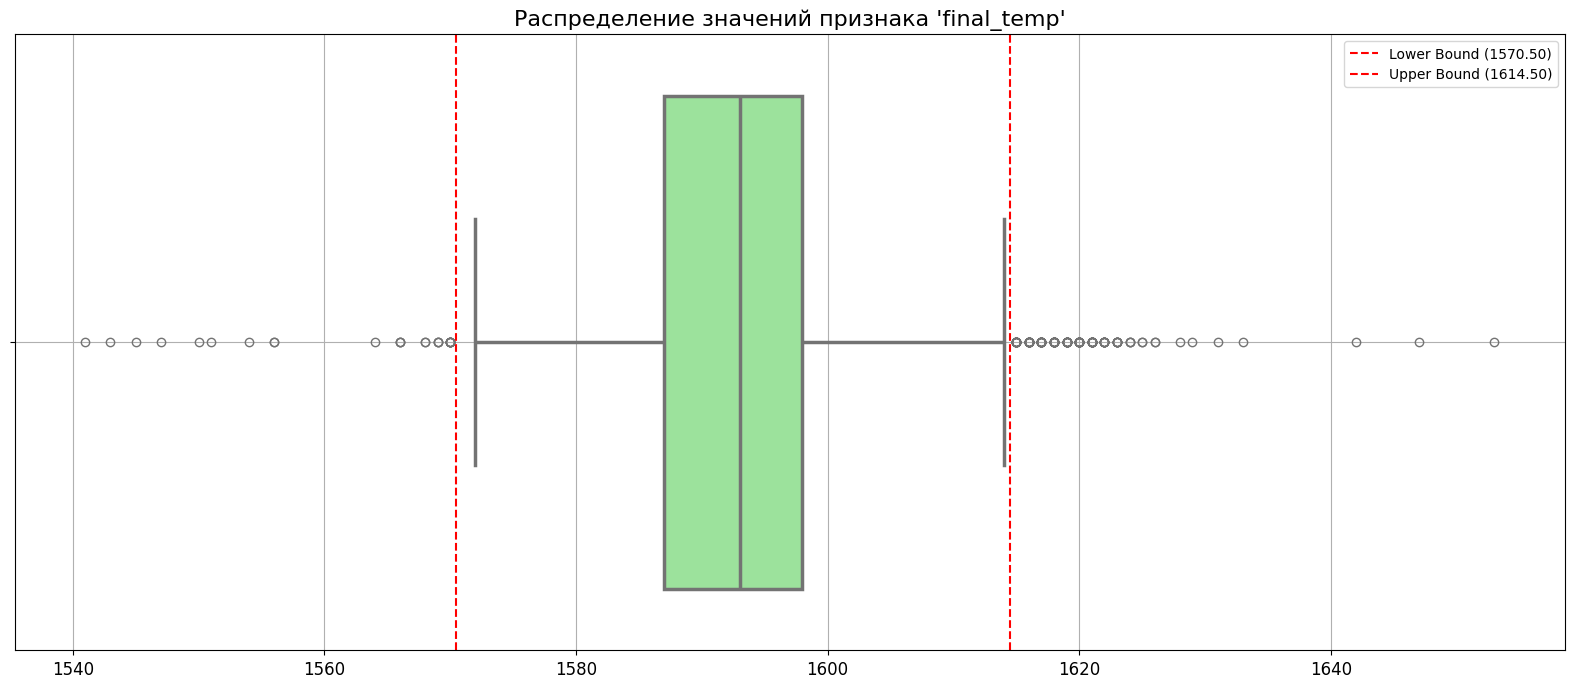

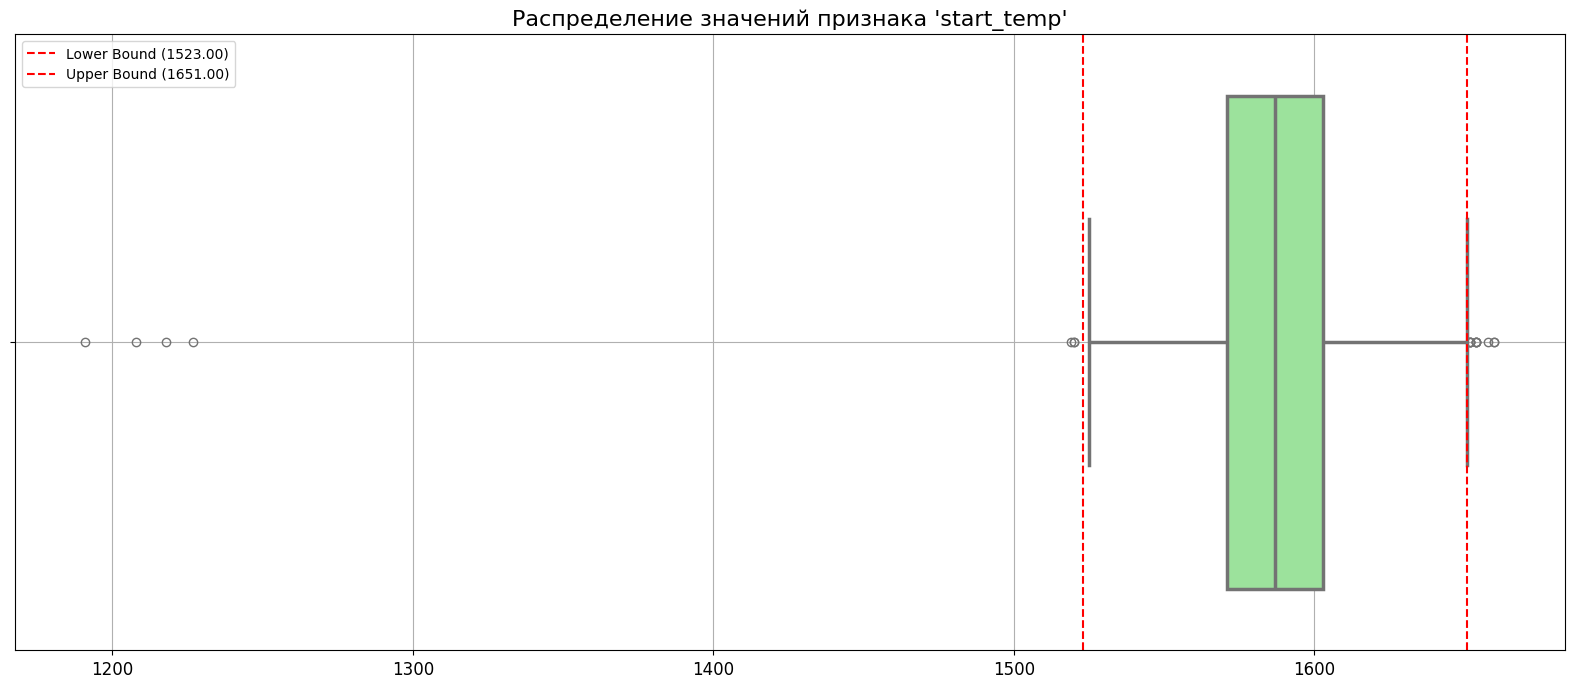

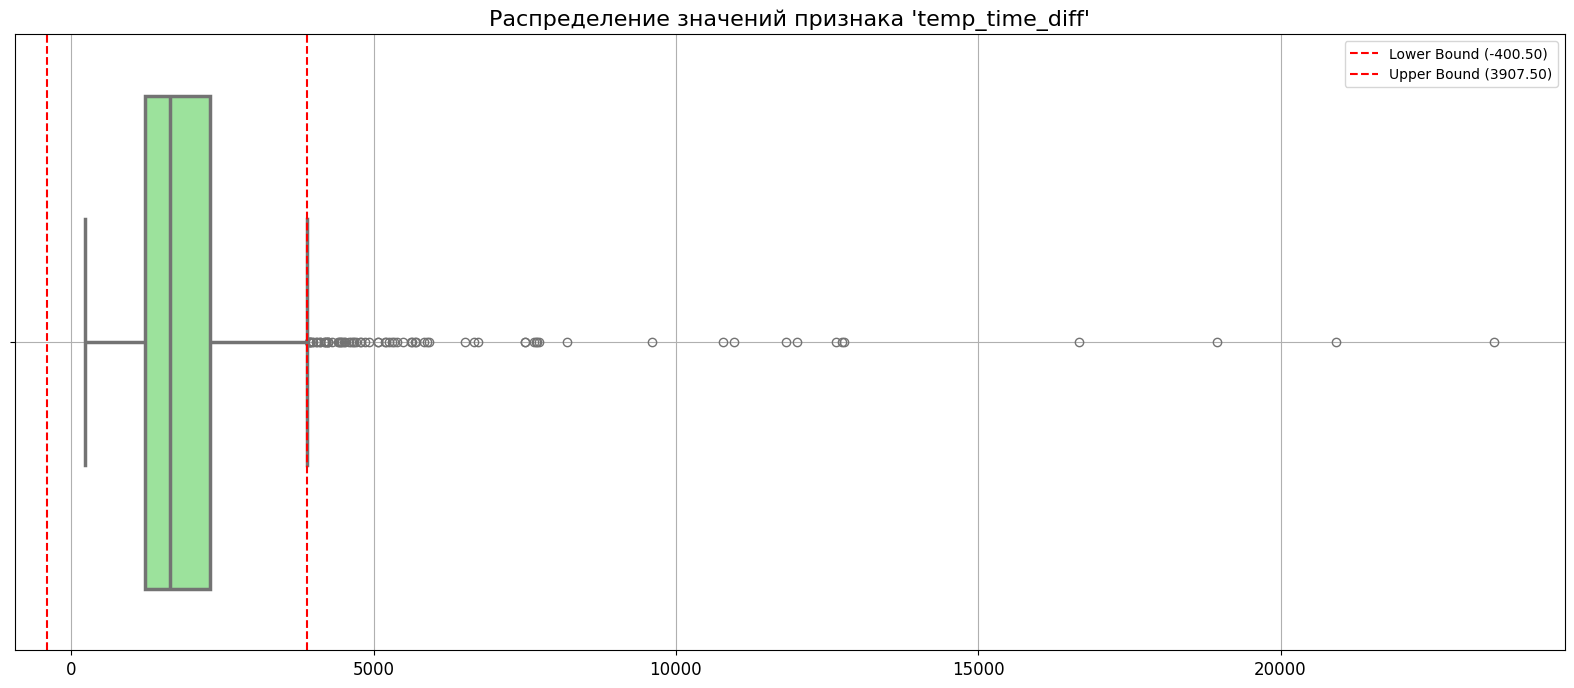

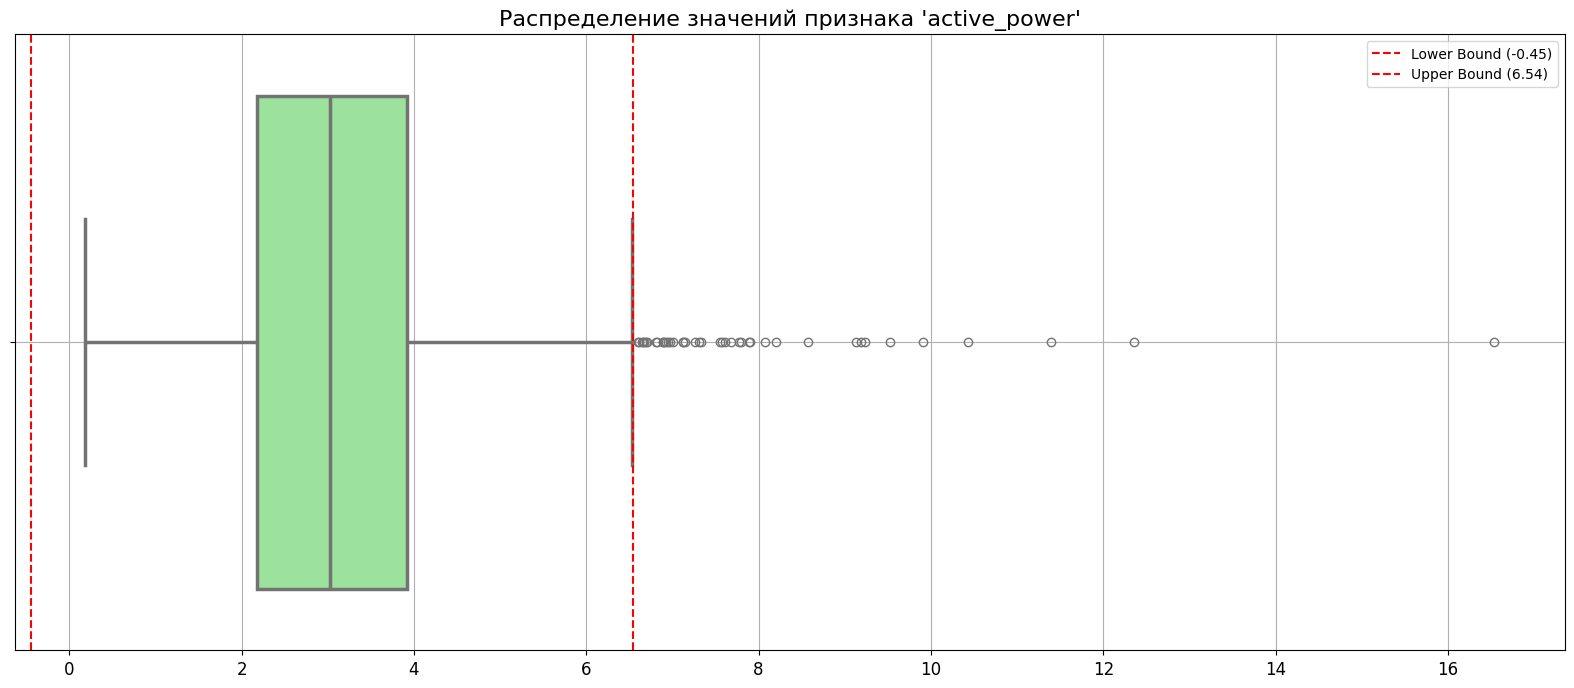

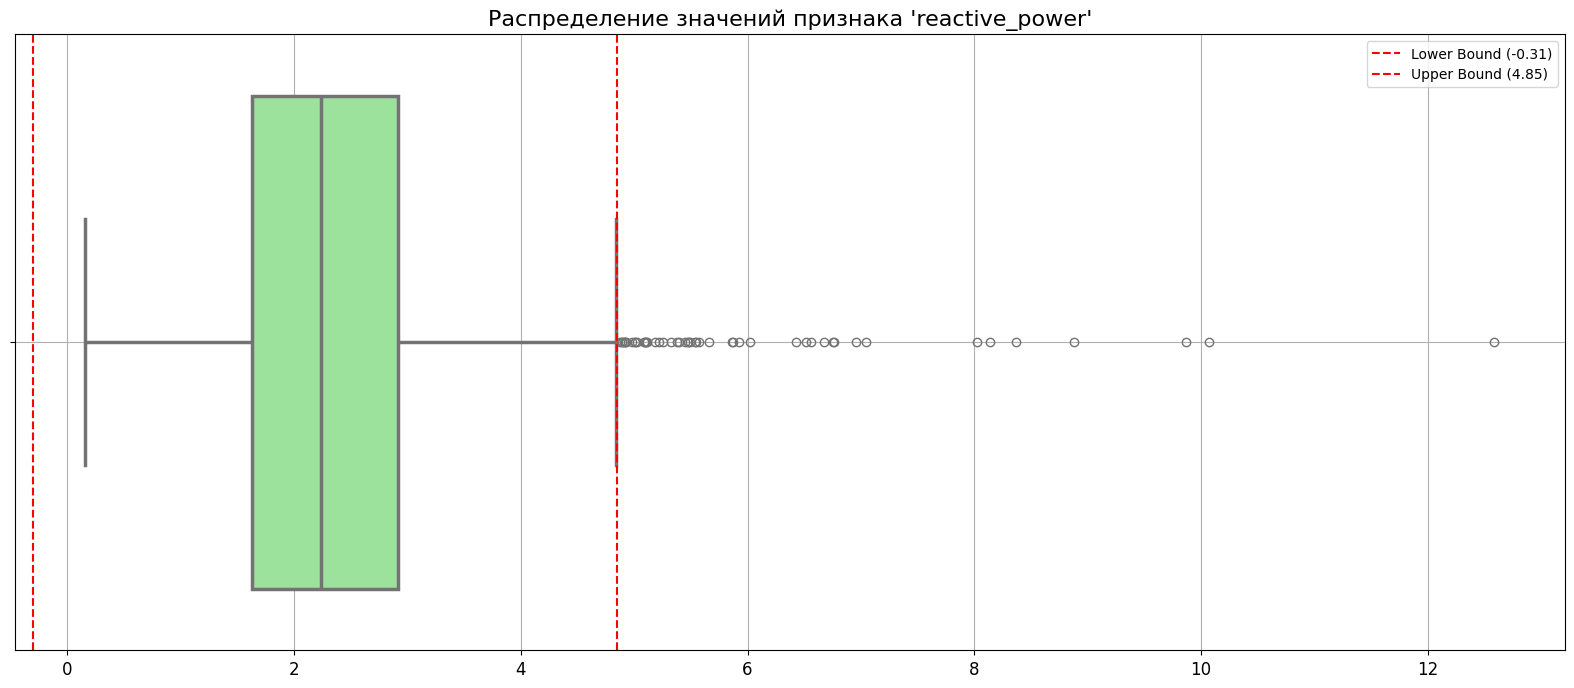

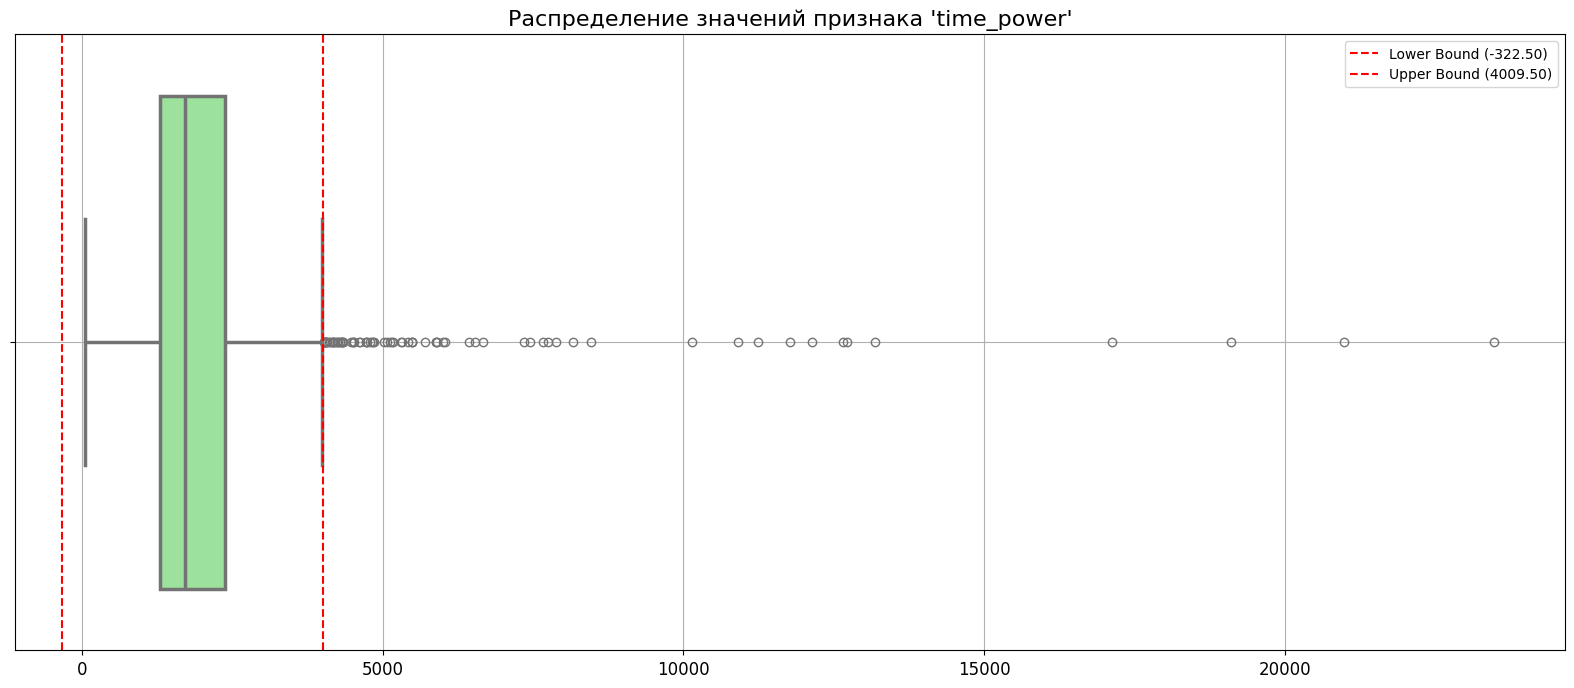

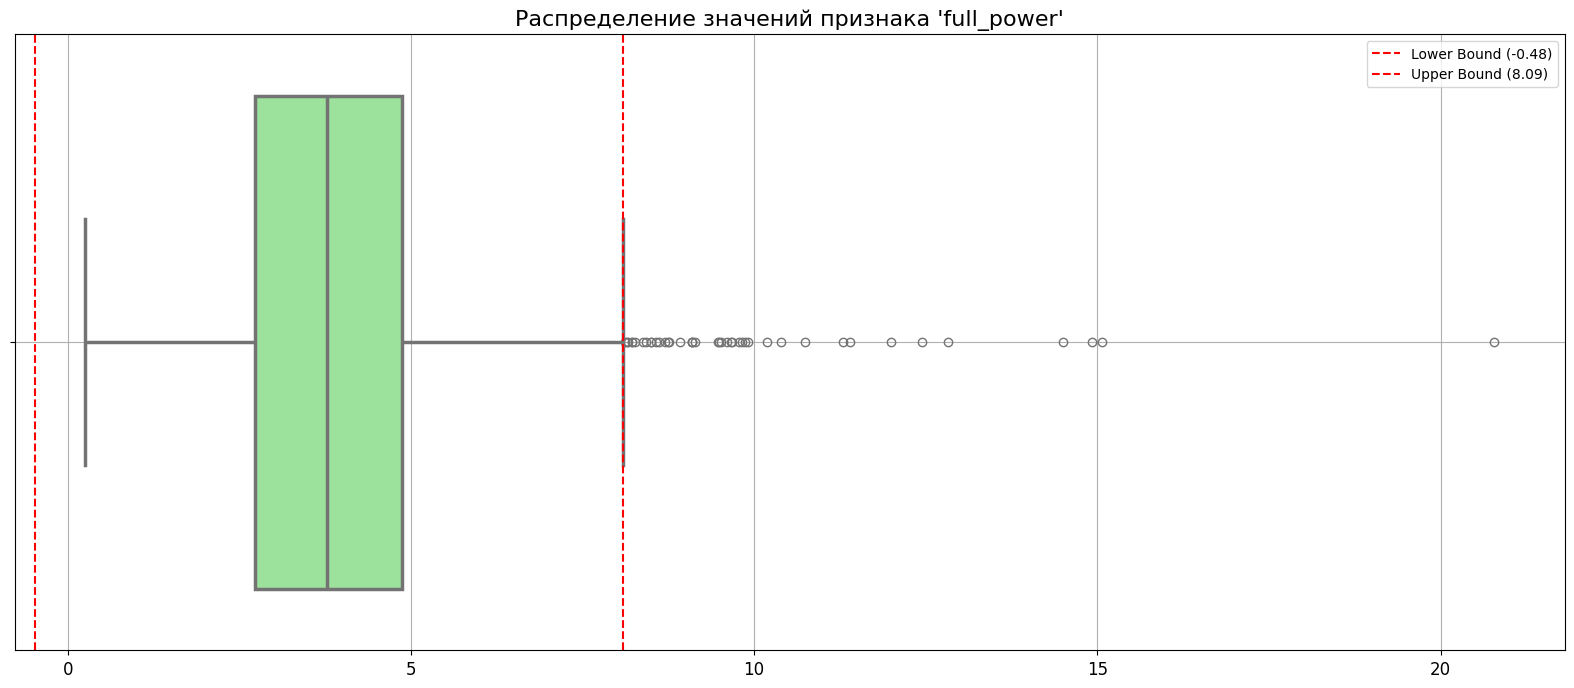

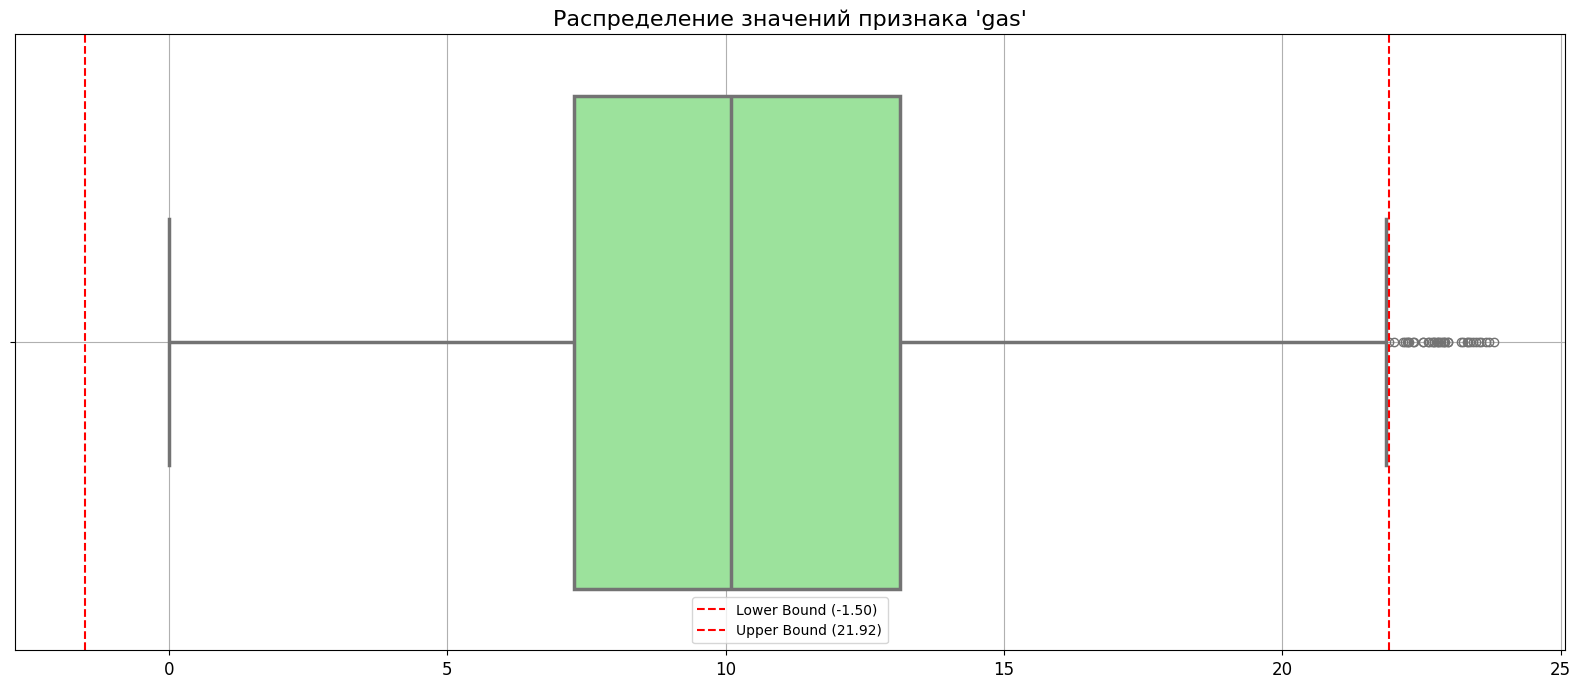

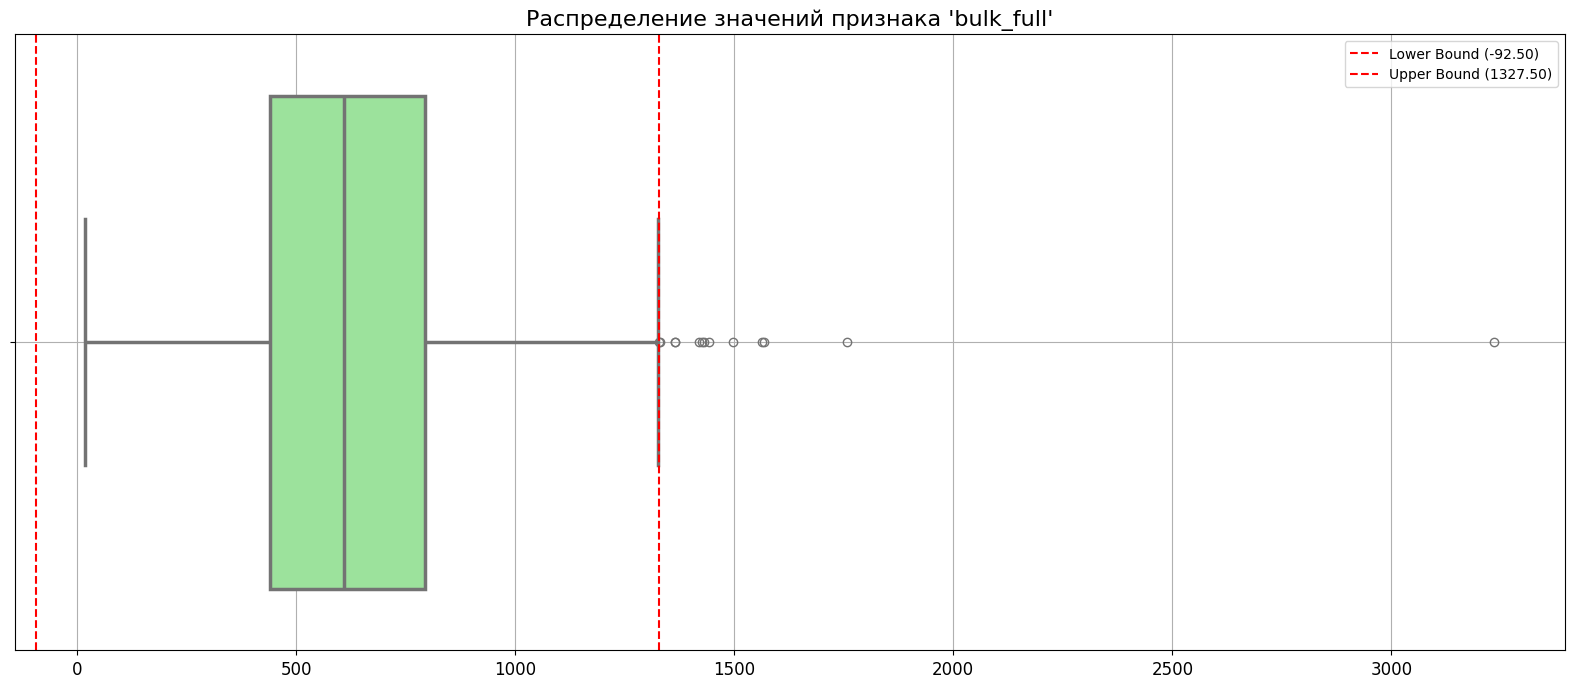

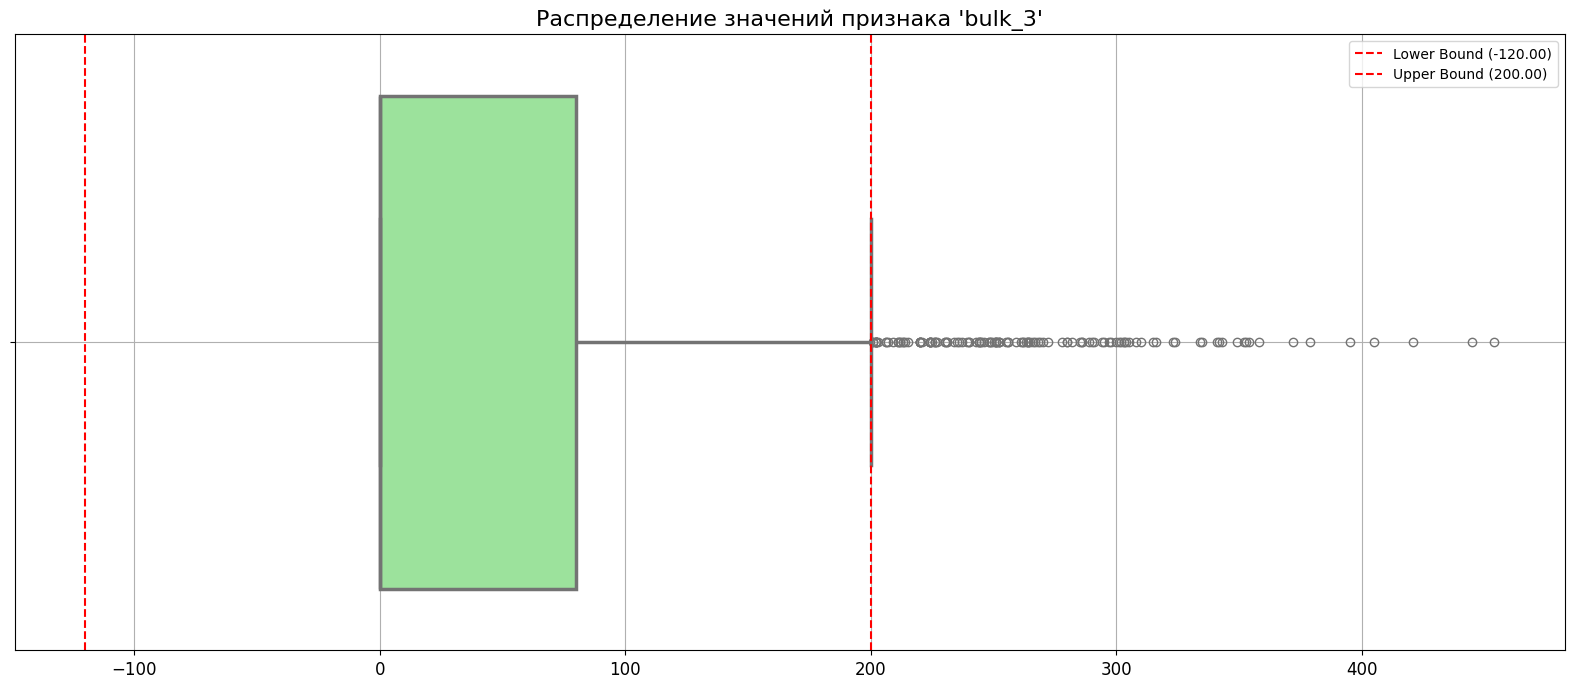

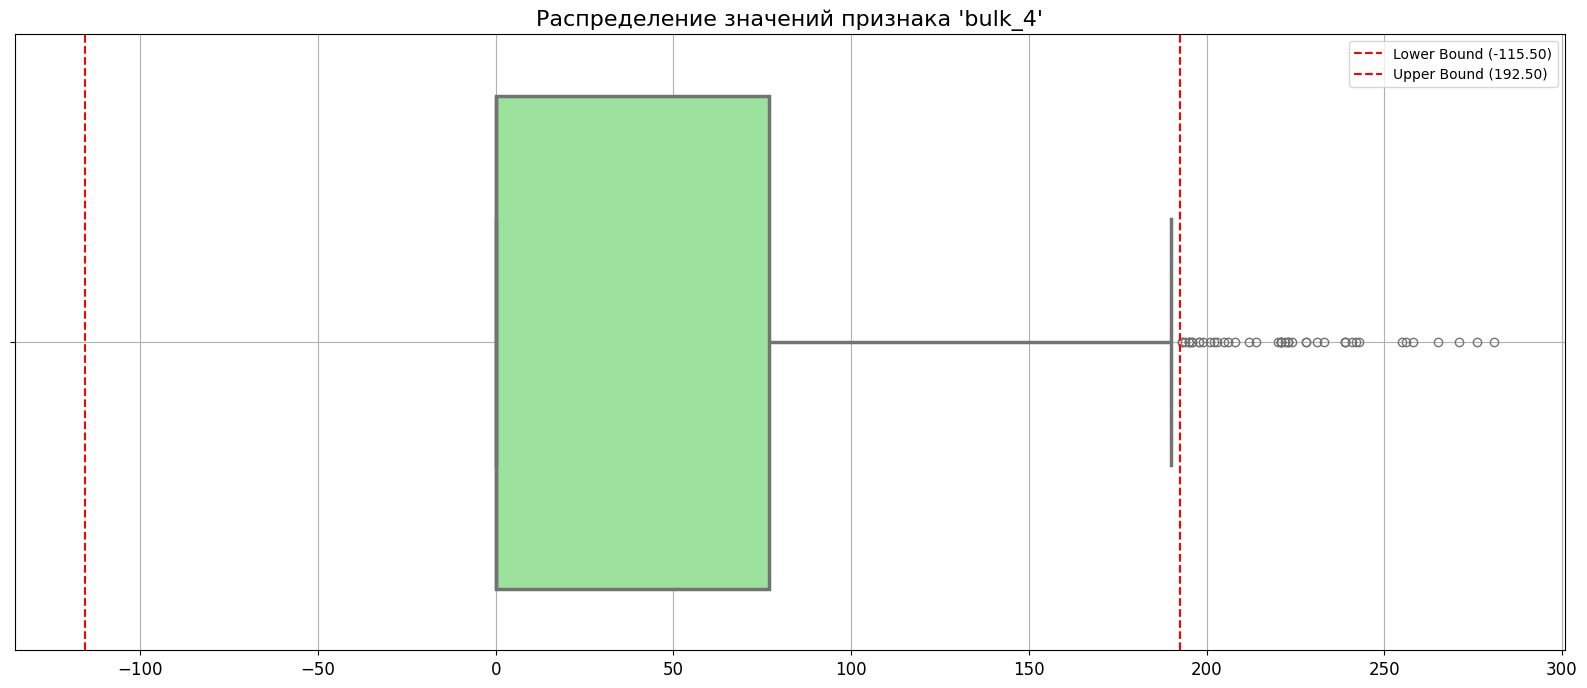

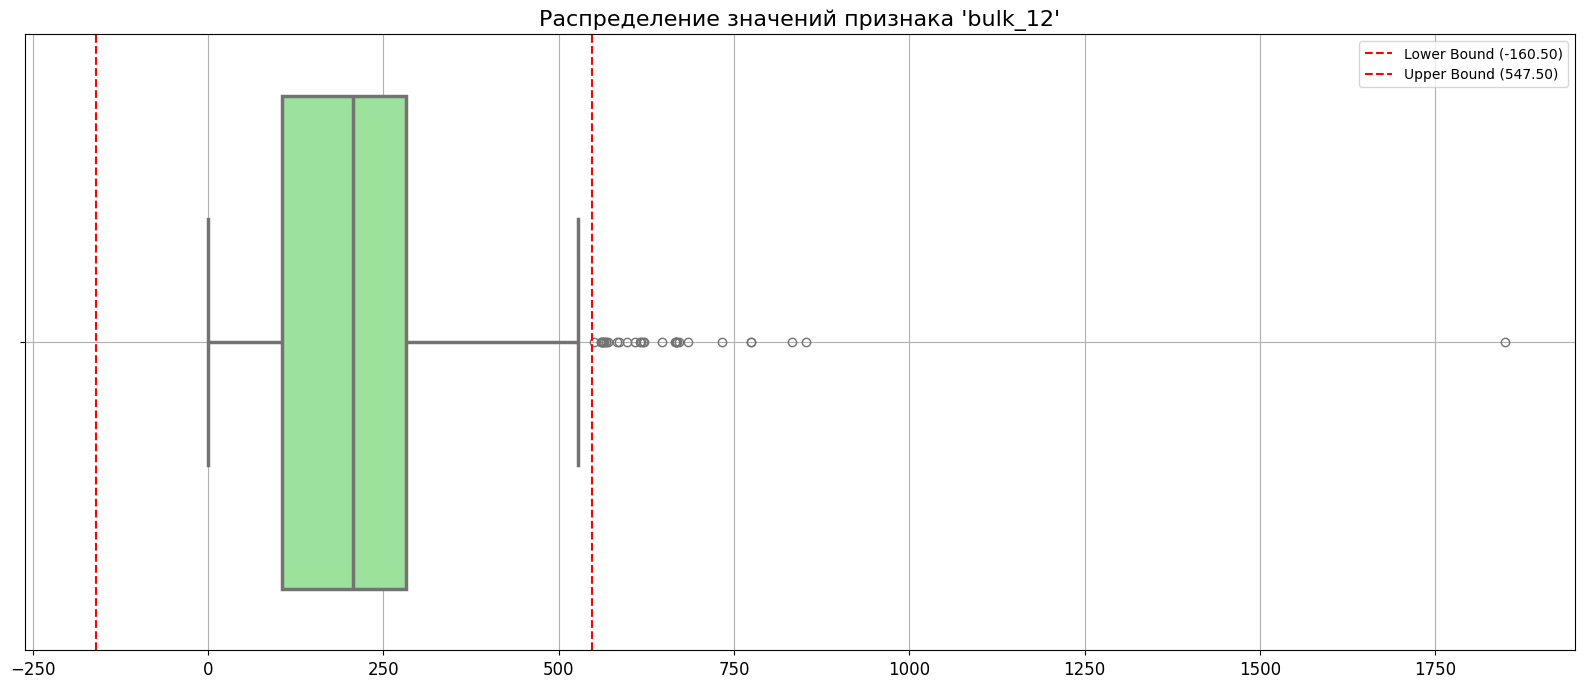

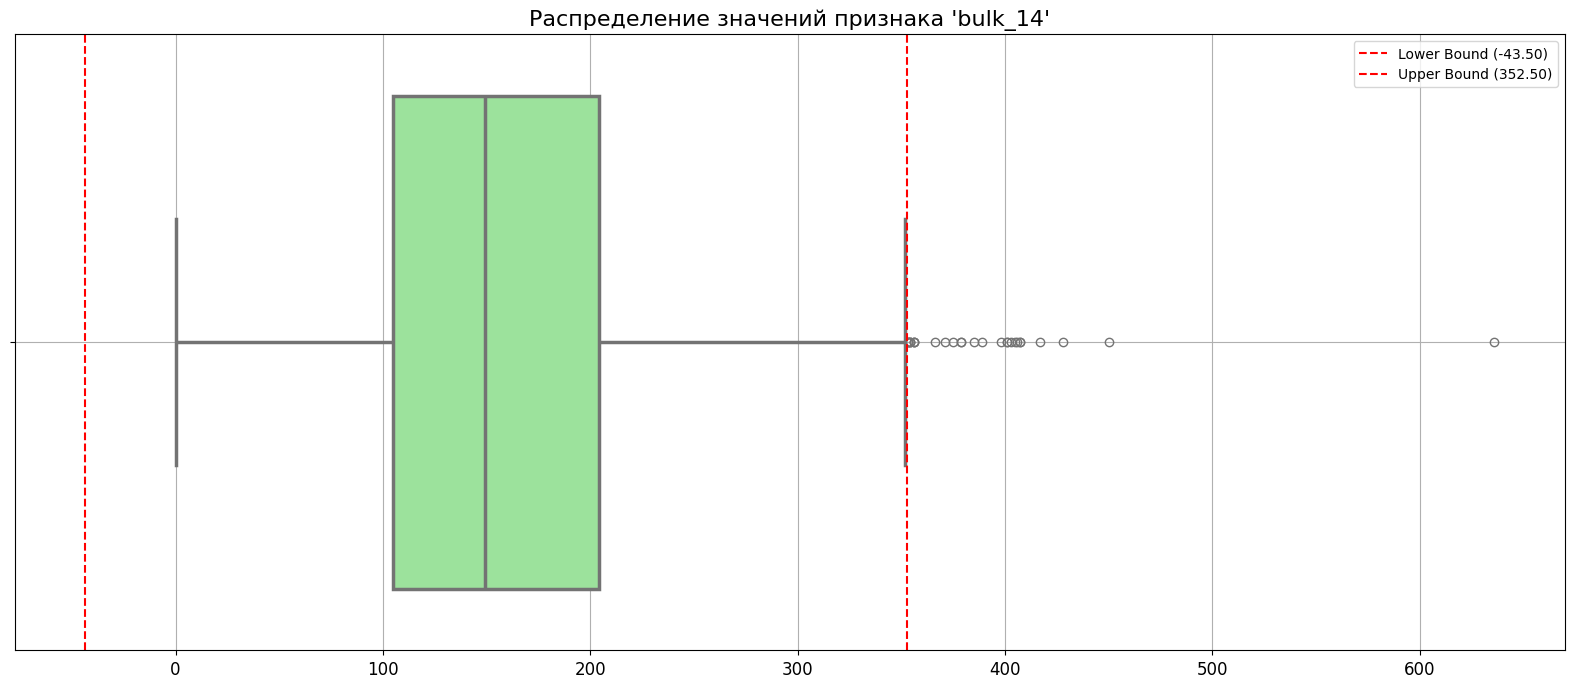

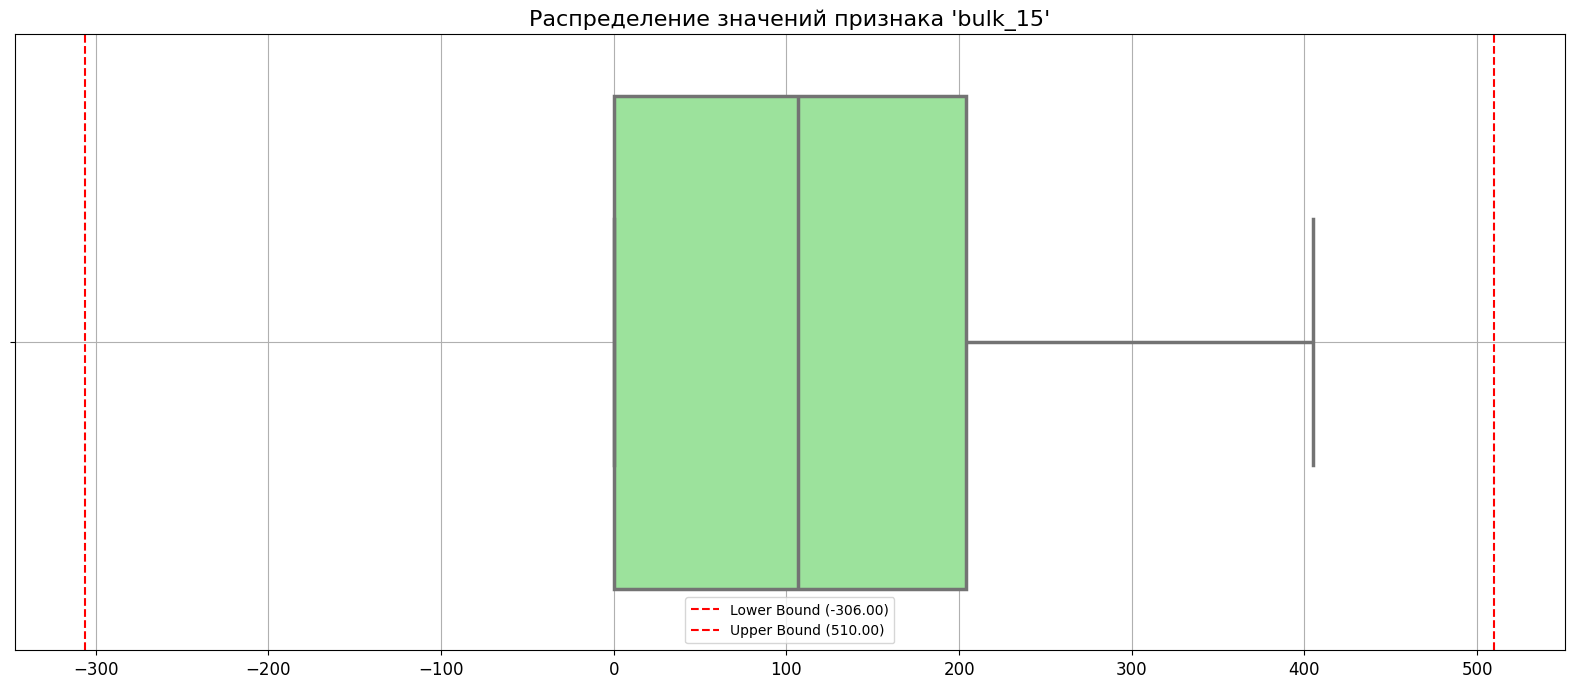

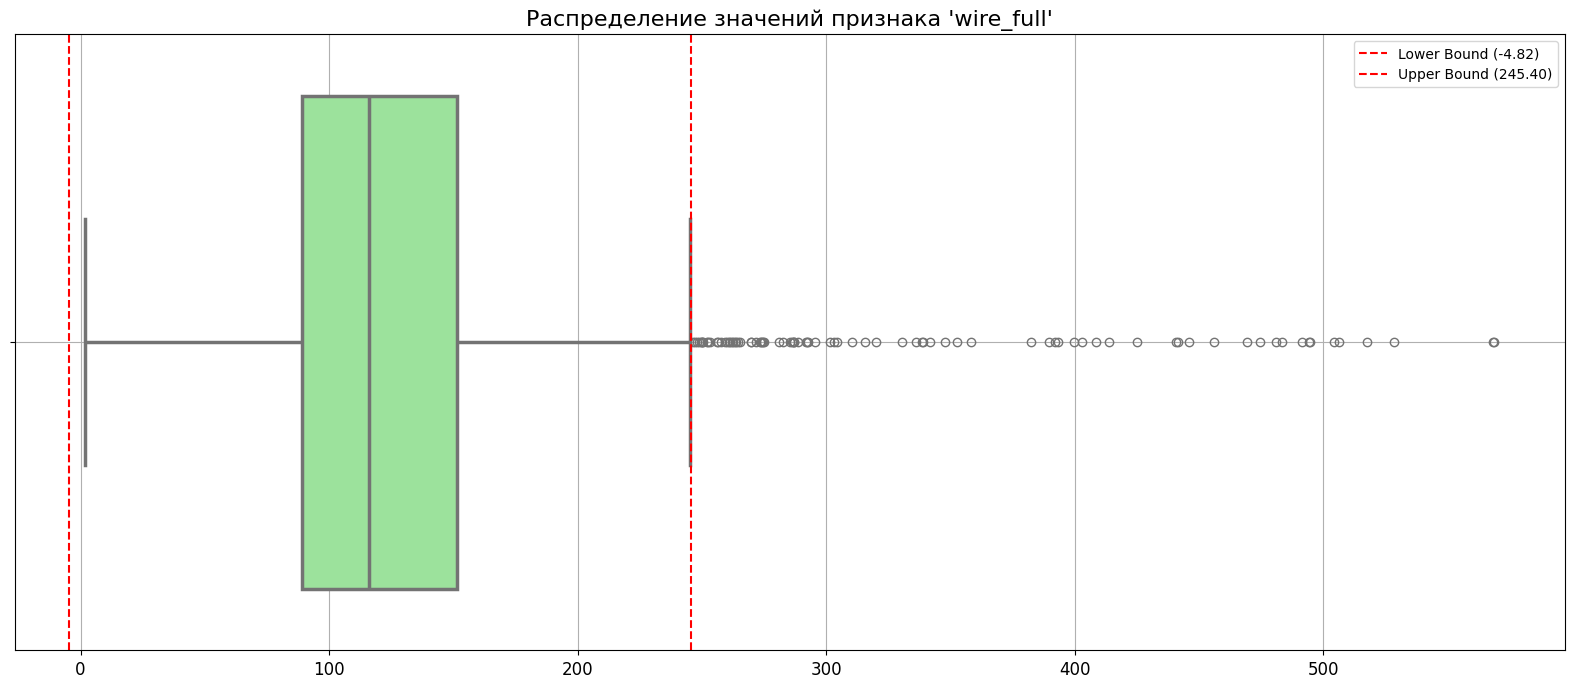

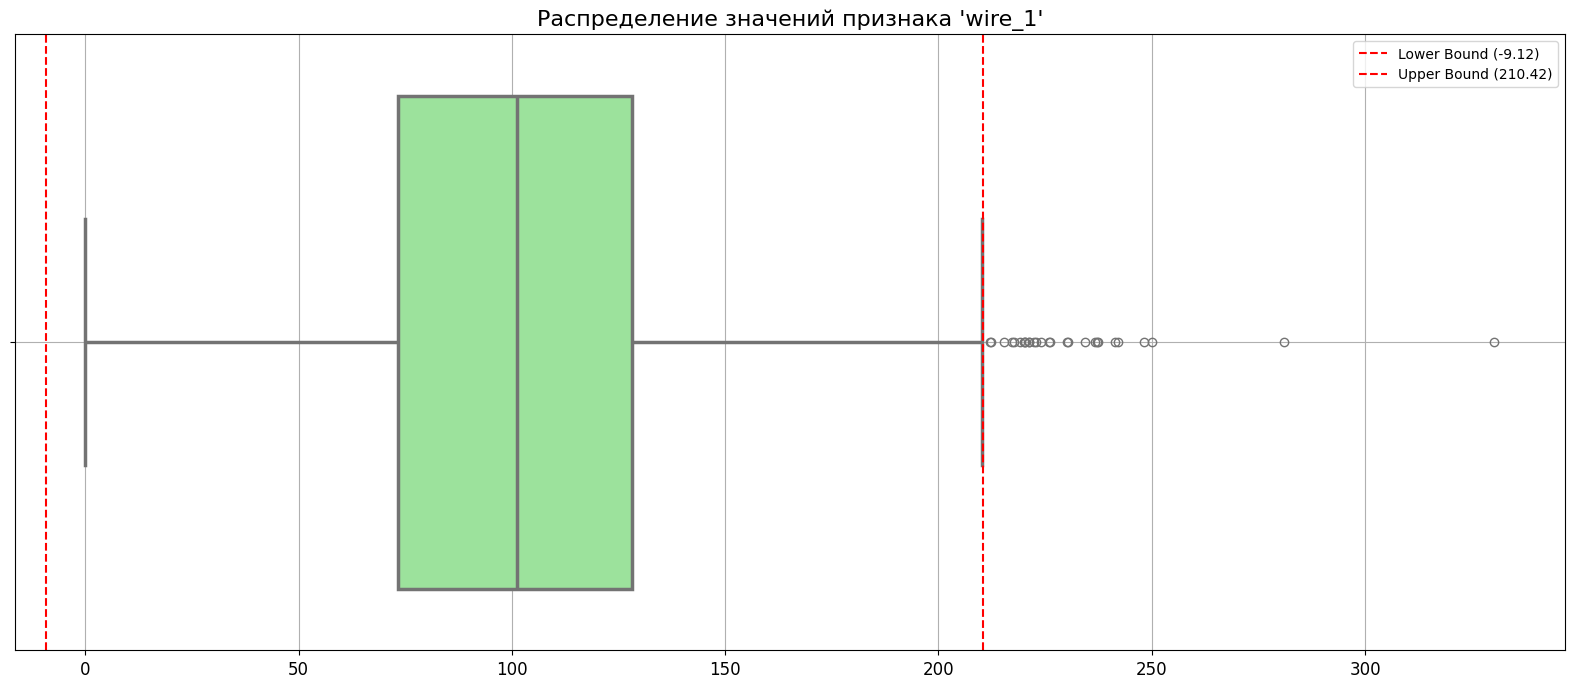

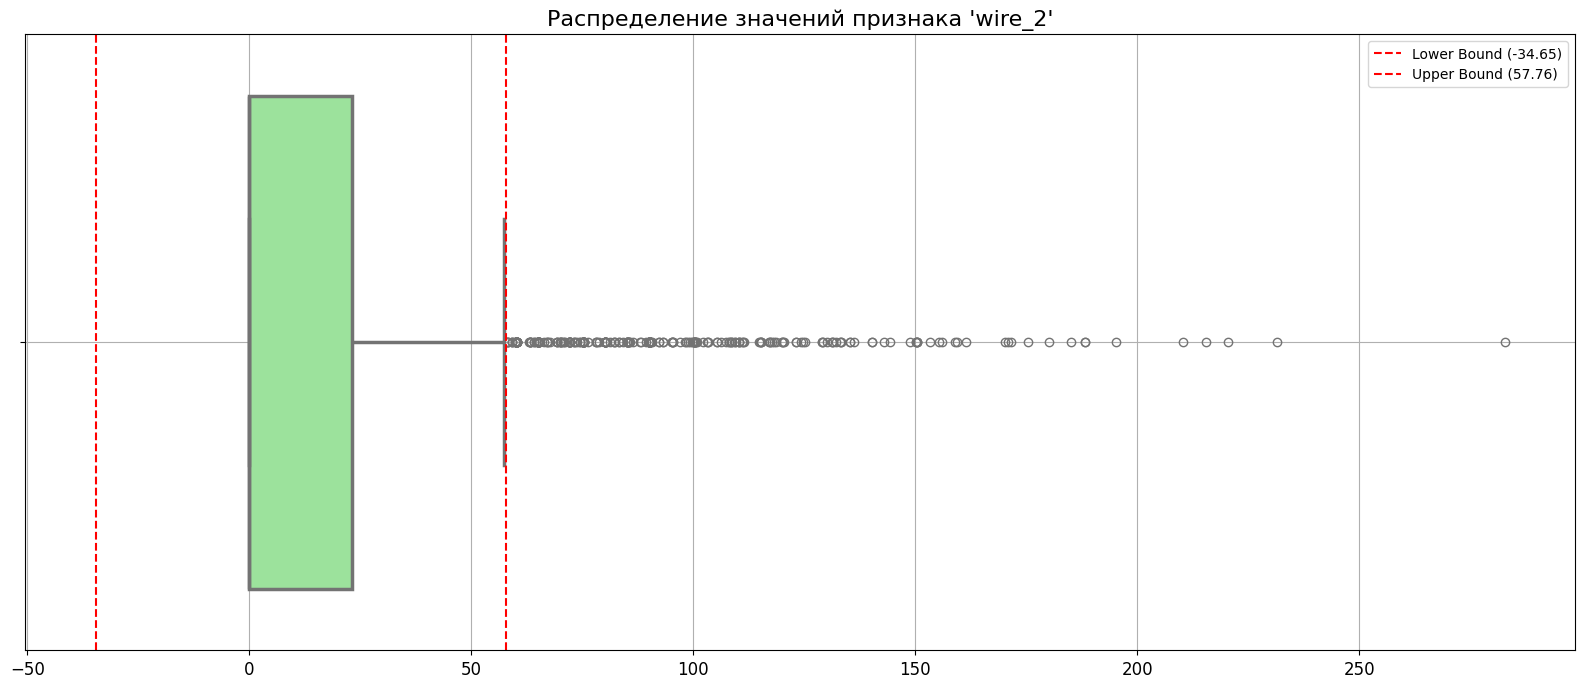

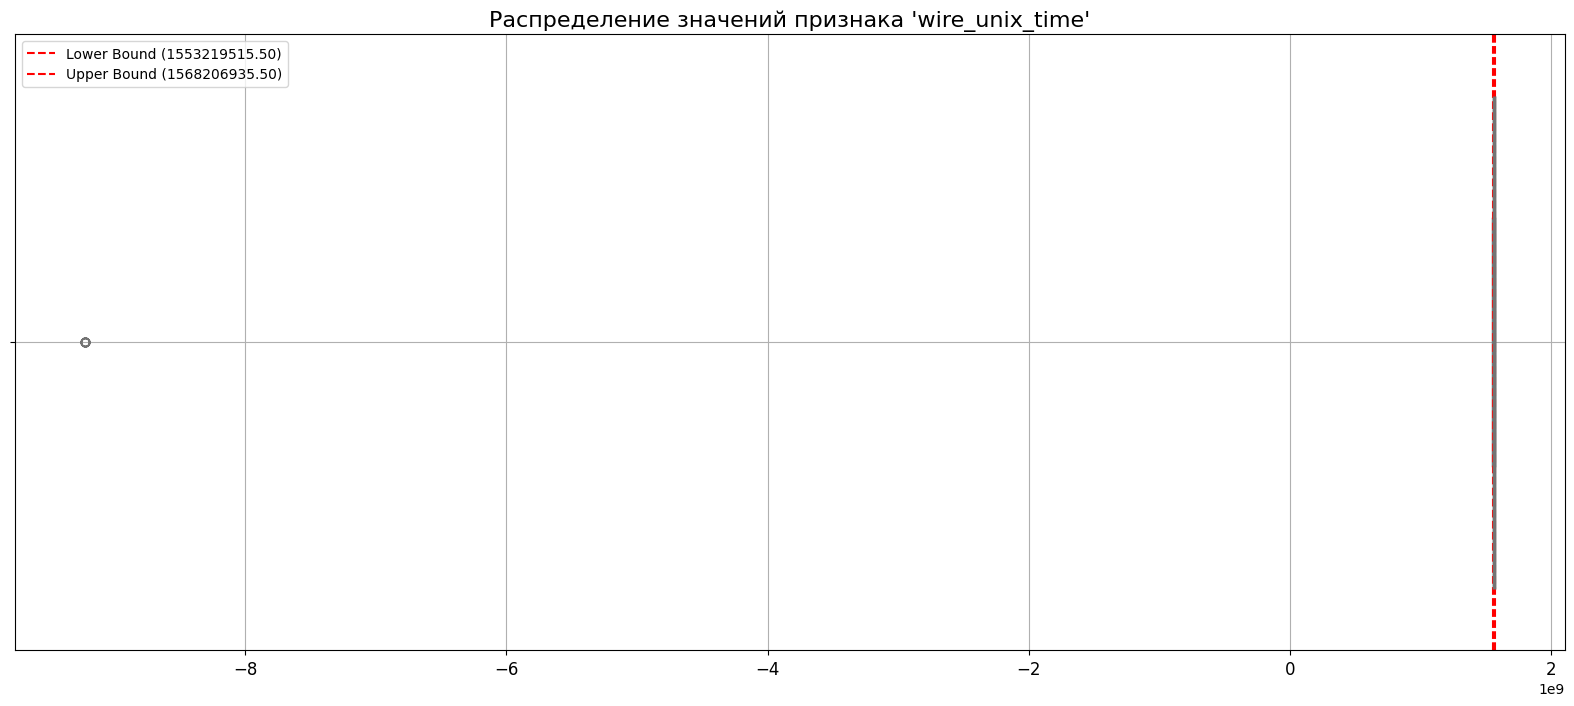

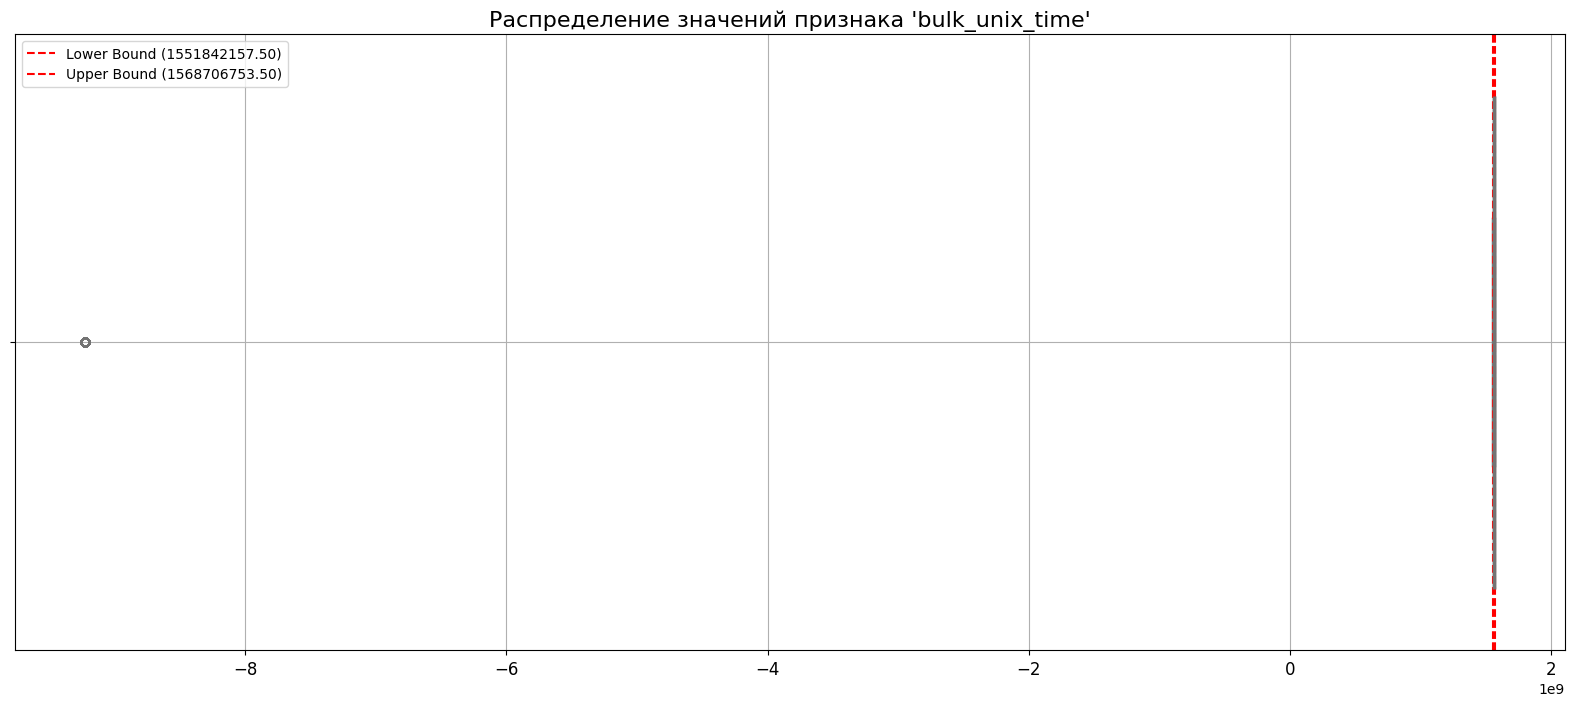

In [677]:
feature_distribution(data, 'lightgreen')

При анализе распределения значений признаков в датасете были выявлены значения, выходящие за пределы общего распределения, которые условно можно определить как выбросы. Эти выбросы отмечены в следующих признаках: 'active_power', 'reactive_power', 'time_power', 'full_power', 'gas', 'bulk_full', 'bulk_12', 'bulk_14', 'wire_1' и 'wire_2'. Обычно выбросы определяются в стороне от максимальных значений признаков. Хотя количество обнаруженных выбросов невелико, удаление их может помочь уменьшить ошибку при обучении моделей. Однако необходимо учитывать, что удаление выбросов может привести к неправильному обучению моделей, которые затем могут не соответствовать реальным условиям технологического процесса. Поэтому целесообразно провести дополнительные консультации с инженерами металлургического комбината для определения допустимого диапазона значений признаков.

Что касается признаков 'wire_unix_time' и 'bulk_unix_time', они представляют сведения о времени в формате UNIX time, содержащем достаточно большие числа. Однако в обоих признаках также есть небольшое количество нулевых значений, которые изначально были пропущенными данными. Заменять нулевые значения другими данными нежелательно, так как это может исказить результаты обучения моделей. Также удаление ковшей (партий) с нулевыми значениями нецелесообразно, так как это приведет к потере ценной информации о других признаках. Поэтому не будет производиться корректировка значений этих признаков. Однако, мы можем проанализировать распределение значений этих признаков, исключив нулевые значения при этом.

In [678]:
# отфильтруем из датасета data признаки,
# соответствующие условию
data_wire_unix_time = pd.DataFrame(data.loc[data['wire_unix_time'] > 0, 'wire_unix_time'])

data_bulk_unix_time = pd.DataFrame(data.loc[data['bulk_unix_time'] > 0, 'bulk_unix_time'])

# проверим размеры датасетов
data_wire_unix_time.shape, data_bulk_unix_time.shape

((2306, 1), (2068, 1))

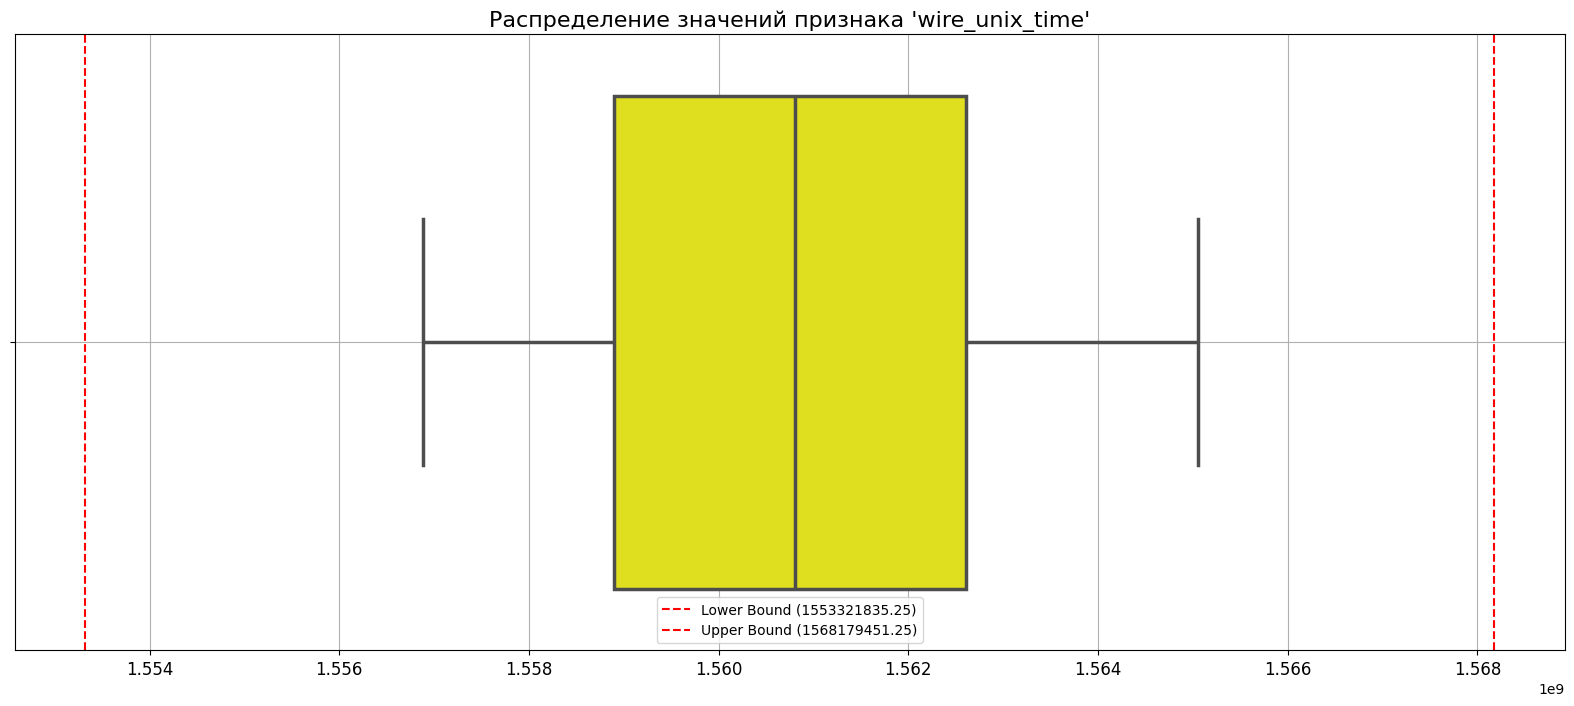

In [679]:
# построим диаграмму размаха с распределением значений признака
feature_distribution(data_wire_unix_time, 'yellow')

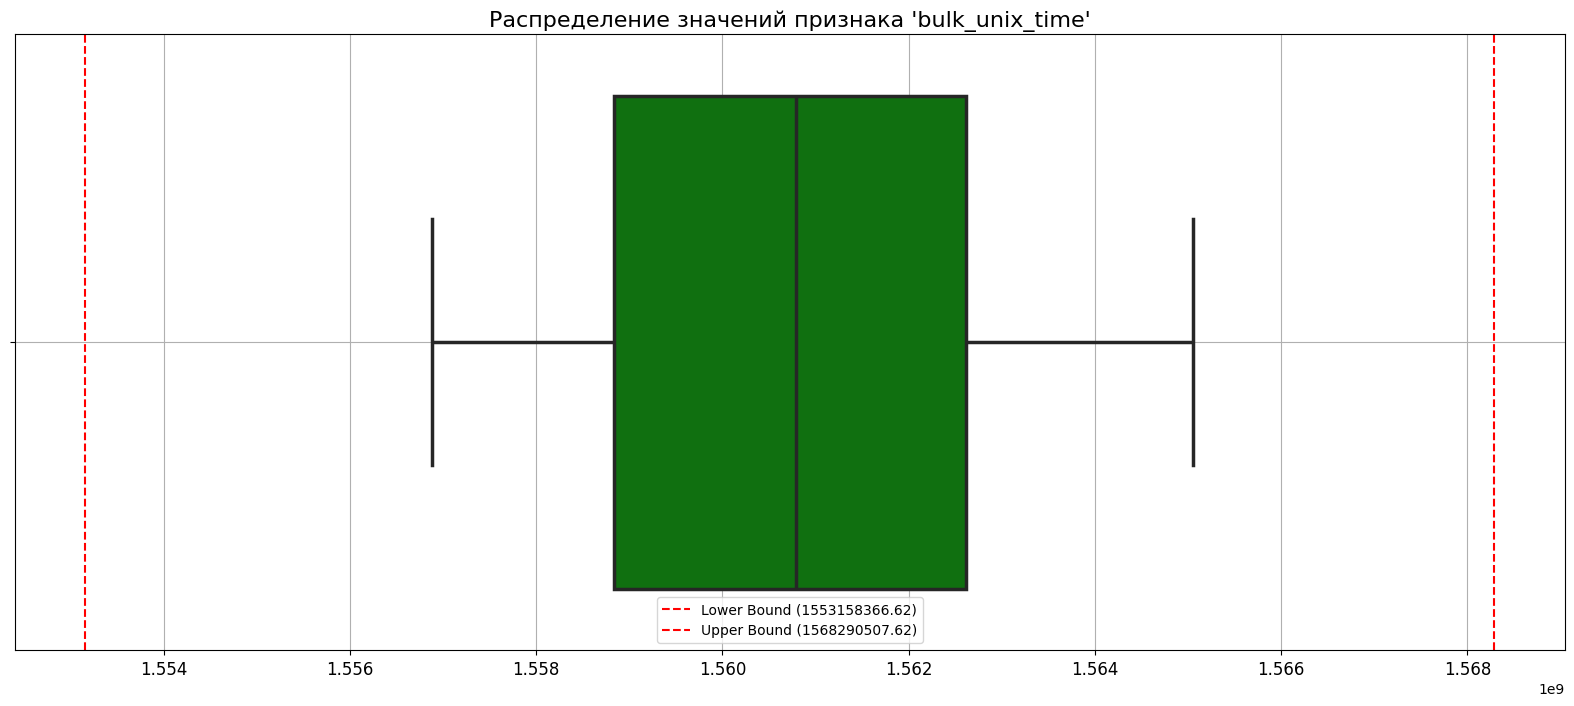

In [680]:
feature_distribution(data_bulk_unix_time, 'green')

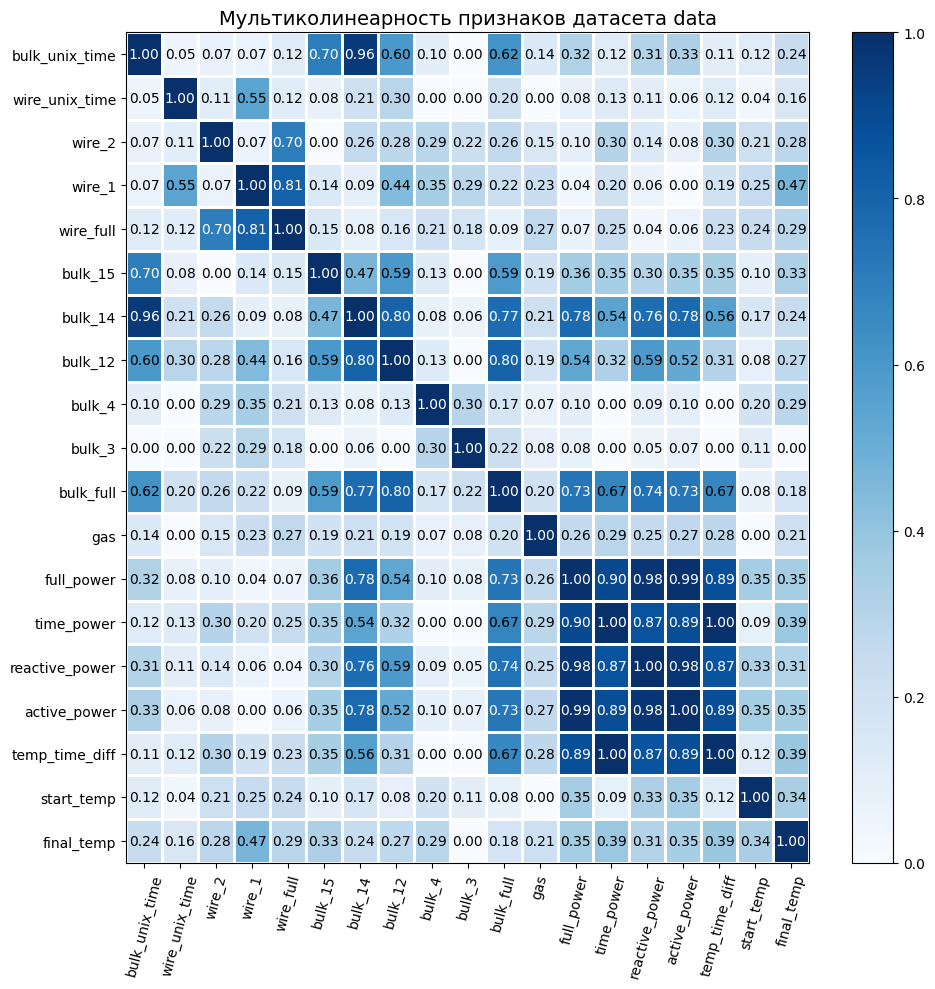

In [681]:
interval_cols = data.select_dtypes('number').columns.tolist()
phik_overview = data.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'Мультиколинеарность признаков датасета data',
    fontsize_factor=1,
    figsize=(10, 10))
plt.xticks(rotation = 75)
plt.tight_layout()

После удаления четырех признаков в датасете data не выявлено признаков с очень сильной линейной корреляцией (> 0.9).

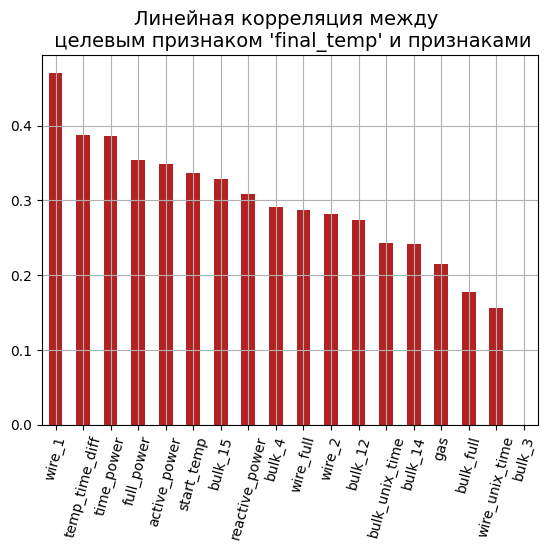

In [682]:
# изобразим на рисунке признаки в зависимости от уровня корреляции
# между ними и целевым признаком
phik_overview['final_temp'] \
    .sort_values(ascending=False) \
    [1:].plot(kind='bar', grid = True, color = 'firebrick')
plt.title('Линейная корреляция между \n целевым признаком \
\'final_temp\' и признаками', \
          fontsize = 14)
plt.xticks(rotation = 75)
plt.show()

Высокой и очень высокой линейной корреляции между целевым признаком и признаками нет, что позволяет сделать вывод об отсутствии утечки целевого признака в обучающую часть.

In [683]:
t = data.copy()

In [684]:
def filter(series: pd.Series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    mask = (series >= Q1 - 3*IQR) & (series <= Q3 + 3*IQR)

    filtered_series = series.where(mask, other=None)
    return filtered_series

In [685]:
dt = filter(t)

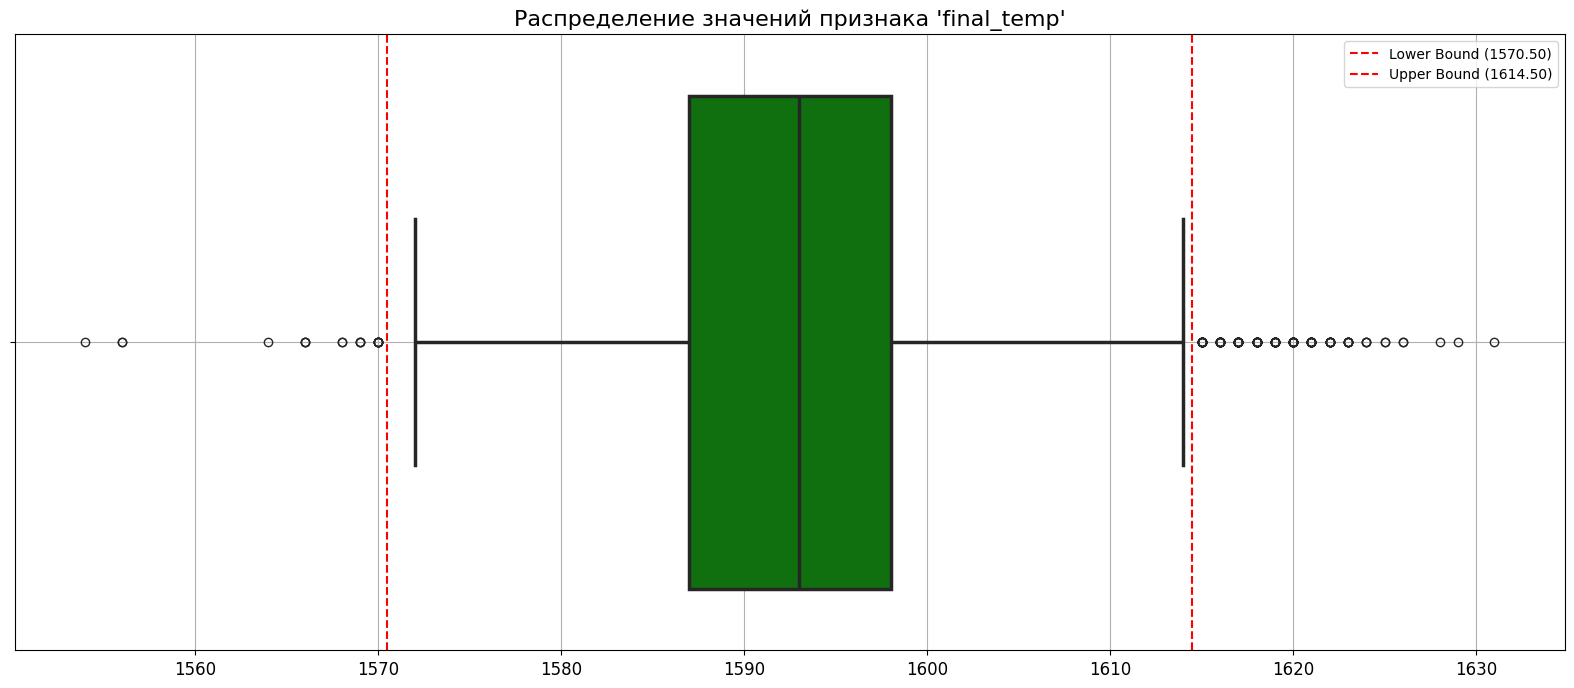

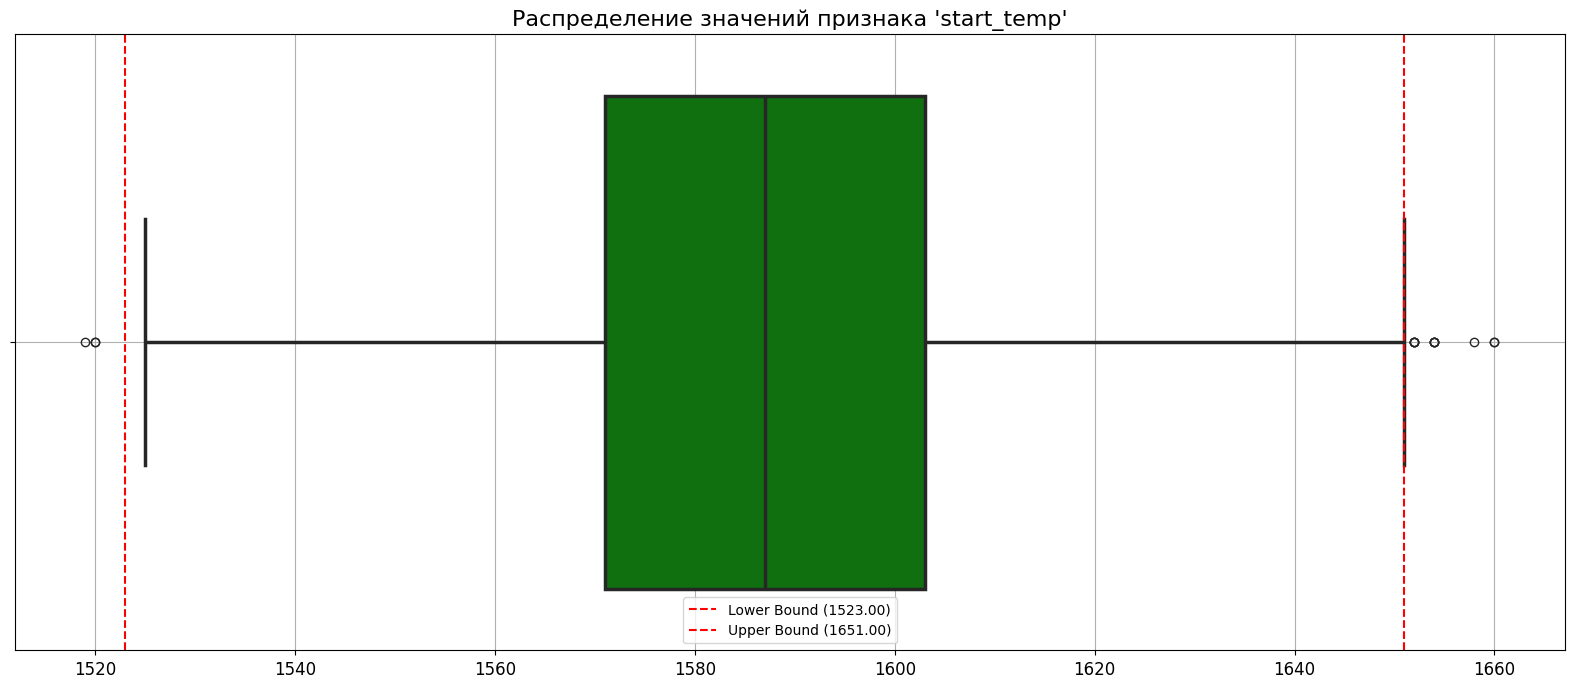

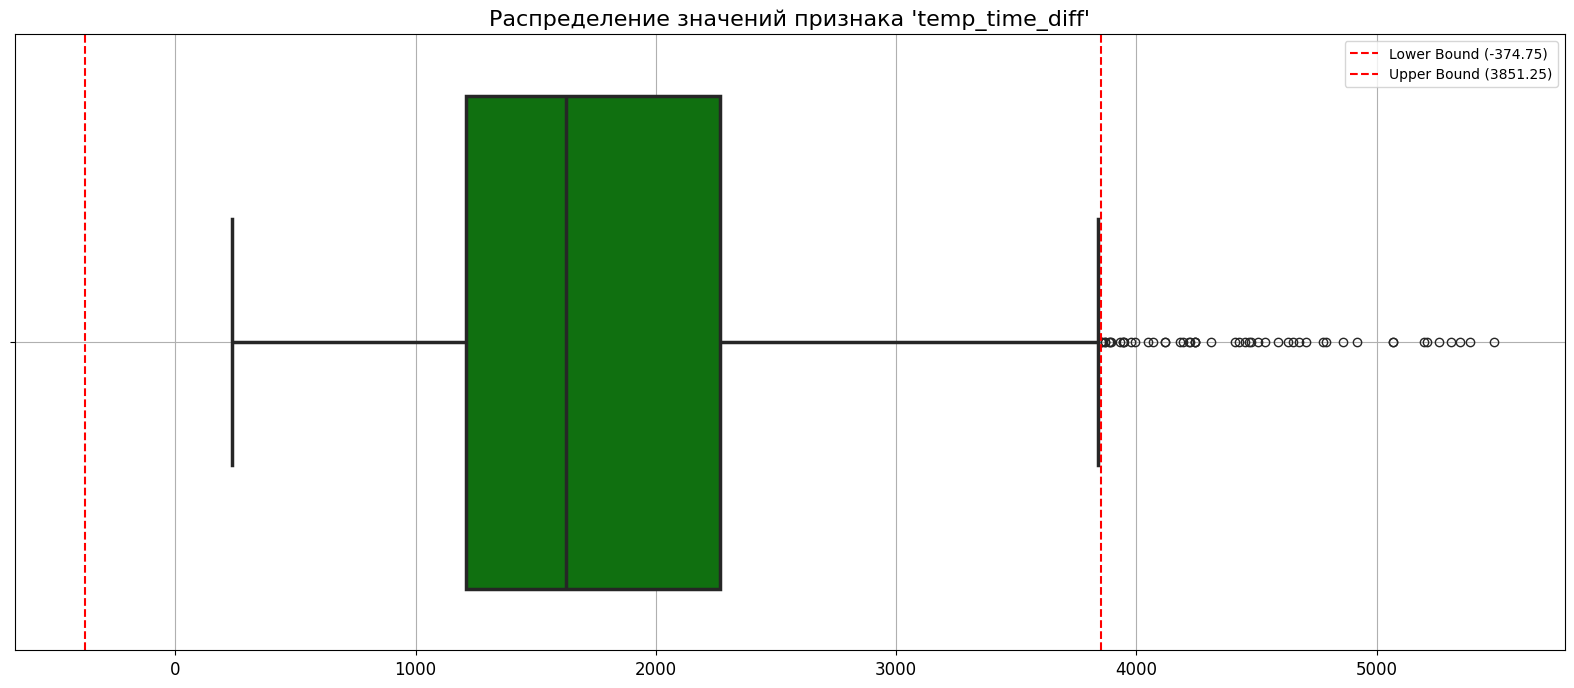

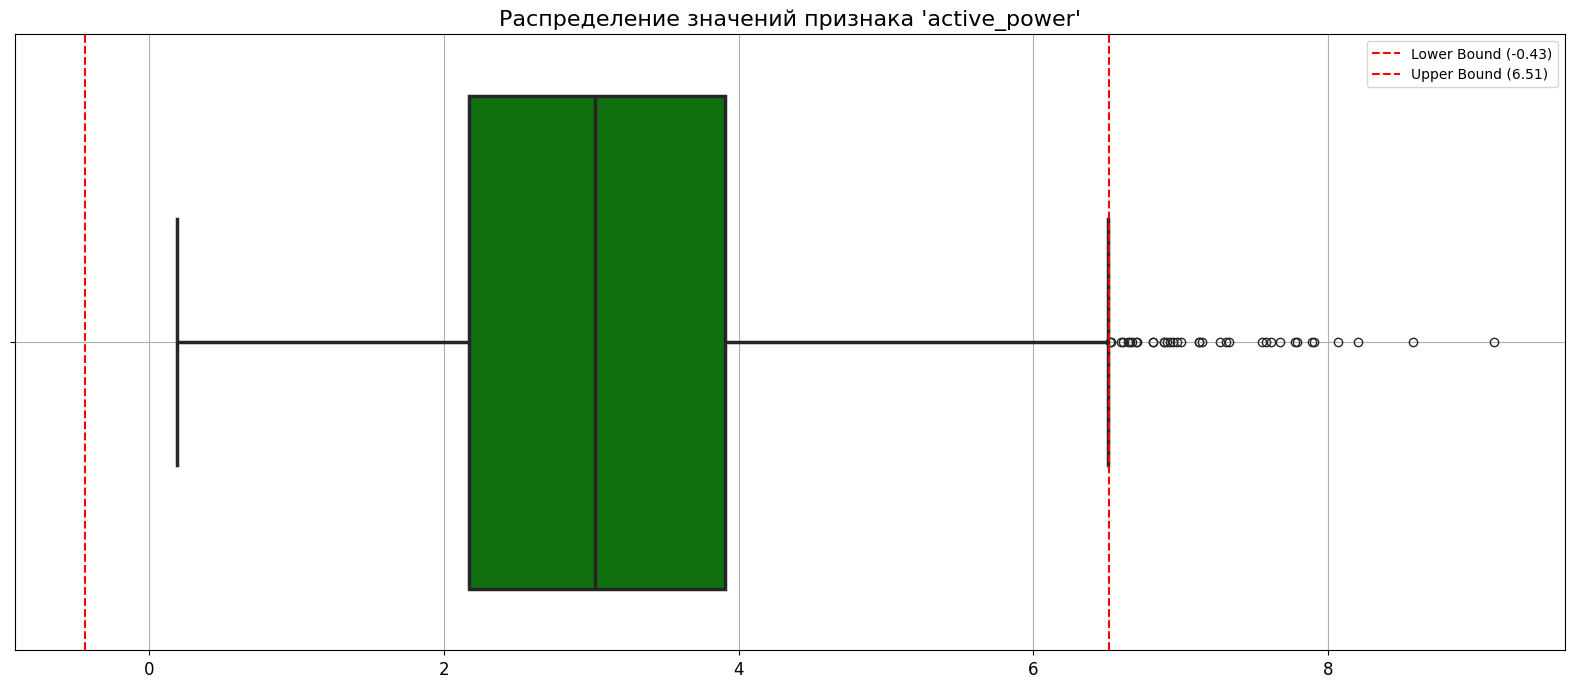

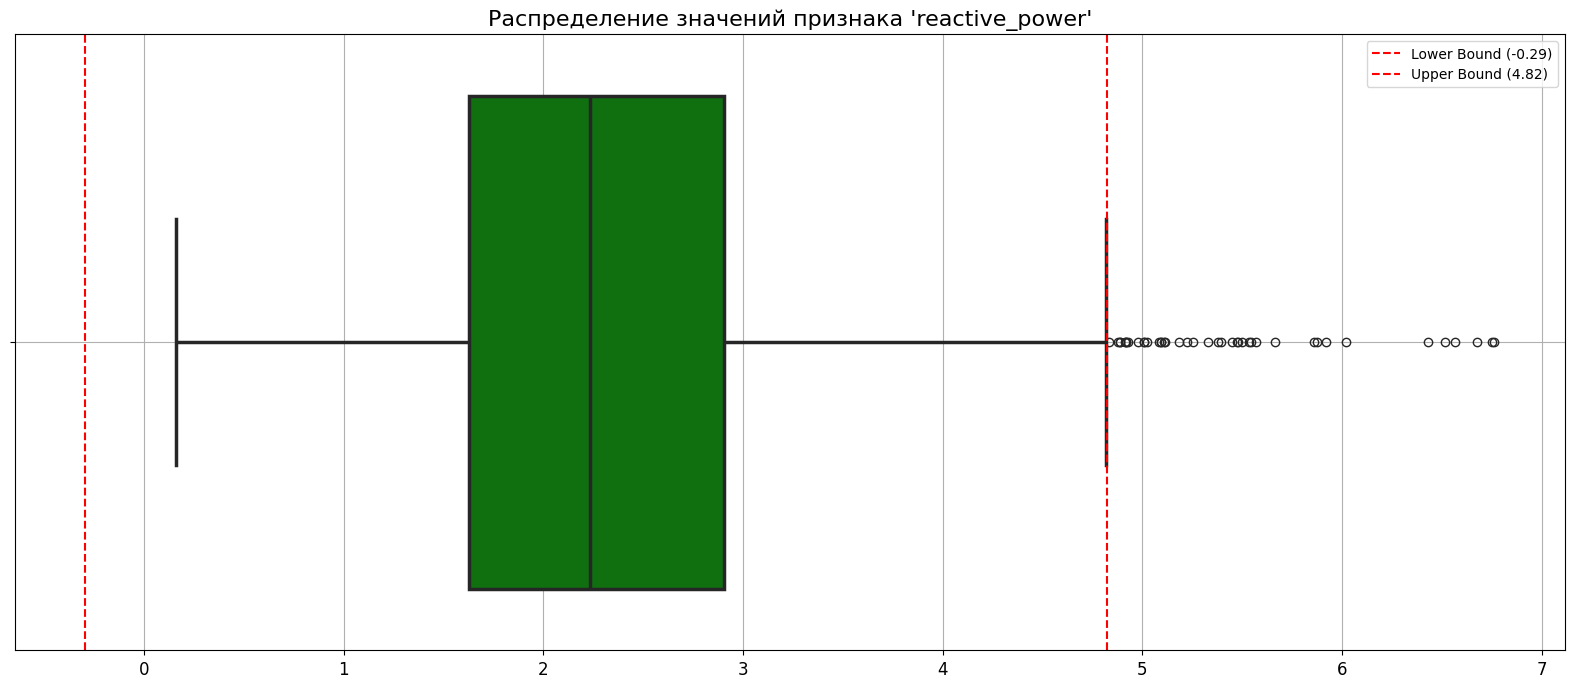

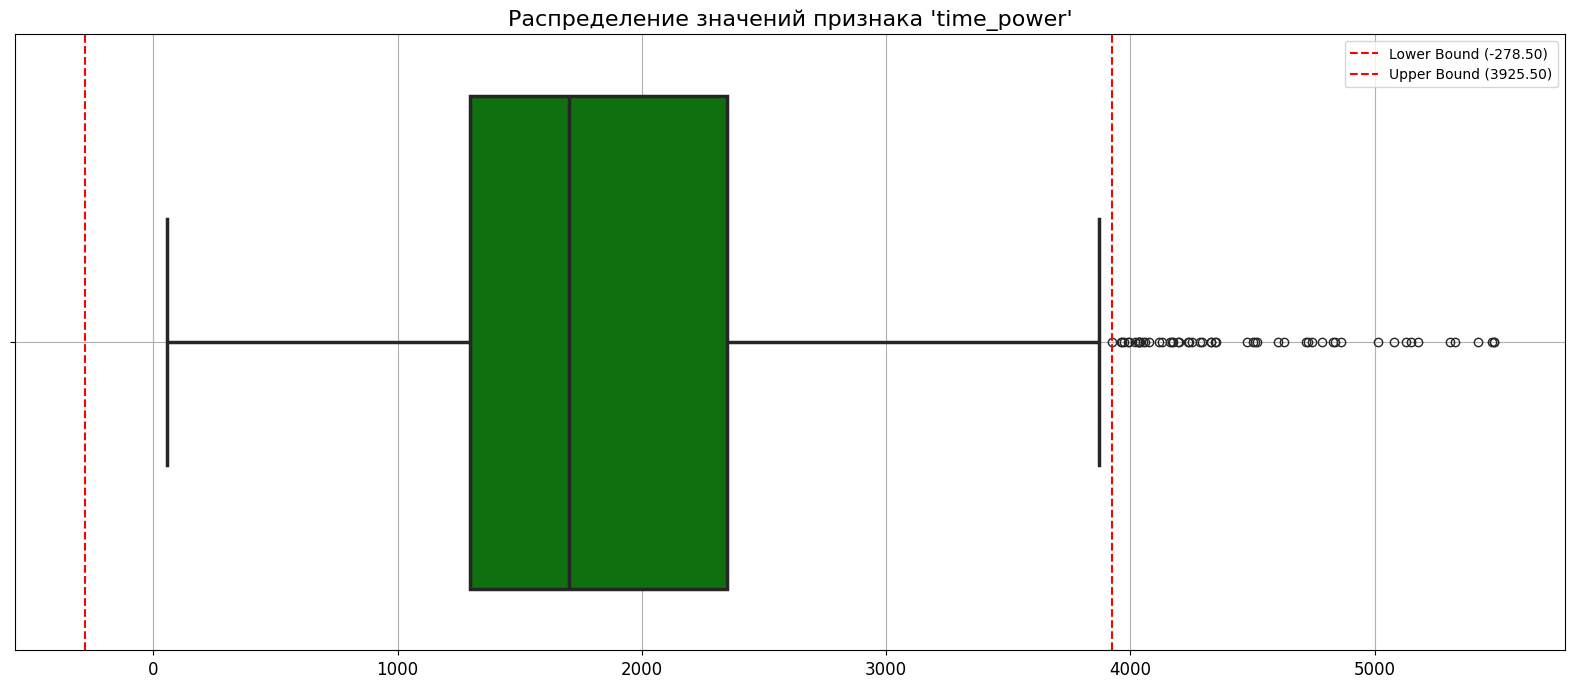

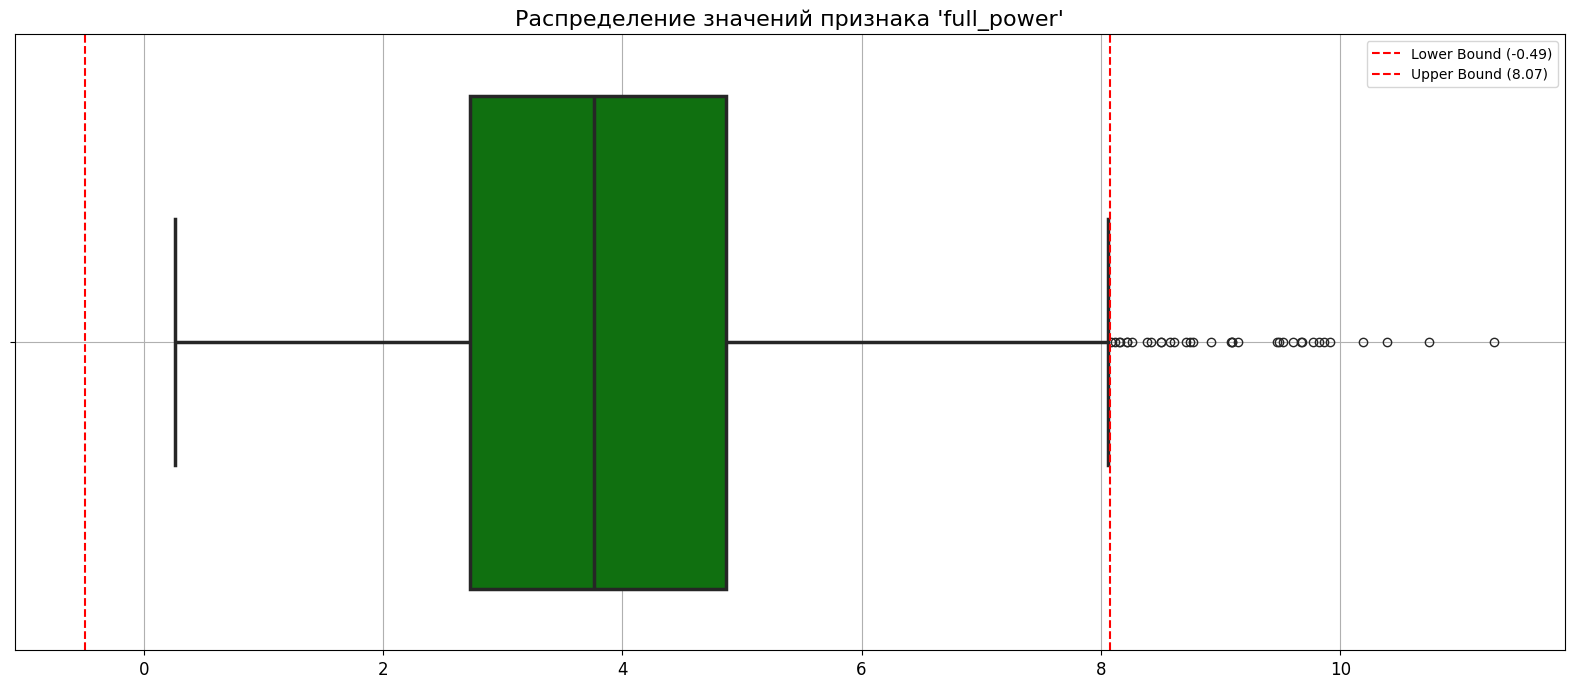

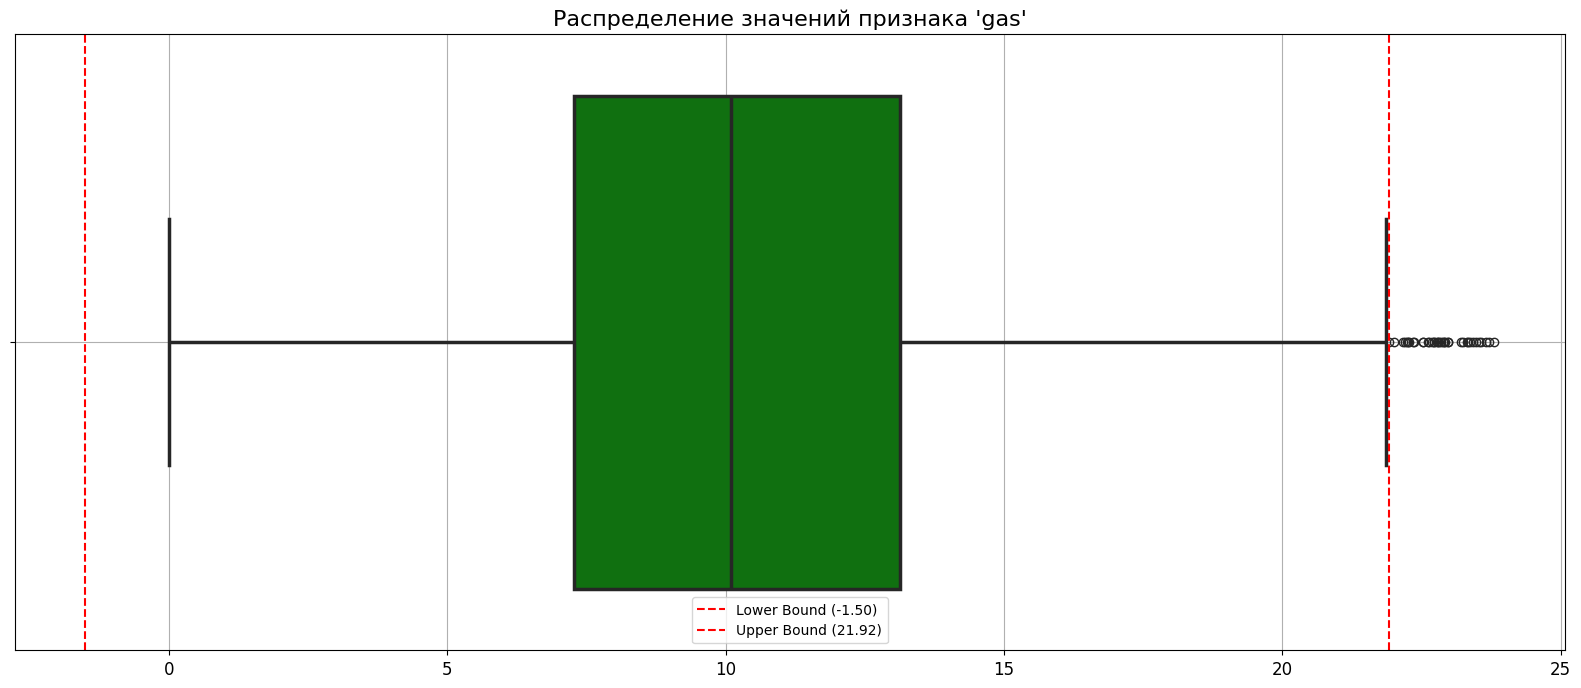

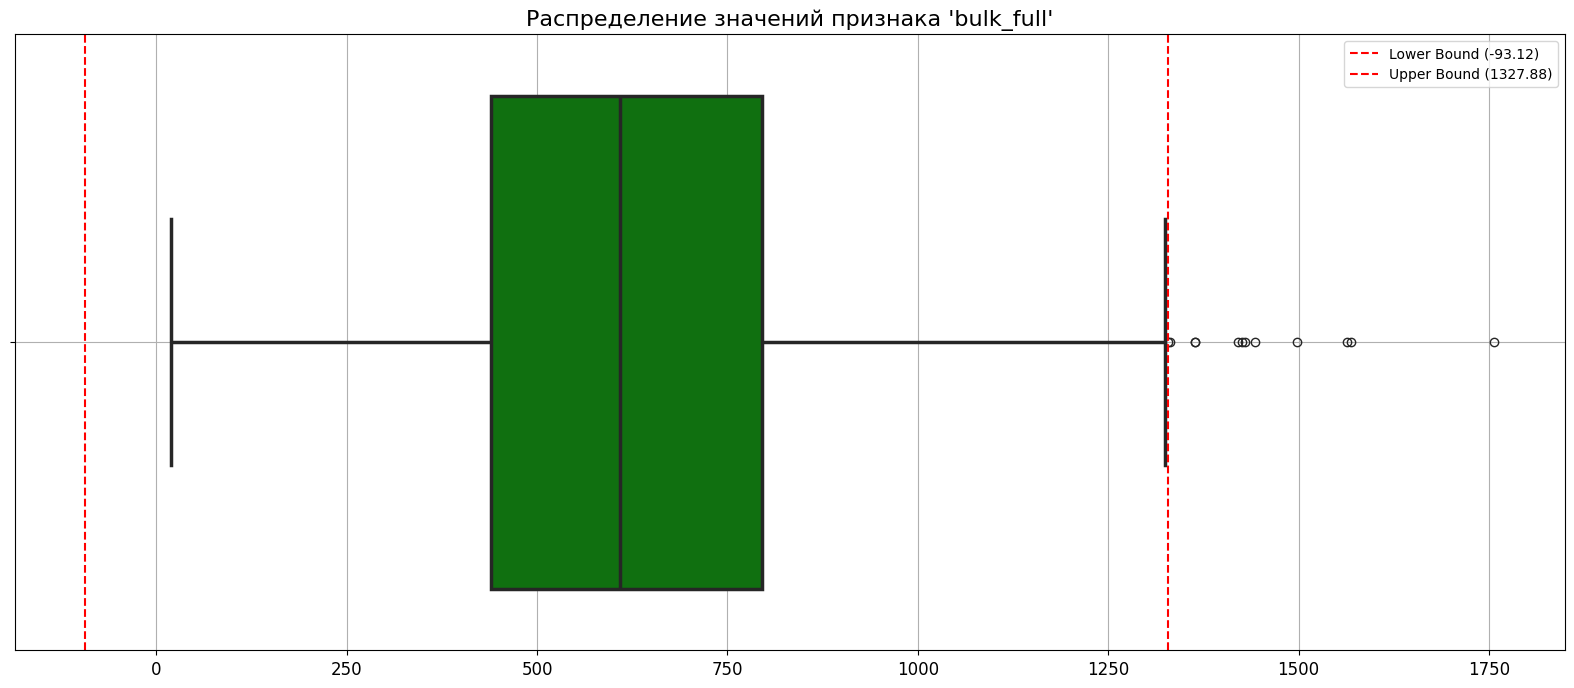

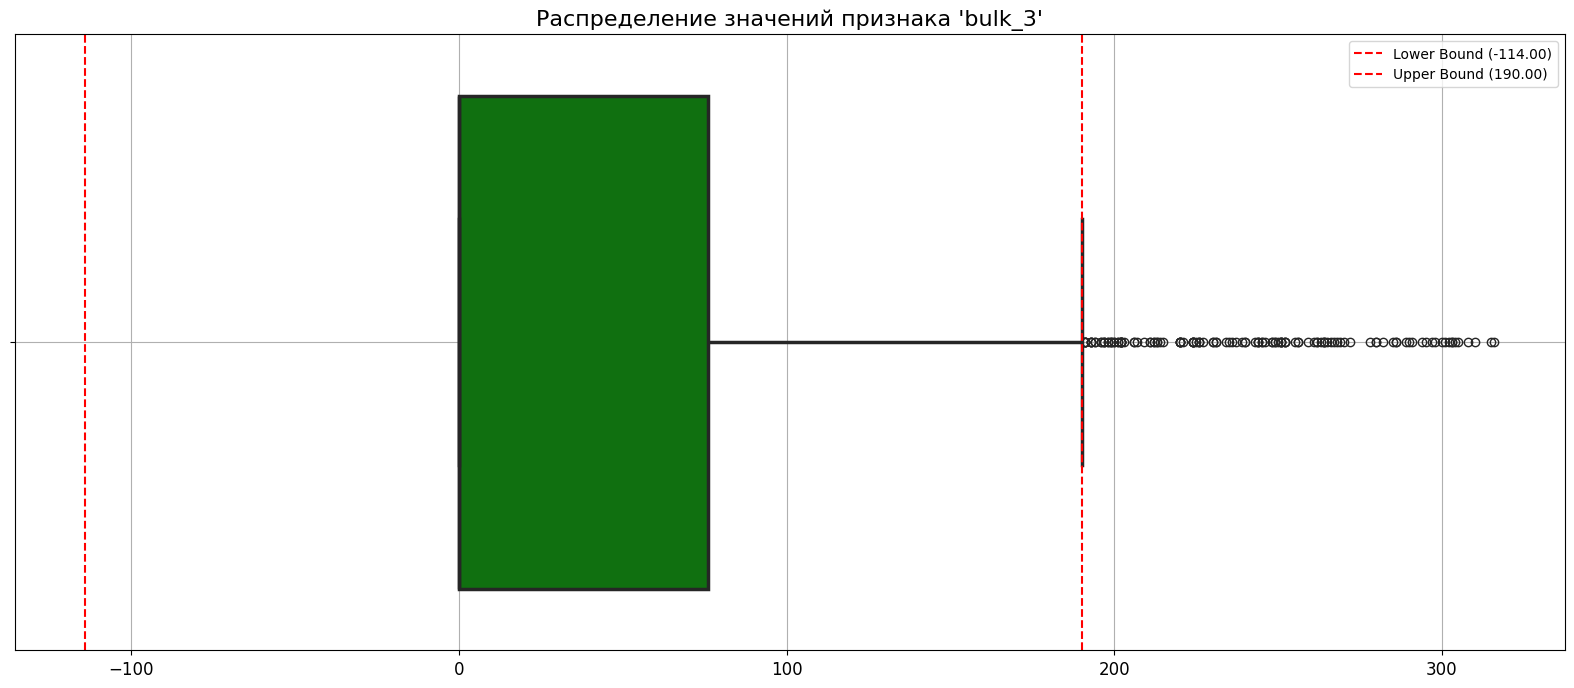

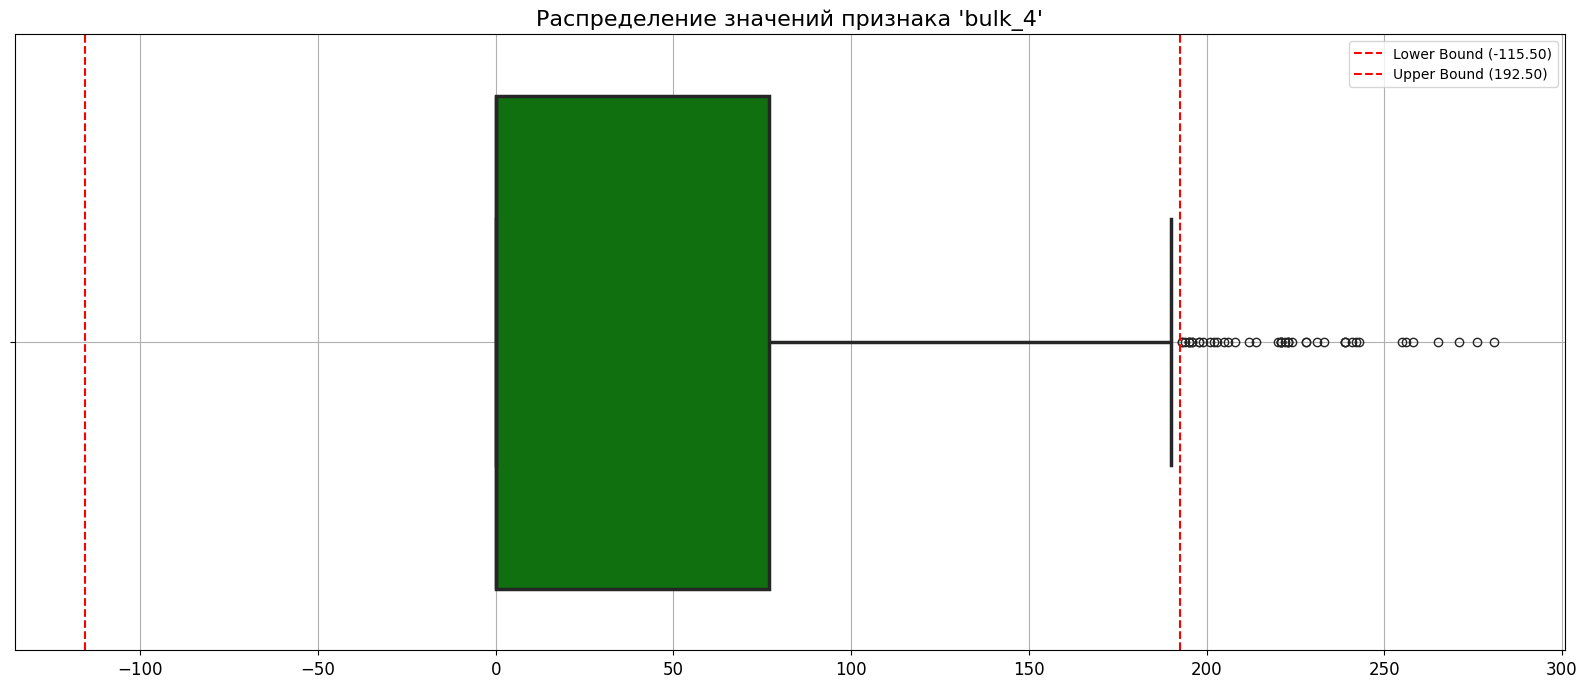

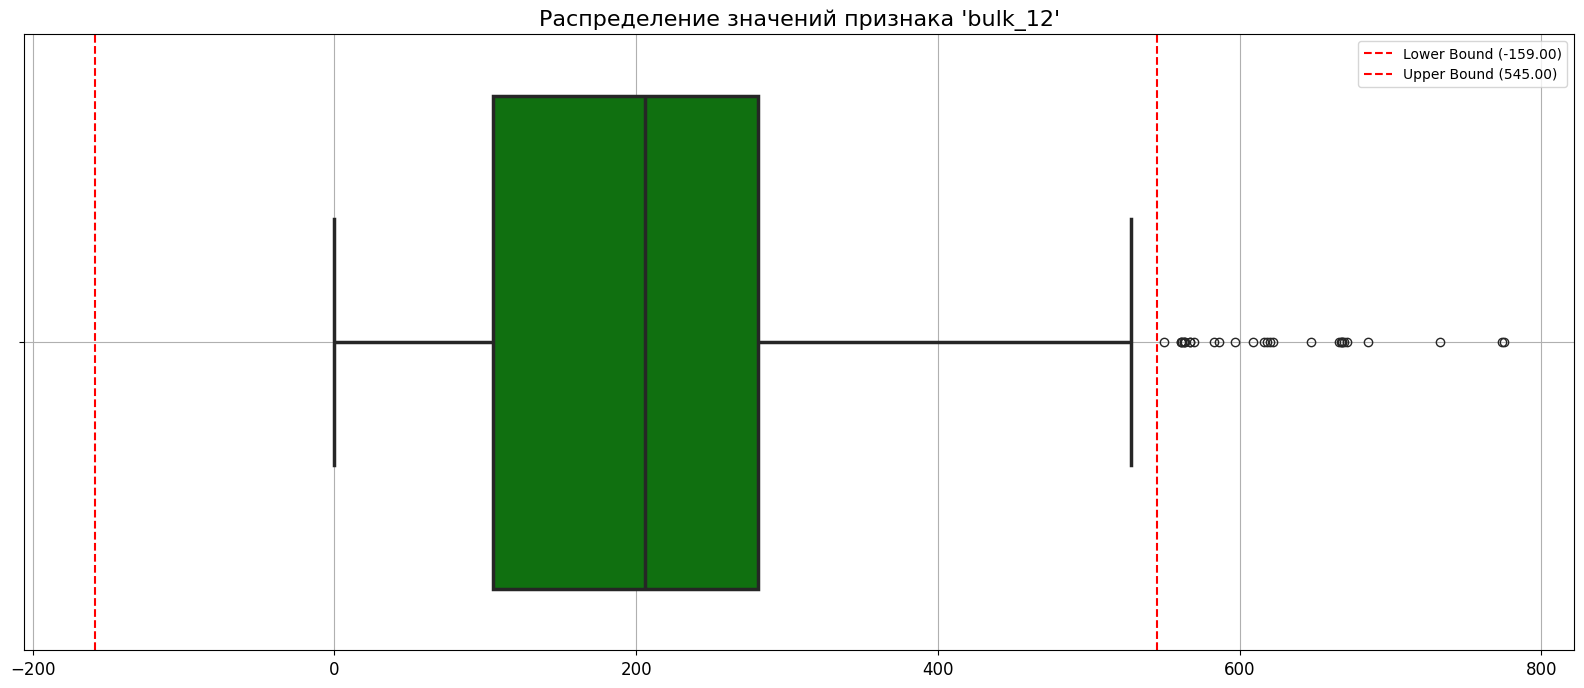

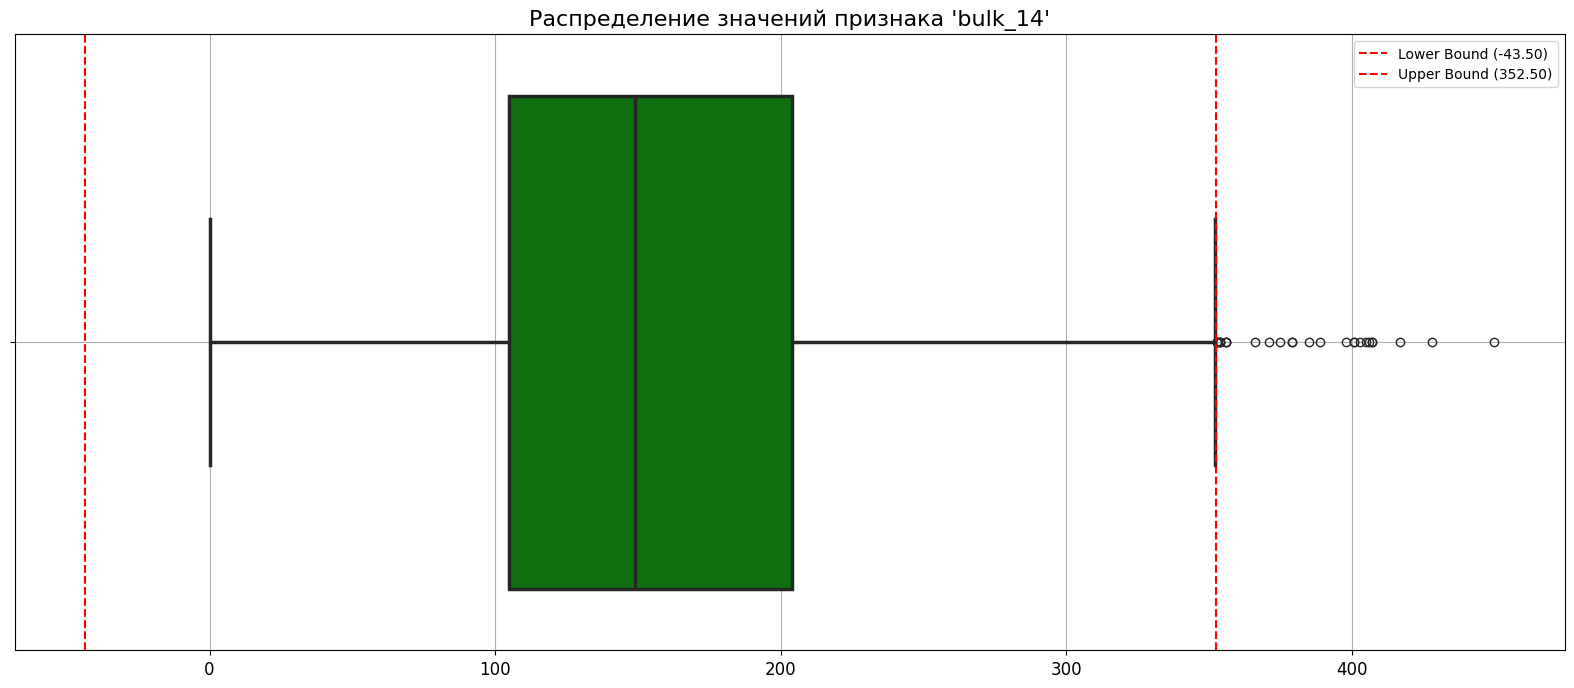

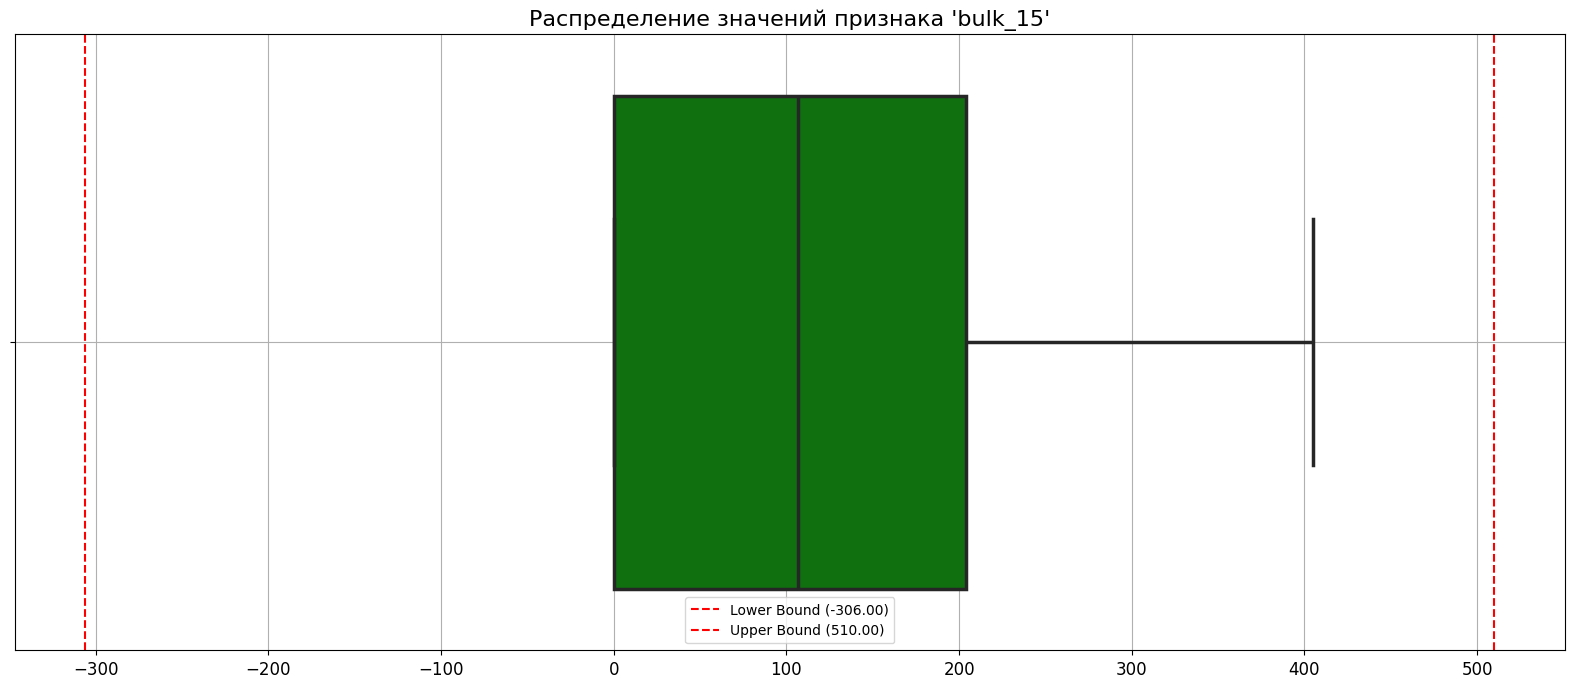

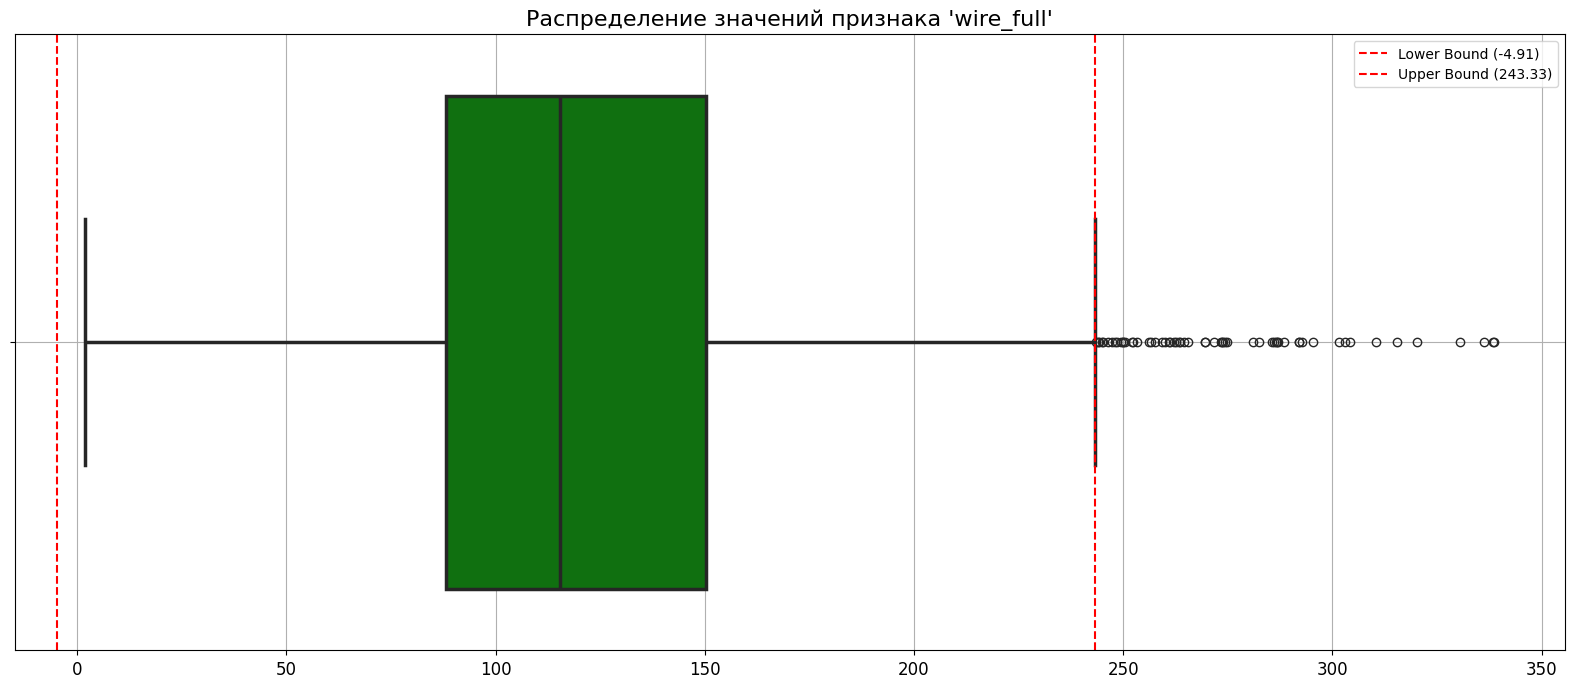

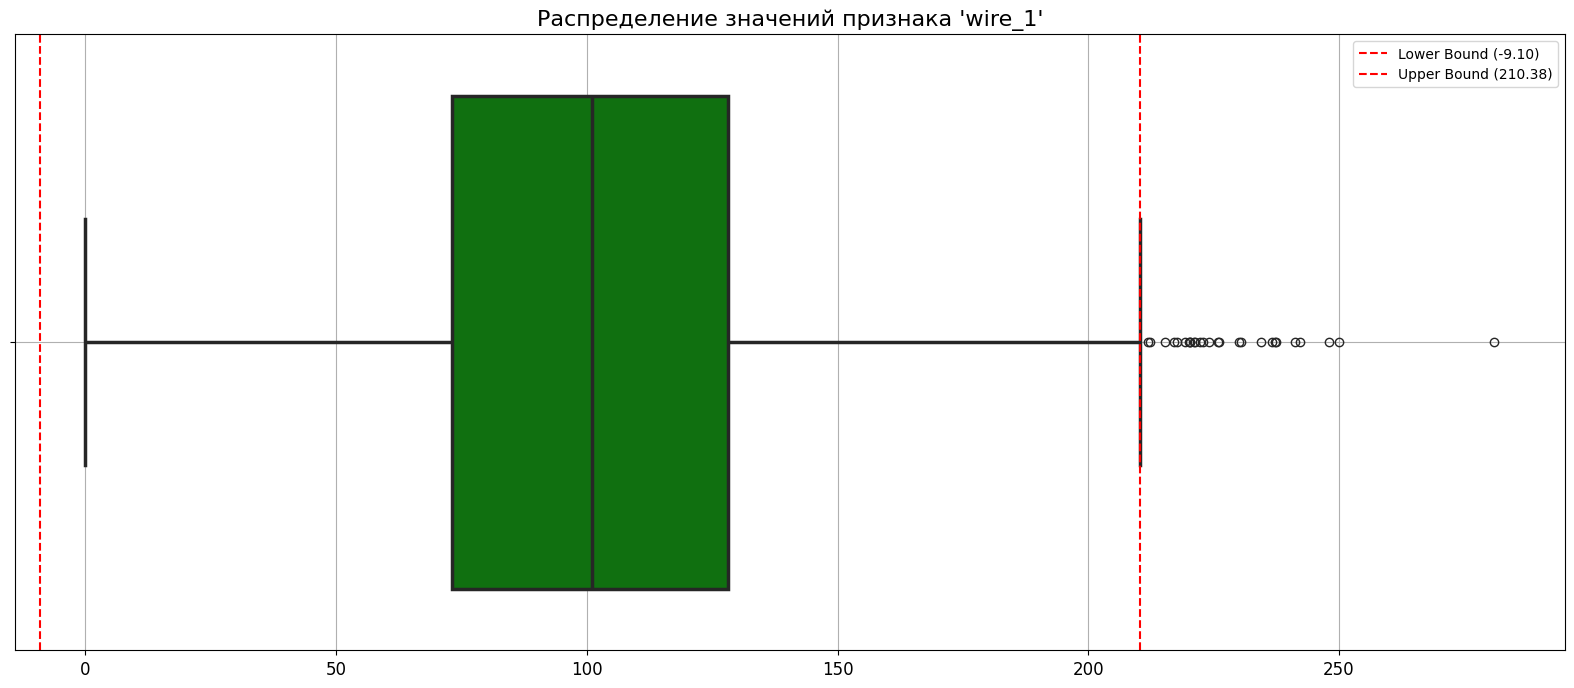

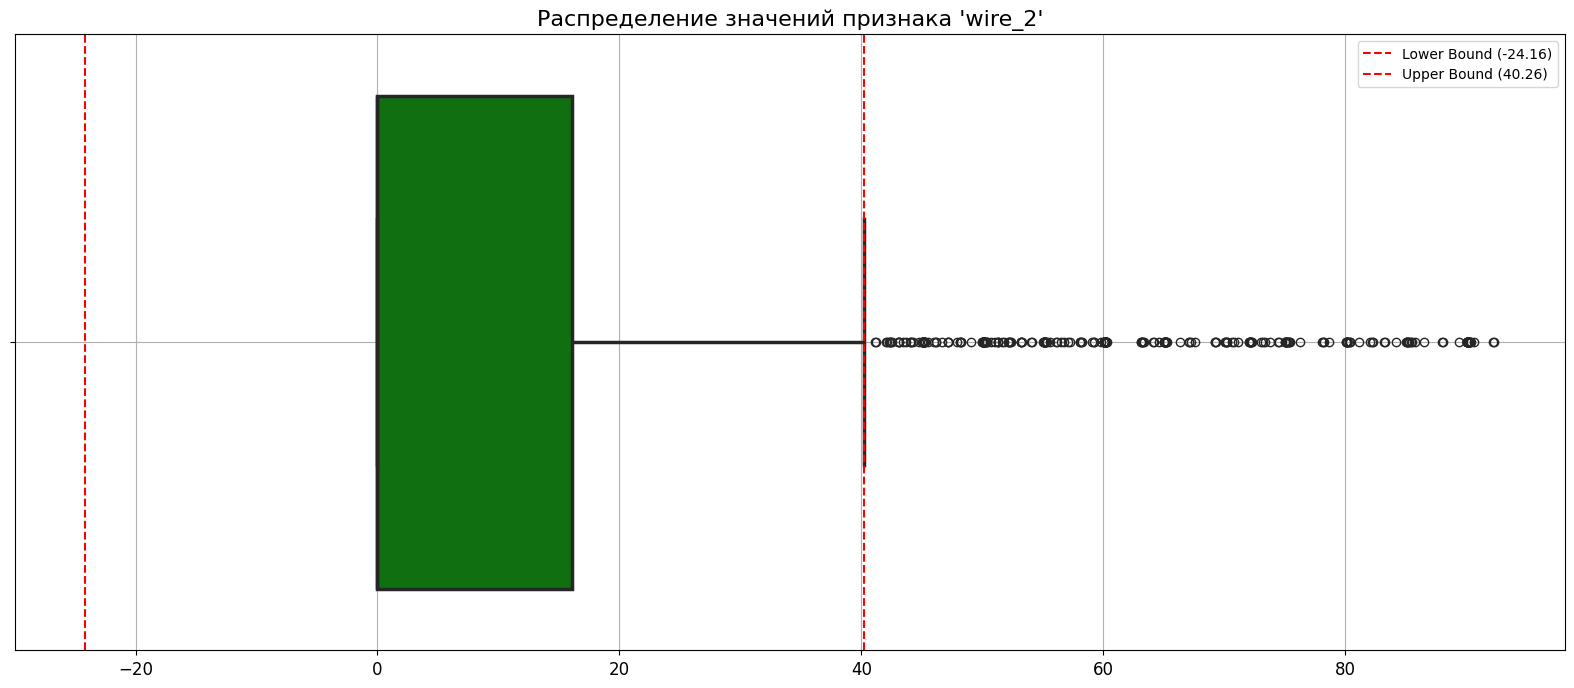

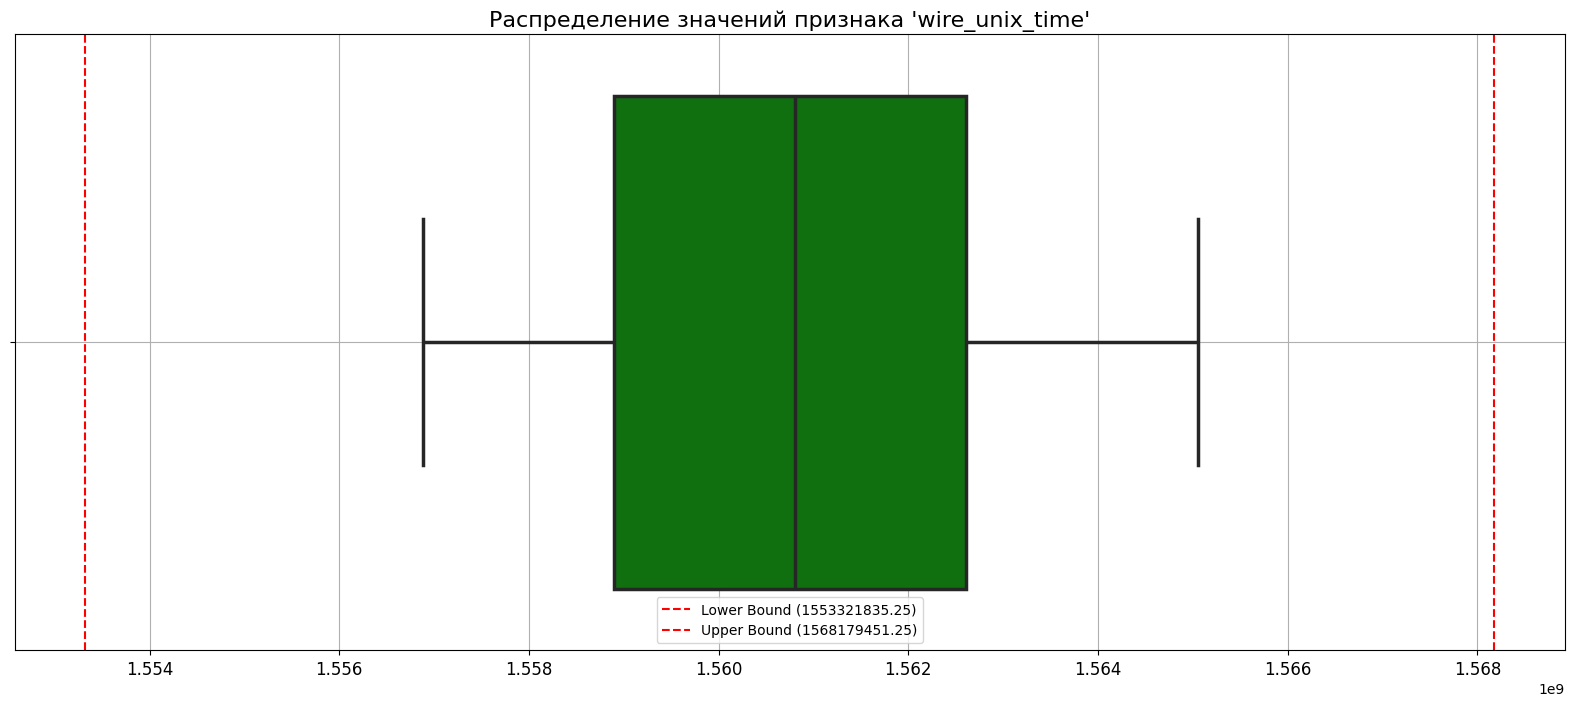

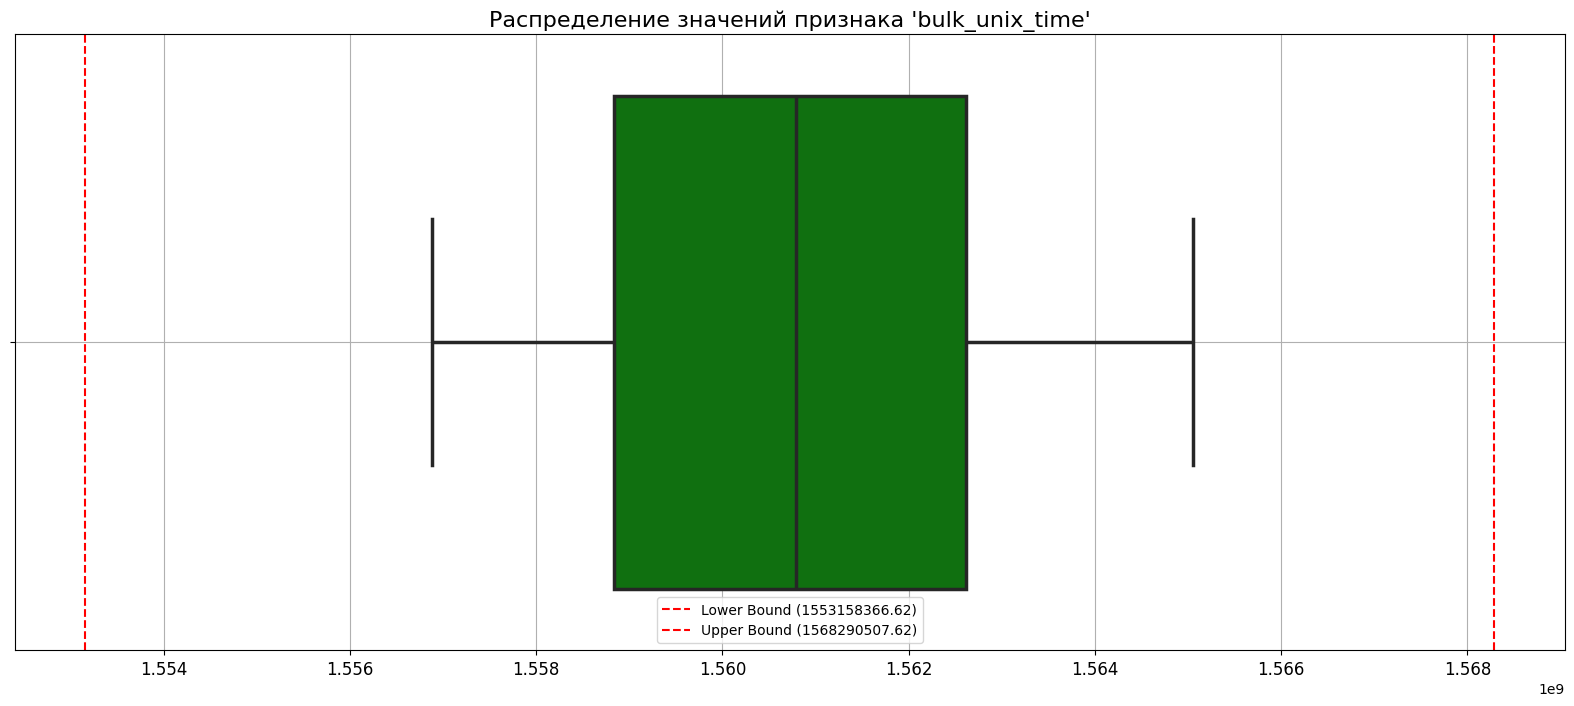

In [686]:
feature_distribution(dt, 'green')

### **Выводы:**

---

**(1)** в итоговой таблице с данными для большинства признаков характерен значительный диапазон значений. Количество значений, условно определяемых как выбросы, в целом небольшое. Все такие значения сосредоточены со стороны максимальных значений. Принято решение об их сохранении, т.к. они, вероятно, могут соответствовать особенностям технологического процесса. Вместе с тем целесообразно уточнить совместно с инженерами комбината диапазон нормальных значений и причины появления в признаках значений, существенно превышающих среднее/медианное по признаку


**(2)** проверка датасета data на мультиколинеарность позволила выявить две группы признаков, между которыми наблюдается очень высокая линейная корреляция:

 * 'bulk_14', 'bulk_unix_time'

 * 'full_power', 'time_power', 'reactive_power', 'active_power', 'temp_time_diff'


**(3)** для принятия решения о том, какие признаки из групп признаков с очень высоким уровнем линейной корреляции удалить, был использован инструмент mutual_info_regression, позволяющий получить сведения о том, какой из признаков дает больше информации о целевом признаке. Соответственно, среди потенциальных «кандидатов» на удаление были отобраны признаки, дающие меньше информации о целевом признаке


**(4)** для устранения проблемы мультиколинеарности были удалены следующие признаки: 'bulk_14', 'full_power', 'reactive_power', 'temp_time_diff'. После удаления указанных признаков в датасете отсутствуют признаки с очень высокой (> 0.9) линейной корреляцией


**(5)** дополнительно проведена проверка линейной корреляции между целевым признаком и обучающими признаками. Проверка показала отсутствие высокой и очень высокой линейной корреляции между целевым признаком и признаками. Следовательно, в обучающем комплекте нет утечки целевого признака в обучающие признаки


## **Построение модели машинного обучения**

---

### **Разделение данных на обучающую и тестовую выборки**

---

In [687]:
# выделим из датасета data признаки и целевой признак
features = data.drop('final_temp', axis = 1)
target = data['final_temp']

# выведем размеры датасетов
features.shape, target.shape

((2329, 18), (2329,))

In [688]:
target.head()

0    1613.0
1    1602.0
2    1599.0
3    1625.0
4    1602.0
Name: final_temp, dtype: float64

In [689]:
# выведем первые пять строк датасета features
features.head()

start_temp  temp_time_diff  active_power  reactive_power  time_power  \
0      1571.0           861.0      4.878147        3.183241      1583.0   
1      1581.0          1305.0      3.052598        1.998112      1144.0   
2      1596.0          1300.0      2.525882        1.599076      1525.0   
3      1601.0           388.0      3.209250        2.060298      1093.0   
4      1576.0           762.0      3.347173        2.252643      1362.0   

   full_power        gas  bulk_full  bulk_3  bulk_4  bulk_12  bulk_14  \
0    5.824889  10.229950      553.0     0.0    43.0    206.0    150.0   
1    3.648398  12.555561      582.0     0.0    73.0    206.0    149.0   
2    2.989502  10.229950      544.0     0.0    34.0    205.0    152.0   
3    3.813674  18.841219      595.0     0.0    81.0    207.0    153.0   
4    4.034596   5.413692      584.0     0.0    78.0    203.0    151.0   

   bulk_15  wire_full     wire_1   wire_2  wire_unix_time  bulk_unix_time  
0    154.0  60.059998  60.059998  0.00000      1556881901      1556881432  
1    154.0  96.052315  96.052315  0.00000      1556883970      1556883620  
2    153.0  91.160157  91.160157  0.00000      1556885627      1556885380  
3    154.0  89.063515  89.063515  0.00000      1556887685      1556887284  
4    152.0  98.352796  89.238236  9.11456      1556889495      1556889176

In [690]:
# Разделение данных на тренировочные и тестовые наборы
train_features, test_features = temporal_train_test_split(features, test_size=0.25)
train_target, test_target = temporal_train_test_split(target, test_size=0.25)

In [691]:
# Проверка размеров наборов данных
print(f'Train features shape: {train_features.shape}')
print(f'Test features shape: {test_features.shape}')
print(f'Train target shape: {train_target.shape}')
print(f'Test target shape: {test_target.shape}')

Train features shape: (1746, 18)
Test features shape: (583, 18)
Train target shape: (1746,)
Test target shape: (583,)


In [692]:
# Адаптация табличных данных к формату временных рядов
scaler = StandardScaler()
feature_transformer = TabularToSeriesAdaptor(scaler)
train_features_transformed = feature_transformer.fit_transform(train_features)
test_features_transformed = feature_transformer.transform(test_features)

In [693]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

AutoARIMA - Mean Absolute Error: 6.263696279907018
AutoARIMA - Root Mean Squared Error: 76.9265317893812
AutoARIMA - Mean Absolute Percentage Error: 0.003936432553291248
AutoARIMA - Smape loss: 0.39348248985438294


<Figure size 1200x600 with 0 Axes>

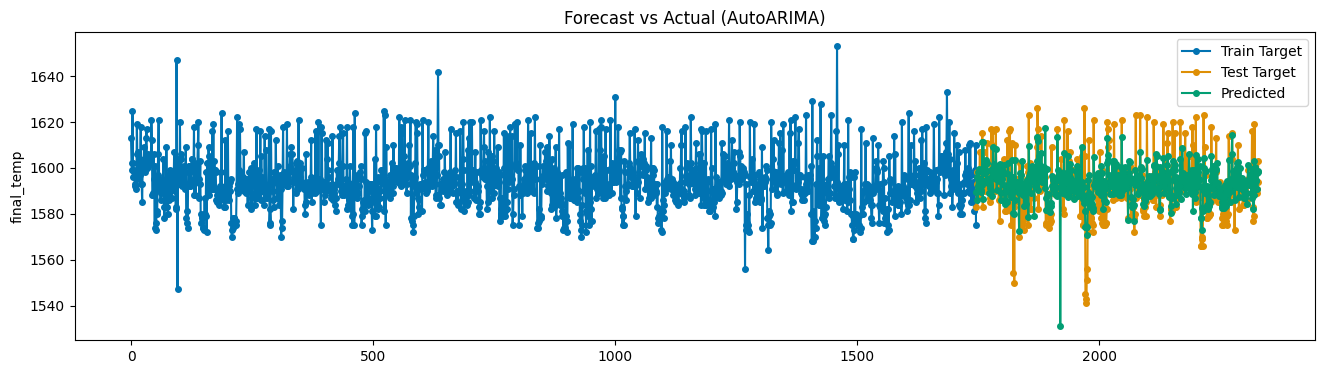

RandomForest - Mean Absolute Error: 10.017629682886895
RandomForest - Root Mean Squared Error: 169.1145694773869
RandomForest - Mean Absolute Percentage Error: 0.006307982241423551
RandomForest - Smape loss: 0.62886523742411


<Figure size 1200x600 with 0 Axes>

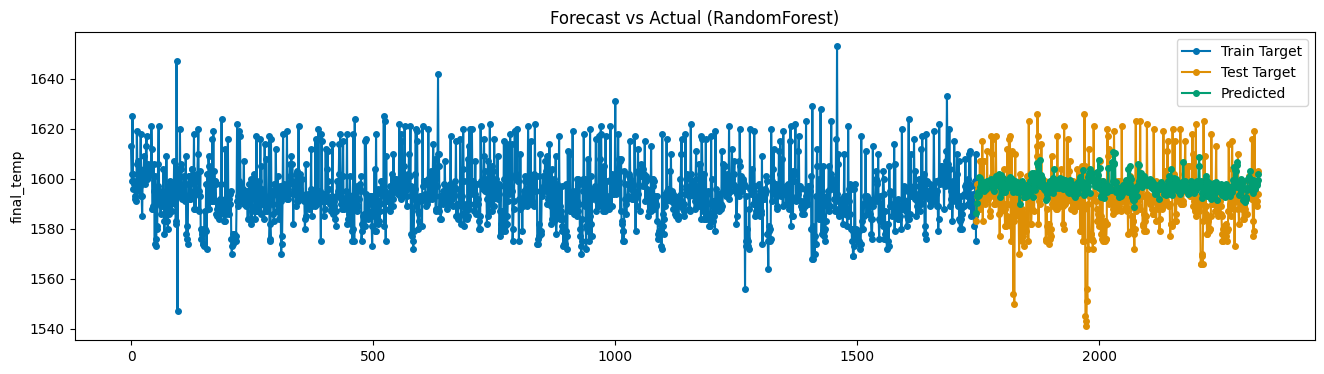

GradientBoosting - Mean Absolute Error: 10.076934563178618
GradientBoosting - Root Mean Squared Error: 172.0716764359148
GradientBoosting - Mean Absolute Percentage Error: 0.006345097728867371
GradientBoosting - Smape loss: 0.6325226492335924


<Figure size 1200x600 with 0 Axes>

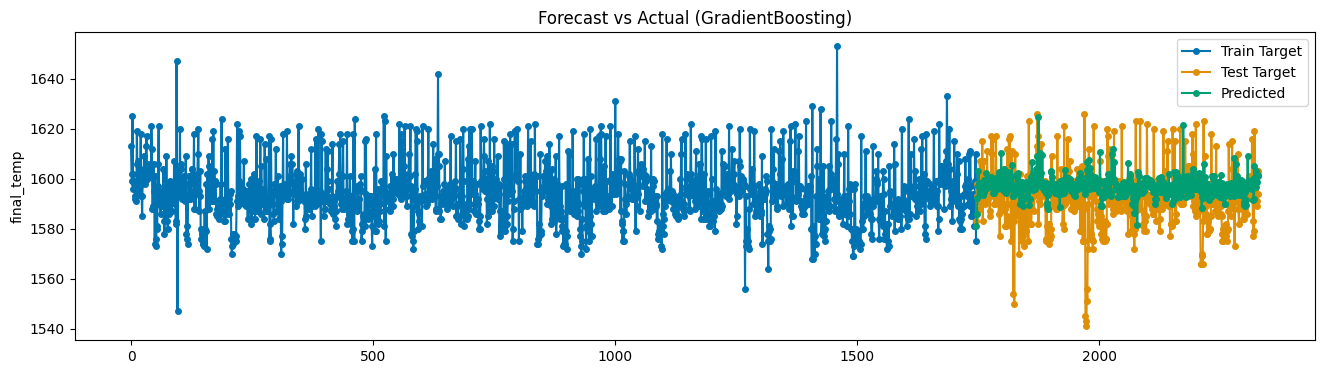

LinearRegression - Mean Absolute Error: 8.629017940210623
LinearRegression - Root Mean Squared Error: 143.0646046721012
LinearRegression - Mean Absolute Percentage Error: 0.005423111115939526
LinearRegression - Smape loss: 0.541931134572036


<Figure size 1200x600 with 0 Axes>

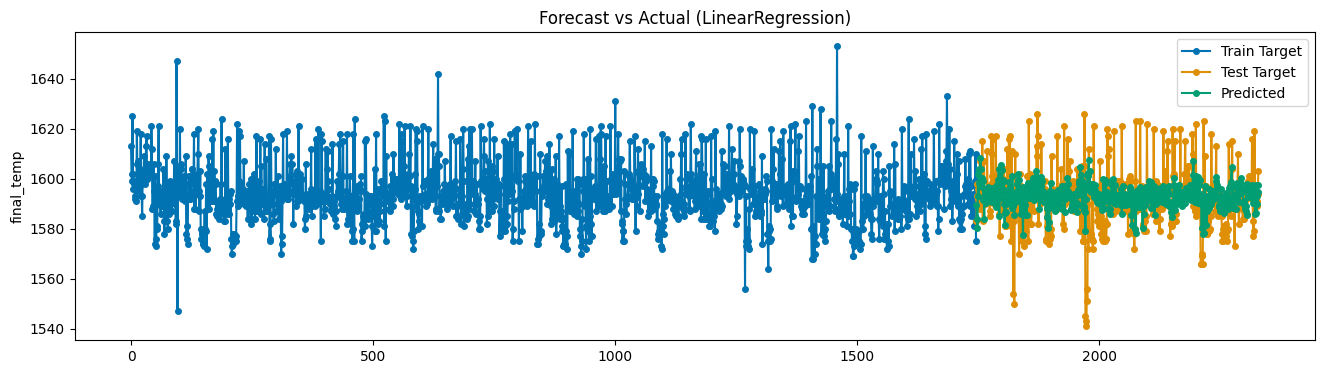

XGBoost - Mean Absolute Error: 10.206449774294374
XGBoost - Root Mean Squared Error: 176.02234554579093
XGBoost - Mean Absolute Percentage Error: 0.006422878045831584
XGBoost - Smape loss: 0.6406238435135817


<Figure size 1200x600 with 0 Axes>

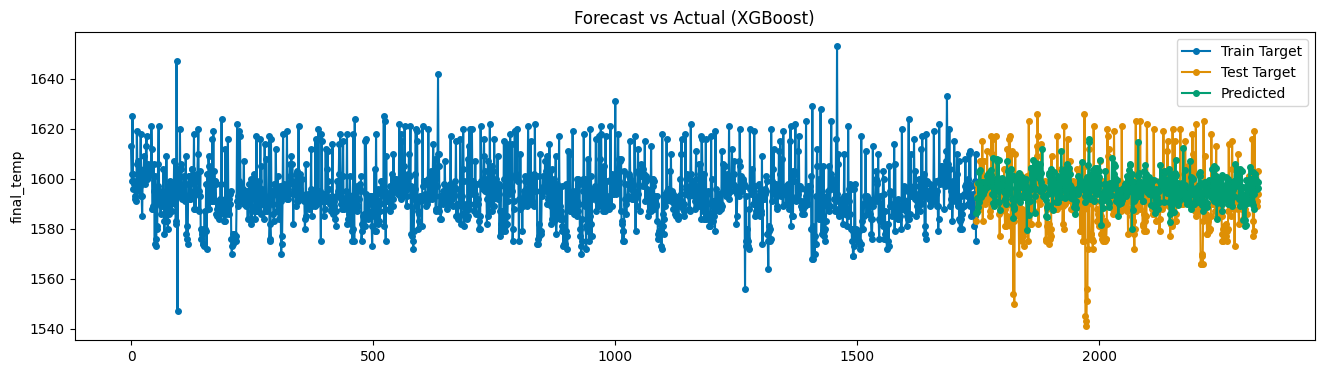

CatBoost - Mean Absolute Error: 9.185204735179854
CatBoost - Root Mean Squared Error: 154.47866831823154
CatBoost - Mean Absolute Percentage Error: 0.005781074926757966
CatBoost - Smape loss: 0.576730769850292


<Figure size 1200x600 with 0 Axes>

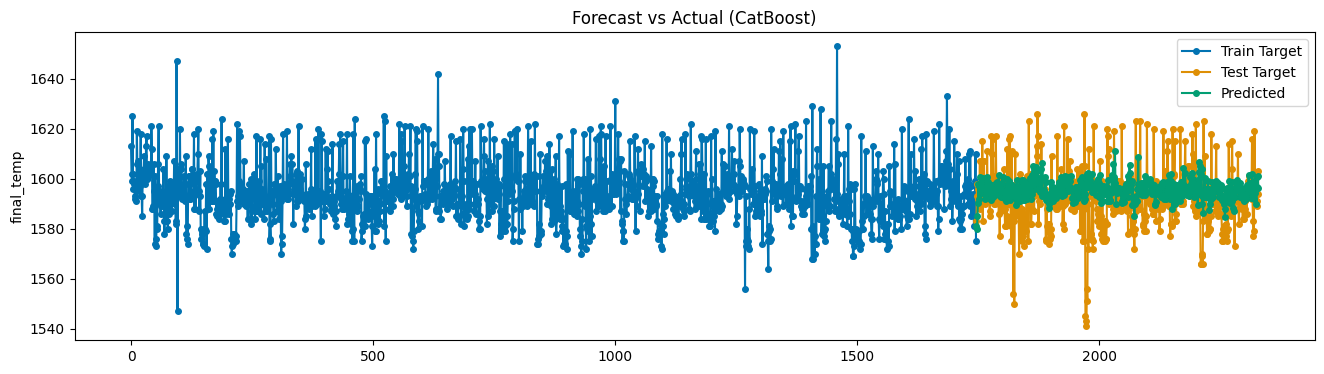

In [694]:
# Создание различных моделей
models = {
    "AutoARIMA": AutoARIMA(suppress_warnings=True),
    "RandomForest": make_reduction(RandomForestRegressor(n_estimators=200, random_state=42), strategy="recursive"),
    "GradientBoosting": make_reduction(GradientBoostingRegressor(n_estimators=200, random_state=42), strategy="recursive"),
    "LinearRegression": make_reduction(LinearRegression(), strategy="recursive"),
    "XGBoost": make_reduction(XGBRegressor(n_estimators=200, random_state=42), strategy="recursive"),
    "CatBoost": make_reduction(CatBoostRegressor(iterations=200, random_state=42, silent=True), strategy="recursive")
}

# Обертывание моделей в TransformedTargetForecaster и оценка производительности
for model_name, model in models.items():
    forecaster = TransformedTargetForecaster(steps=[
        ("log", LogTransformer()),  # Применение лог-трансформации к целевой переменной
        ("forecaster", model)
    ])
    
    # Обучение модели
    forecaster.fit(y=train_target, X=train_features_transformed)
    
    # Прогнозирование
    fh = ForecastingHorizon(test_target.index, is_relative=False)
    y_pred = forecaster.predict(fh=fh, X=test_features_transformed)
    
    # Оценка модели
    mae = mean_absolute_error(test_target, y_pred)
    rmse = mean_squared_error(test_target, y_pred, squared=False)
    mape = mean_absolute_percentage_error(test_target, y_pred)
    smape_loss_value = smape(test_target, y_pred)
    print(f'{model_name} - Mean Absolute Error: {mae}')
    print(f'{model_name} - Root Mean Squared Error: {rmse}')
    print(f'{model_name} - Mean Absolute Percentage Error: {mape}')
    print(f'{model_name} - Smape loss: {smape_loss_value}')
    
    # Построение графика
    plt.figure(figsize=(12, 6))
    plot_series(train_target, test_target, y_pred, labels=["Train Target", "Test Target", "Predicted"])
    plt.title(f'Forecast vs Actual ({model_name})')
    plt.show()